# Higgs Analysis:

>This notebook contains work performed on coffea-casa cloud server. 
> Work in progress

In [1]:
from datetime import datetime
import pytz

ist = pytz.timezone('Asia/Kolkata')
print(f"Last modified: {datetime.now(ist).strftime('%d %B %Y, %H:%M')} IST")

Last modified: 14 February 2026, 02:22 IST


# Imports 

In [2]:
import time
import gc
import psutil

import pandas as pd
from tqdm import tqdm
!pip install prettytable
%matplotlib inline

import dask
from dask import delayed, compute
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.distributed import progress
from distributed import progress
# print("\n")
# print("\n")
from hww_tools import *

print(" \n All imports loaded")

hww_tools loaded successfully.
- Config
- Efficiency_data
- Physics_selection
- Plots_config
- calculations
- cross_section
- cutflow_utils
- cuts
- helper
- json_validation
- dask_utils
- plotting
- processor
 
 All imports loaded


## Setting up dask client

In [3]:
client = get_client("tls://localhost:8786")
display(client)

<Client: 'tls://192.168.235.124:8786' processes=0 threads=0, memory=0 B>

In [4]:
prepare_workers(client)

Zipping hww_tools from /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis...
Uploading hww_tools.zip to cluster...
Upload complete. Workers can now import hww_tools.
Verifying import on workers...


## Loading Files

In [5]:
files = load_all_files(DATA_DIR, MC_DIR, max_per_sample=1)  # TESTING
# files = load_all_files(DATA_DIR, MC_DIR)  # FULL 

samples_to_process(files)


FILES TO PROCESS
Data                :    1 files
VG                  :    1 files
ggH_HWW             :    1 files
WW                  :    1 files
Fakes               :    1 files
Diboson             :    1 files
DY_to_Tau_Tau       :    1 files
ggWW                :    1 files
Top_antitop         :    1 files
______________________________________________________________________
TOTAL               :    9 files


# Histogram Initialization

In [6]:
hist_data = {}

for label in sorted(files.keys()): 
    hist_data[label] = helper.initialize_stage_histograms(
        Config.stage_names, 
        Plots_config.variables_to_plots, 
        Config.VARIATIONS
    )

print(f"Histogram storage initialized for {len(hist_data)} samples.")

Histogram storage initialized for 9 samples.


# Processing

## Processing function

In [8]:
# 1. SETUP & CONSTANTS
print("\n" + "="*70)
print("PROCESSING START!! ")
print(f"Output Directory: {Config.OUTPUT_DIR}")
print("="*70)

project_path = os.getcwd()

# Load Configuration from modules
stage_names = Config.stage_names
cutflow_stages = Config.cutflow_stages
VARIATIONS = Config.VARIATIONS
variables_to_plots = Plots_config.variables_to_plots

# Load Golden JSON
golden_json_data = None
if Config.GOLDEN_JSON_PATH.exists():
    print(f"Reading Golden JSON: {Config.GOLDEN_JSON_PATH.name}")
    with open(Config.GOLDEN_JSON_PATH, 'r') as f:
        golden_json_data = json.load(f)
    print(f"  Loaded {len(golden_json_data)} runs into memory\n")
else:
    print(f"WARNING: Golden JSON not found at {Config.GOLDEN_JSON_PATH}")

# System Info
# Note: 'files' must be loaded in a previous cell using helper.load_all_files
total_files = sum(len(urls) for urls in files.values())
print(f"System Info:")
print(f"  Total files: {total_files}")
print(f"  Samples: {len(files)}")
print("="*70)

# 2. PREPARE PROCESSOR
# Use the function from the new processor module
processing_task = processor.make_processor(
    golden_json_data=golden_json_data,
    sample_info_detailed=cross_section.sample_info_detailed, 
    luminosity=cross_section.LUMINOSITY,                       
    run_periods=Config.RUN_PERIODS_2016,
    project_dir=project_path 
)

arg_labels = []
arg_urls = []
arg_indices = []

print("Preparing file lists...")

for label, urls in files.items():
    is_data = (label == 'Data')
    
    if is_data and golden_json_data is not None:
         print(f"  {label}: Validation enabled ({len(urls)} files)")
    
    # Build flat lists for Dask mapping
    for file_idx, file_url in enumerate(urls):
        arg_labels.append(label)
        arg_urls.append(file_url)
        arg_indices.append(file_idx)

# 3. SUBMIT TO CLUSTER
start_time = time.perf_counter()

print(f"\nSubmitting {len(arg_urls)} files to the cluster...")

futures = client.map(
    processing_task, 
    arg_labels, 
    arg_urls, 
    arg_indices,
    retries=1  
)

# 4. MONITOR AND GATHER
print("Processing files...")
progress(futures)

# Gather results 
results = client.gather(futures)

elapsed = time.perf_counter() - start_time

# 5. MERGE RESULTS
print("\n" + "="*70)
print("File processing complete. Merging results...")
print("="*70)

hist_data_final = {}
cutflow_final = {}
weighted_cutflow_final = {}  

# Initialize storage for all samples
for label in files.keys():
    # Use helper to initialize histograms
    hist_data_final[label] = helper.initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS)
    cutflow_final[label] = {stage: 0 for stage in cutflow_stages}
    weighted_cutflow_final[label] = {stage: 0.0 for stage in cutflow_stages}      
    
error_count = 0

for task_idx, result in enumerate(results):
    label, stage_histograms, cutflow, weighted_cutflow, error = result
    
    if error:
        error_count += 1
        file_url = arg_urls[task_idx]
        file_name = file_url.split('/')[-1]
        print(f" ERROR in {label}/{file_name}")
        print(f"    Reason: {error}")
        continue

    # A. Merge Cutflows
    if cutflow:
        for stage, count in cutflow.items():
            if stage in cutflow_final[label]:
                cutflow_final[label][stage] += count
    
    if weighted_cutflow:
        for stage, weighted_count in weighted_cutflow.items():
            if stage in weighted_cutflow_final[label]:
                weighted_cutflow_final[label][stage] += weighted_count
    
    # B. Merge Histograms
    if stage_histograms:
        for stage_name, var_dict in stage_histograms.items():
            for var_name, syst_dict in var_dict.items():
                for syst_name, hist_obj in syst_dict.items():
                    # Accumulate directly into final dictionary
                    # hist objects support += operator
                    hist_data_final[label][stage_name][var_name][syst_name] += hist_obj

# 6. SAVE TO ROOT
root_file_path = Config.OUTPUT_DIR / "HWW_analysis_output.root"
print(f"\nSaving histograms to ROOT file: {root_file_path.name}...")

try:
    with uproot.recreate(root_file_path) as root_file:
        for sample, stages in hist_data_final.items():
            for stage, variables in stages.items():
                for var_name, variations in variables.items():
                    for syst_name, hist_obj in variations.items():
                        
                        # Create a unique name for the histogram in the ROOT file
                        hist_name = f"{sample}_{stage}_{var_name}_{syst_name}"
                        hist_name = hist_name.replace(" ", "_").replace("-", "_")
                        
                        # Write to file
                        root_file[hist_name] = hist_obj
                        
    print("  Success! ROOT file saved.")
except Exception as e:
    print(f"  Error saving ROOT file: {e}")

# 7. FINAL REPORT
print("\n" + "="*70)
print("FINAL EVENT COUNTS BY SAMPLE")
print("="*70)

total_events = 0
for label in files.keys():
    events = cutflow_final[label].get('total', 0)
    total_events += events
    print(f"{label:20s}: {events:>12,} events")

print("_"*70)
print(f"{'TOTAL':20s}: {total_events:>12,} events")
print("="*70)

if error_count > 0:
    print(f"\n {error_count} file(s) failed during processing")

print(f"\n Processing completed in {elapsed:.1f}s ({elapsed/60:.1f} min)")
if len(futures) > 0:
    print(f"    Average: {elapsed/len(futures):.2f}s per file")
if elapsed > 0:
    print(f"    Throughput: {total_events/elapsed:,.0f} events/sec")
print("="*70 + "\n")

# Cleanup
del futures, results, arg_urls, arg_labels, arg_indices
gc.collect()


PROCESSING START!! 
Output Directory: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs
Reading Golden JSON: Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt
  Loaded 393 runs into memory

System Info:
  Total files: 9
  Samples: 9
Preparing file lists...
  Data: Validation enabled (1 files)

Submitting 9 files to the cluster...
Processing files...


2026-02-13 20:54:57,677 - distributed.client - WARNING - Couldn't gather 4 keys, rescheduling ('processing_file-9b077b34ab6f7dc1022f652243ef60cc', 'processing_file-f20b2b2213dbe2957a4b9ba7e8524e22', 'processing_file-f9a6499ced690f29cd40e8b8e9e264f9', 'processing_file-4e89093e833287ea37e6ac2ed90b7dca')



File processing complete. Merging results...

Saving histograms to ROOT file: HWW_analysis_output.root...
  Success! ROOT file saved.

FINAL EVENT COUNTS BY SAMPLE
Data                :    2,238,235 events
VG                  :        2,125 events
ggH_HWW             :        2,000 events
WW                  :       15,000 events
Fakes               :    1,233,000 events
Diboson             :       15,000 events
DY_to_Tau_Tau       :    1,434,319 events
ggWW                :       68,000 events
Top_antitop         :      861,000 events
______________________________________________________________________
TOTAL               :    5,868,679 events

 Processing completed in 235.6s (3.9 min)
    Average: 26.18s per file
    Throughput: 24,910 events/sec



0

## Cutflow

In [9]:
save_cutflows(cutflow_final, weighted_cutflow_final, OUTPUT_DIR)
pd.read_csv(OUTPUT_DIR/"Cutflow_scaled.csv")

Saved Raw Cutflow to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Cutflow_Raw.csv
Saved Weighted Cutflow to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Cutflow_scaled.csv


Sample  Total (Raw)  e-μ Preselect  Global Cuts   0-jet   1-jet  \
0           Data   2237659.00        9622.00      1312.00  447.00  450.00   
1        ggH_HWW        10.32           0.74         0.46    0.27    0.13   
2             WW       928.76          89.21        54.07   30.56   17.06   
3    Top_antitop      8923.20           2.82         0.21    0.08    0.11   
4  DY_to_Tau_Tau   1587473.03        1538.43       113.83   24.20   61.47   
5          Fakes     45774.06          50.22         2.34    0.00    0.36   
6           ggWW         3.63           0.00         0.00    0.00    0.00   
7        Diboson      1119.96          14.38         8.89    3.04    3.71   
8             VG        57.50           0.09         0.04    0.04    0.00   
9     TOTAL (MC)   1644290.46        1695.88       179.84   58.20   82.84   

    2-jet   SR 0j   SR 1j  SR 2j  CR Top 0j  CR Top 1j  CR Top 2j  CR Tau 0j  \
0  415.00  358.00  321.00  47.00      68.00     490.00     198.00       0.00   
1    0.06    0.25    0.10   0.01       0.01       0.00       0.00       0.00   
2    6.45   27.02   14.48   1.10       0.85       0.37       0.00       0.00   
3    0.02    0.07    0.08   0.00       0.02       0.33       0.02       0.00   
4   28.16    7.86   26.07   2.16       1.08       6.43       0.00       1.08   
5    1.97    0.00    0.29   0.22       0.04       1.88       2.02       0.00   
6    0.00    0.00    0.00   0.00       0.00       0.00       0.00       0.00   
7    2.14    2.82    2.75   0.15       0.23       0.00       0.00       0.00   
8    0.00    0.04    0.00   0.00       0.00       0.00       0.00       0.00   
9   38.81   38.05   43.77   3.64       2.23       9.00       2.04       1.08   

   CR Tau 1j  CR Tau 2j  
0       0.00        1.0  
1       0.00        0.0  
2       0.00        0.0  
3       0.00        0.0  
4       0.00        0.0  
5       0.00        0.0  
6       0.00        0.0  
7       0.08        0.0  
8       0.00        0.0  
9       0.08        0.0

# Plots

## Superimposed plots

Saving superimposed plots to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Kinematics
Processing mass...
Saved plot: mass_stages.png


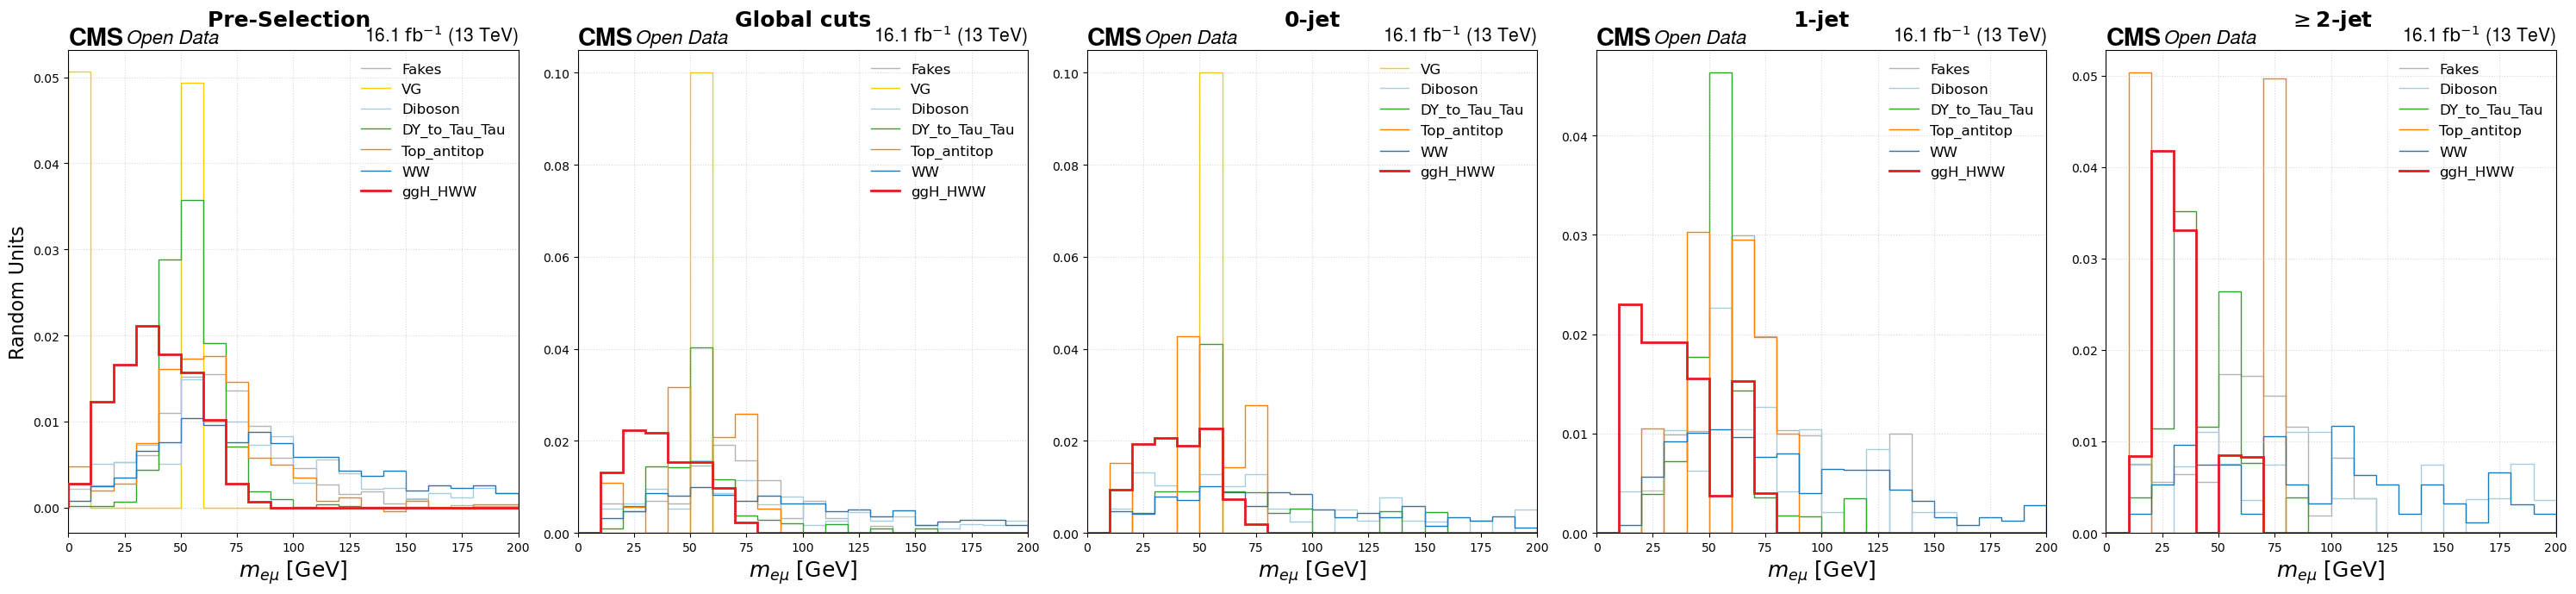

Processing met...
Saved plot: met_stages.png


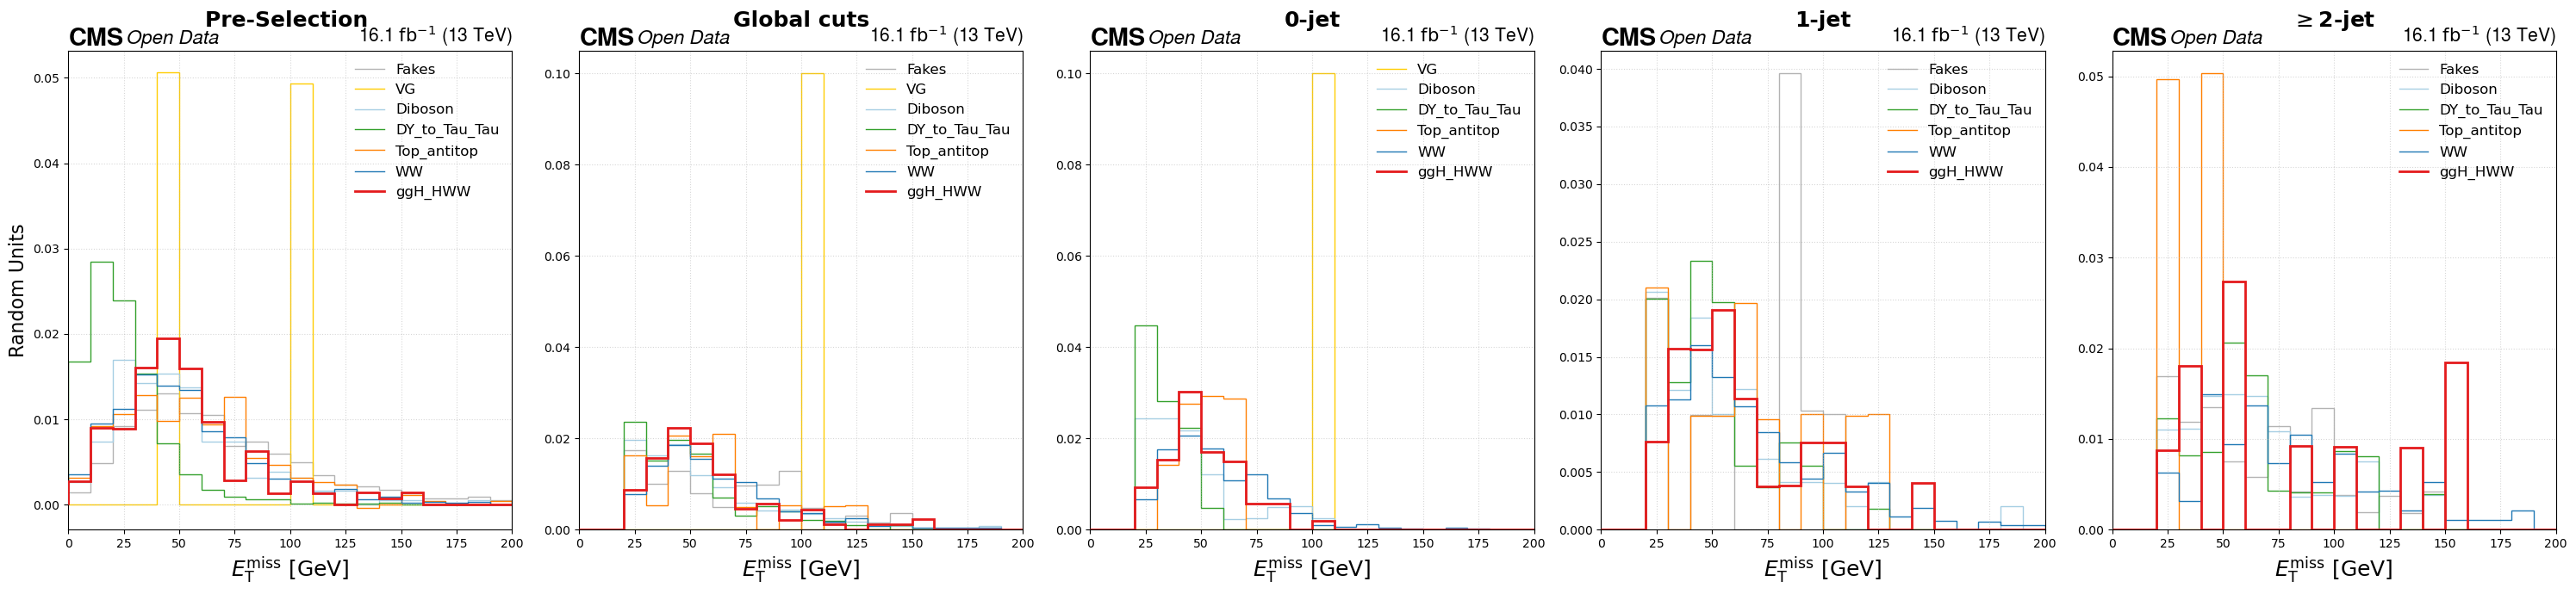

Processing dphi...
Saved plot: dphi_stages.png


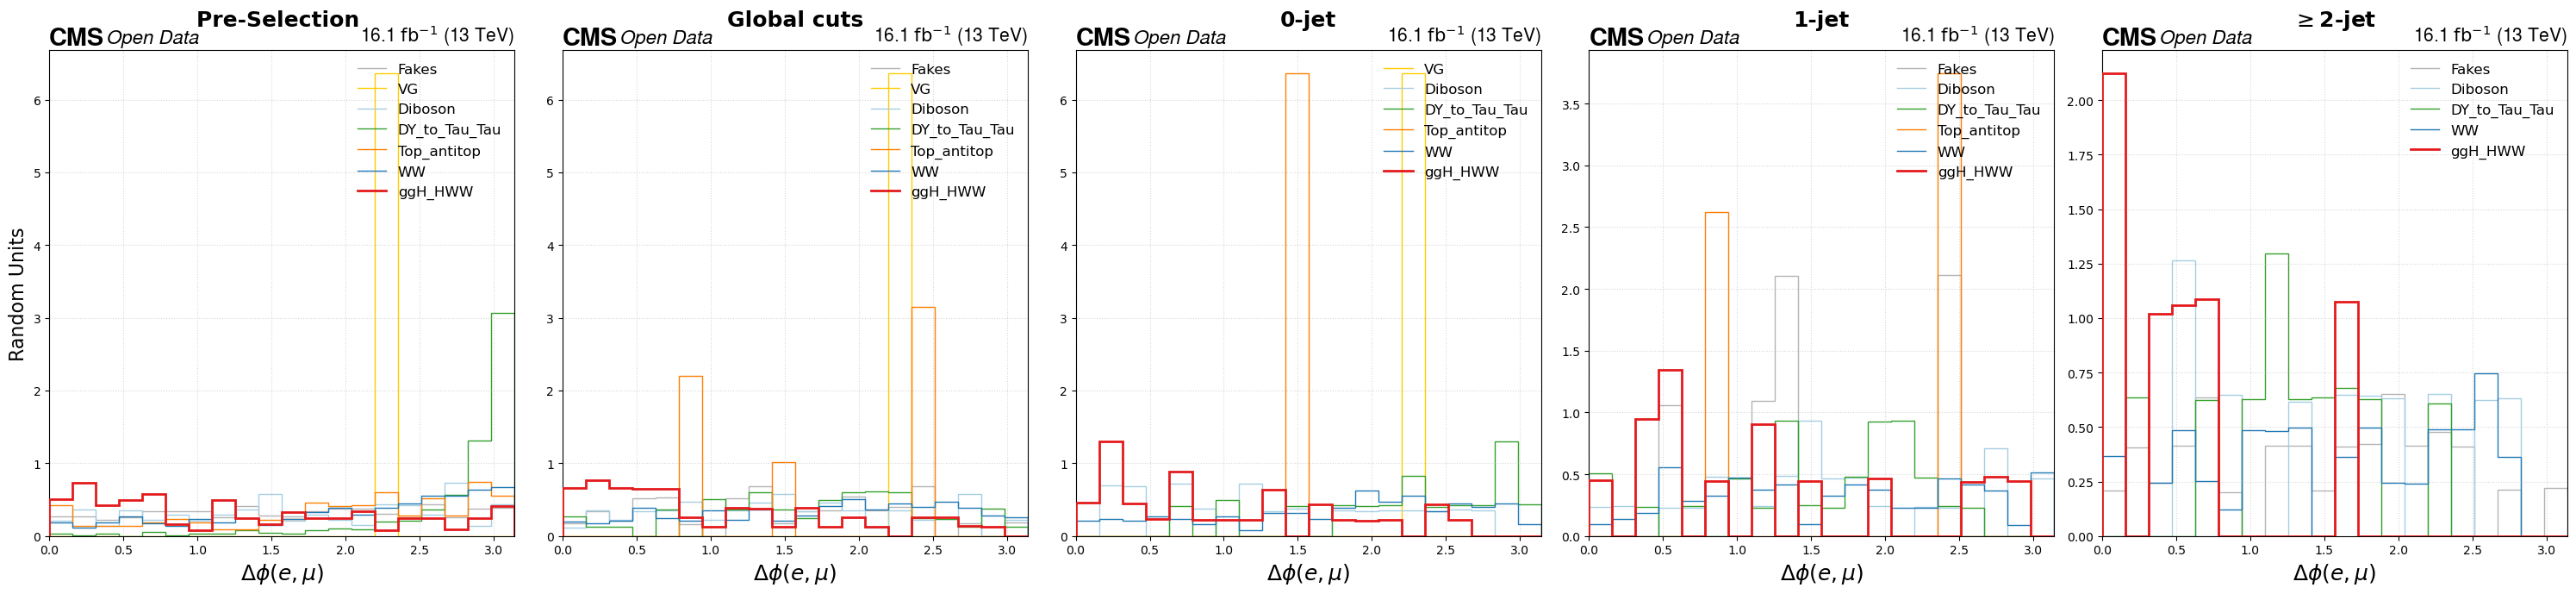

Processing ptll...
Saved plot: ptll_stages.png


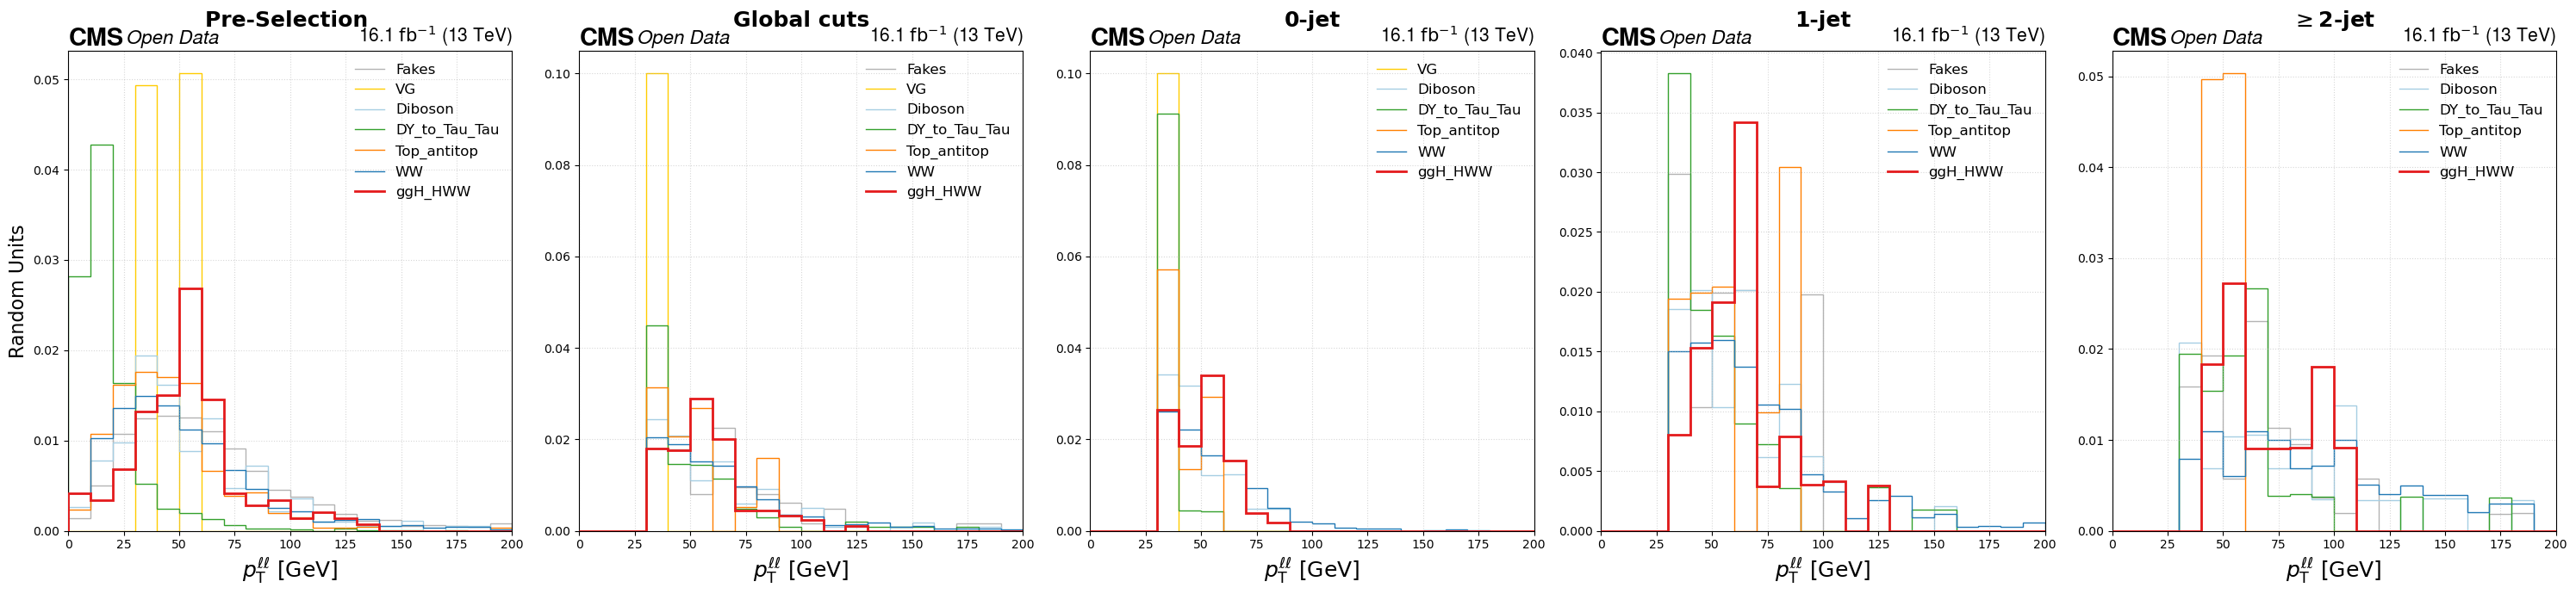

Processing mt_higgs...
Saved plot: mt_higgs_stages.png


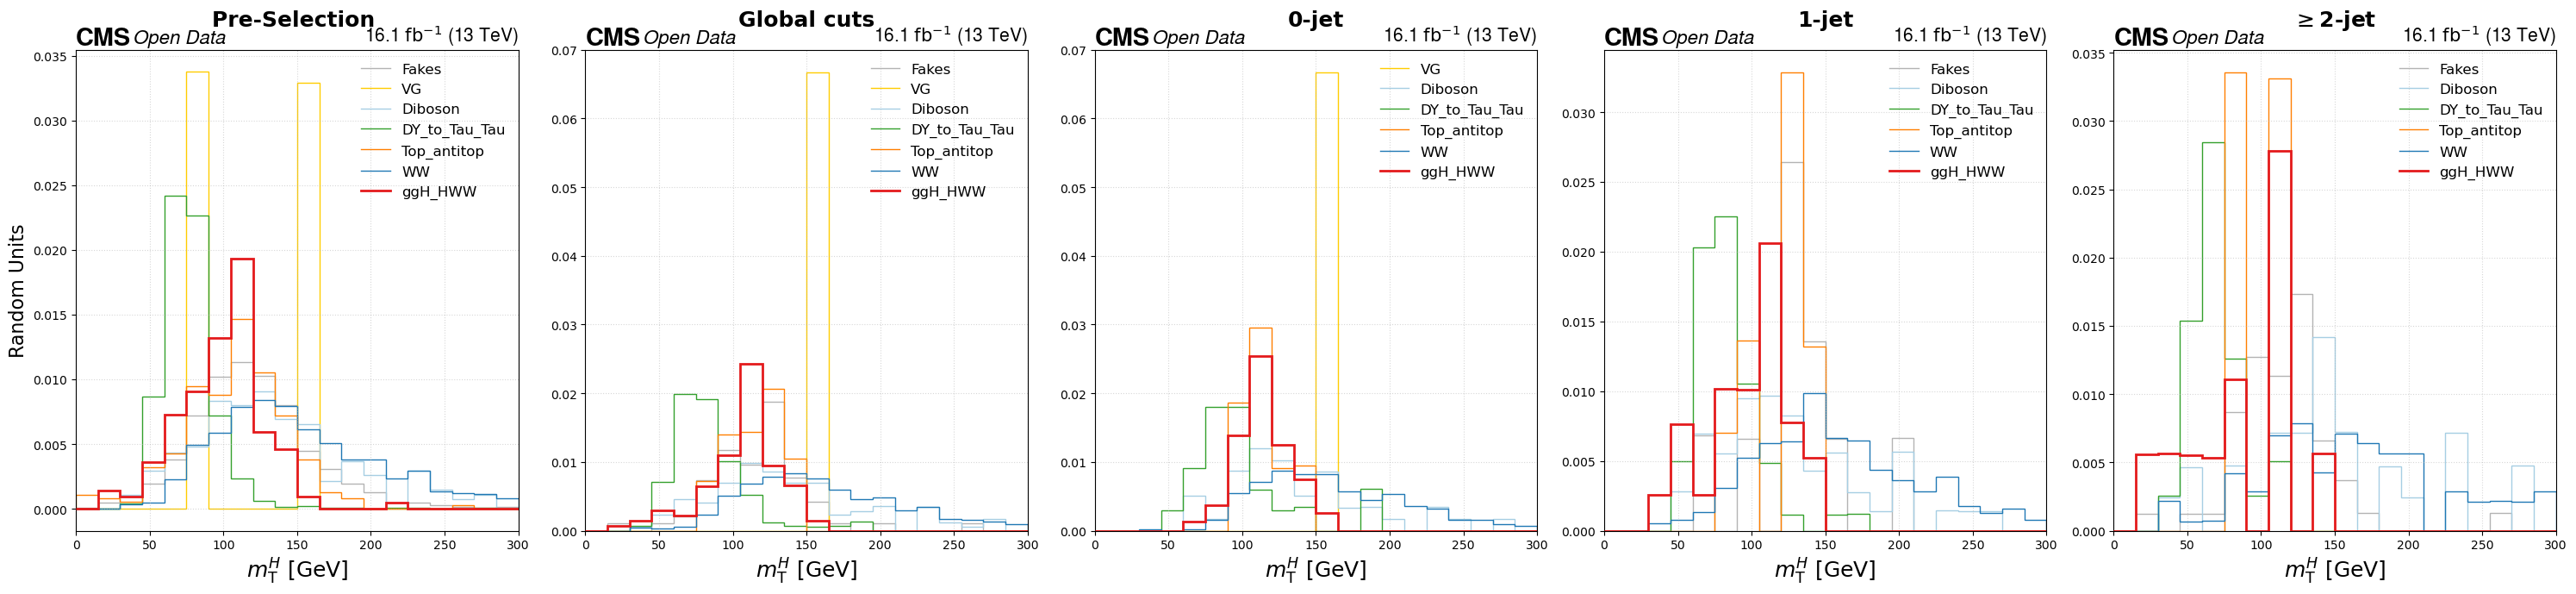

Processing mt_l2_met...
Saved plot: mt_l2_met_stages.png


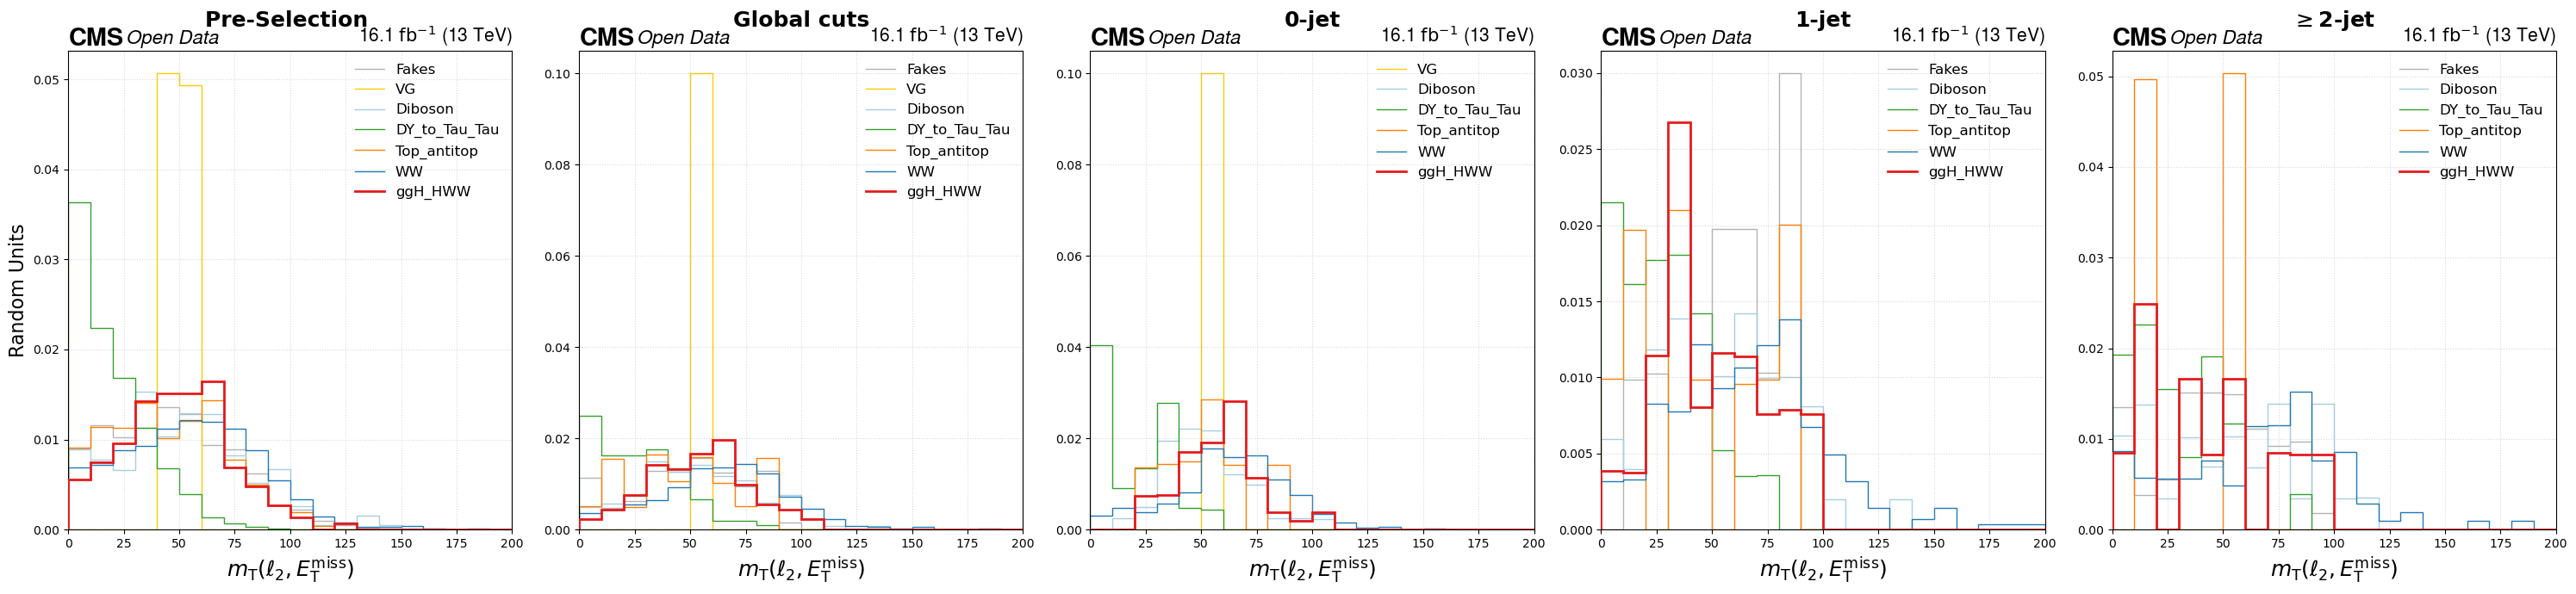

Processing mjj...
Saved plot: mjj_stages.png


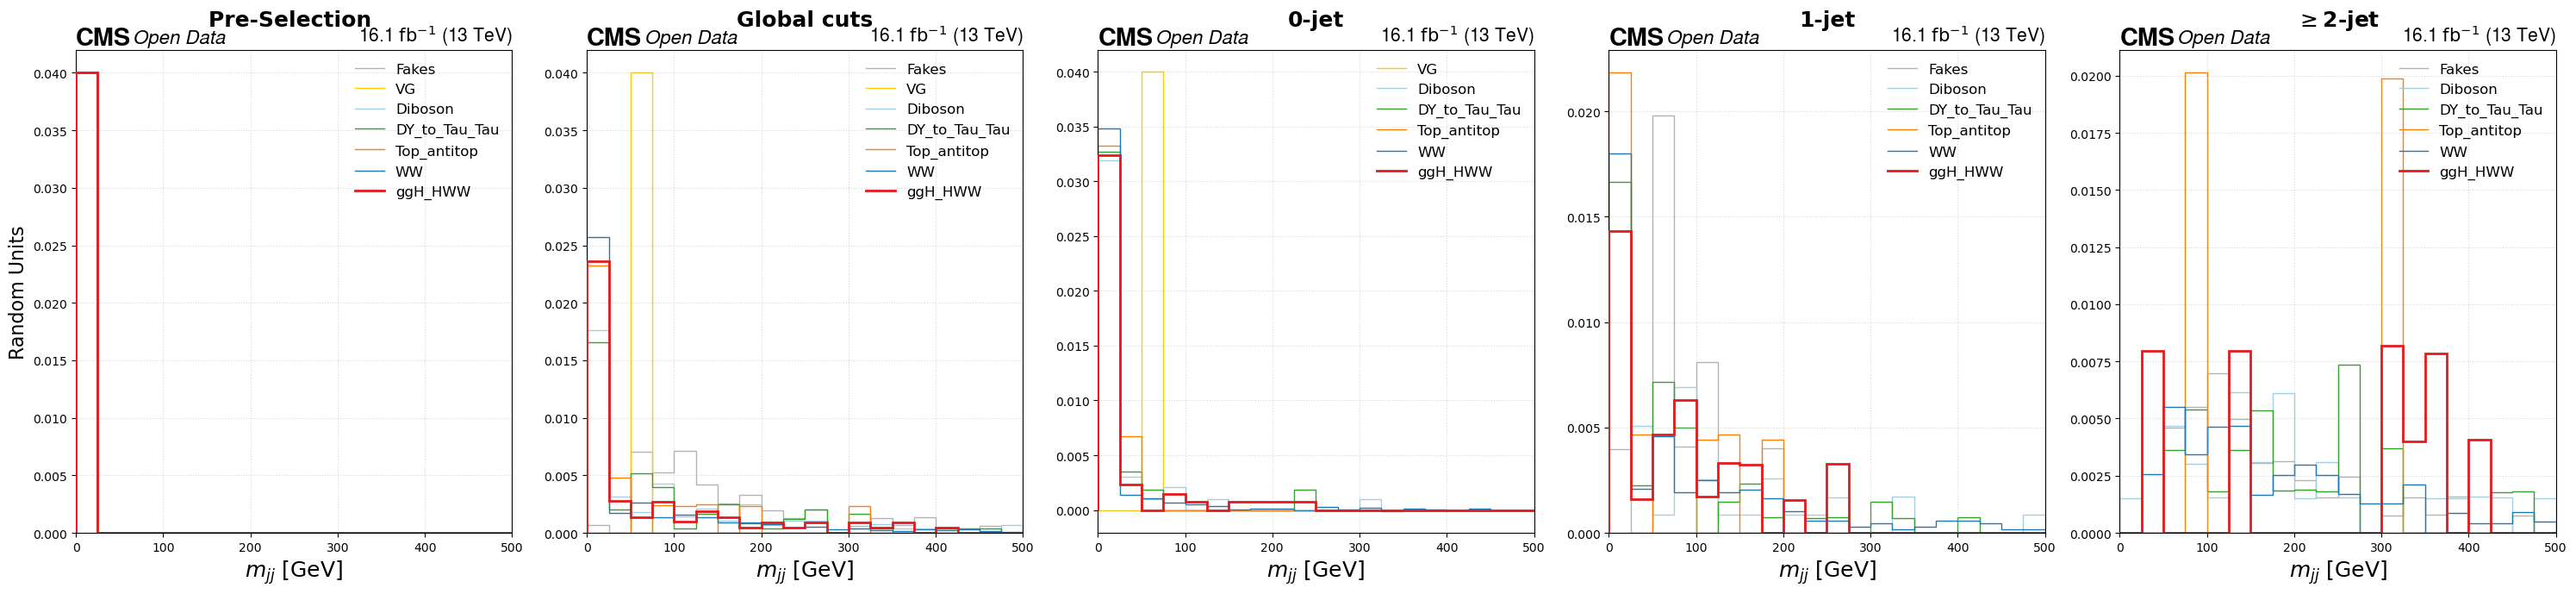

Processing leading_pt...
Saved plot: leading_pt_stages.png


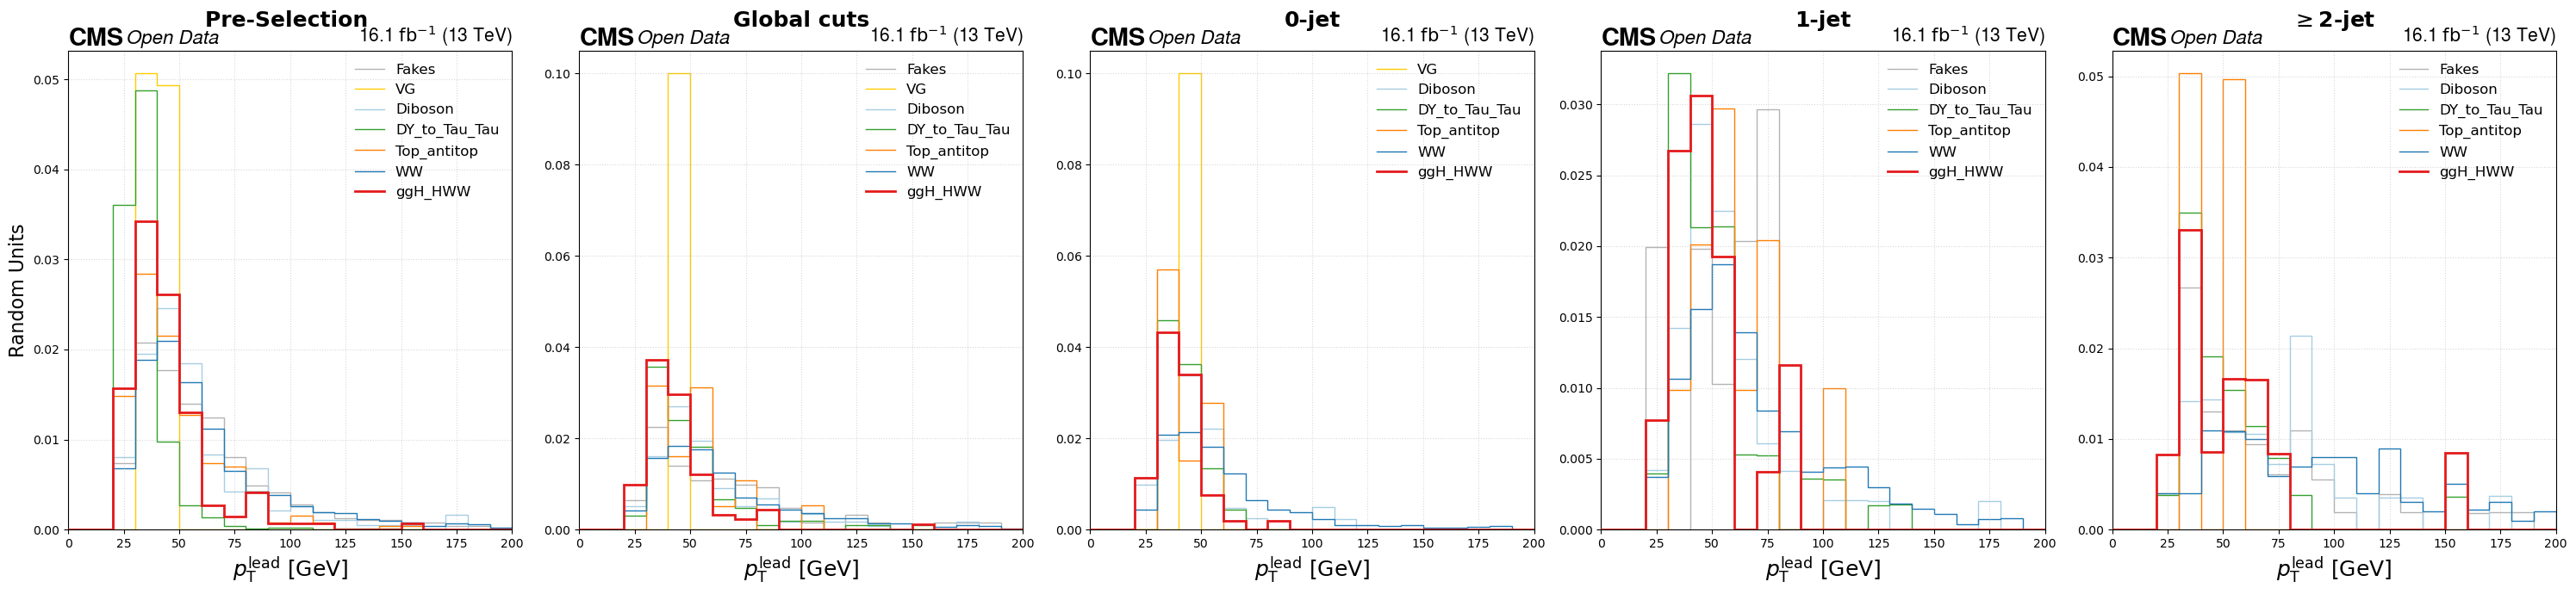

Processing subleading_pt...
Saved plot: subleading_pt_stages.png


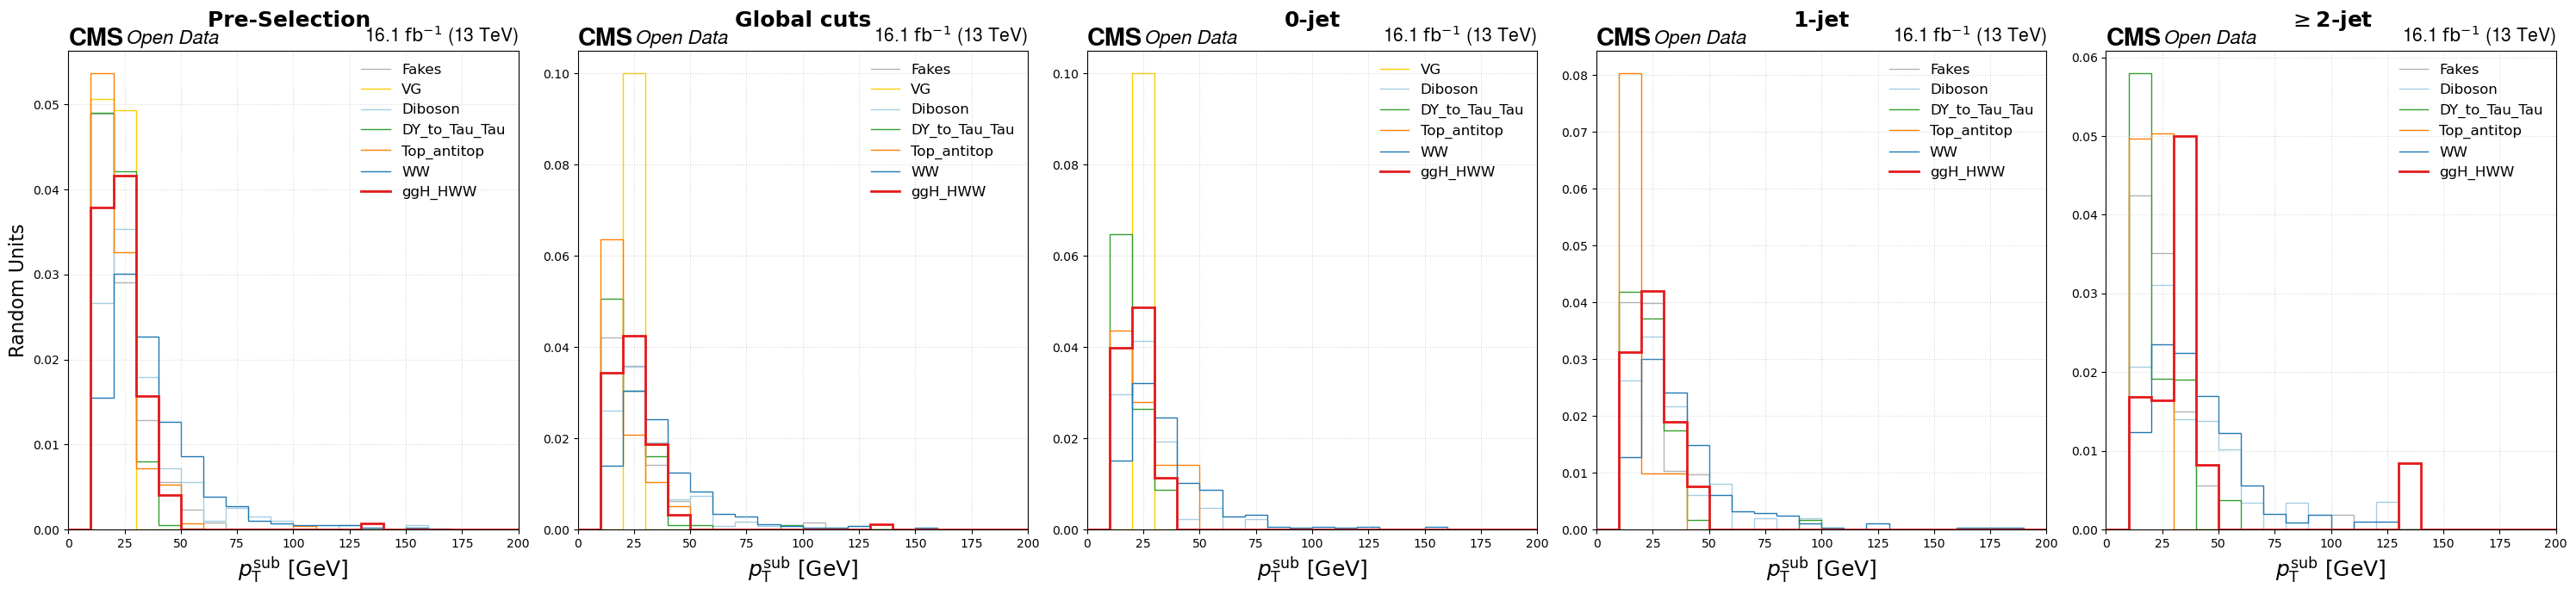

In [10]:
kinematics_dir = PLOTS_DIR / "Kinematics"
kinematics_dir.mkdir(parents=True, exist_ok=True)
print(f"Saving superimposed plots to: {kinematics_dir}")

# print(f"Saving plots to: {PLOTS_DIR / "Kinematics"}")
for var_name, var_props in variables_to_plots.items():
    print(f"Processing {var_name}...")
    fig = create_superimposed_plots(var_name, var_props, hist_data_final, output_dir=PLOTS_DIR / "Kinematics")
    
    plt.show()
    plt.close(fig)

# create_superimposed_plots(var_name, var_props, hist_data_final, output_dir=kinematics_dir)

## Stacked plots


GENERATING STACKED PLOTS...
Plotting mass in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mass.png


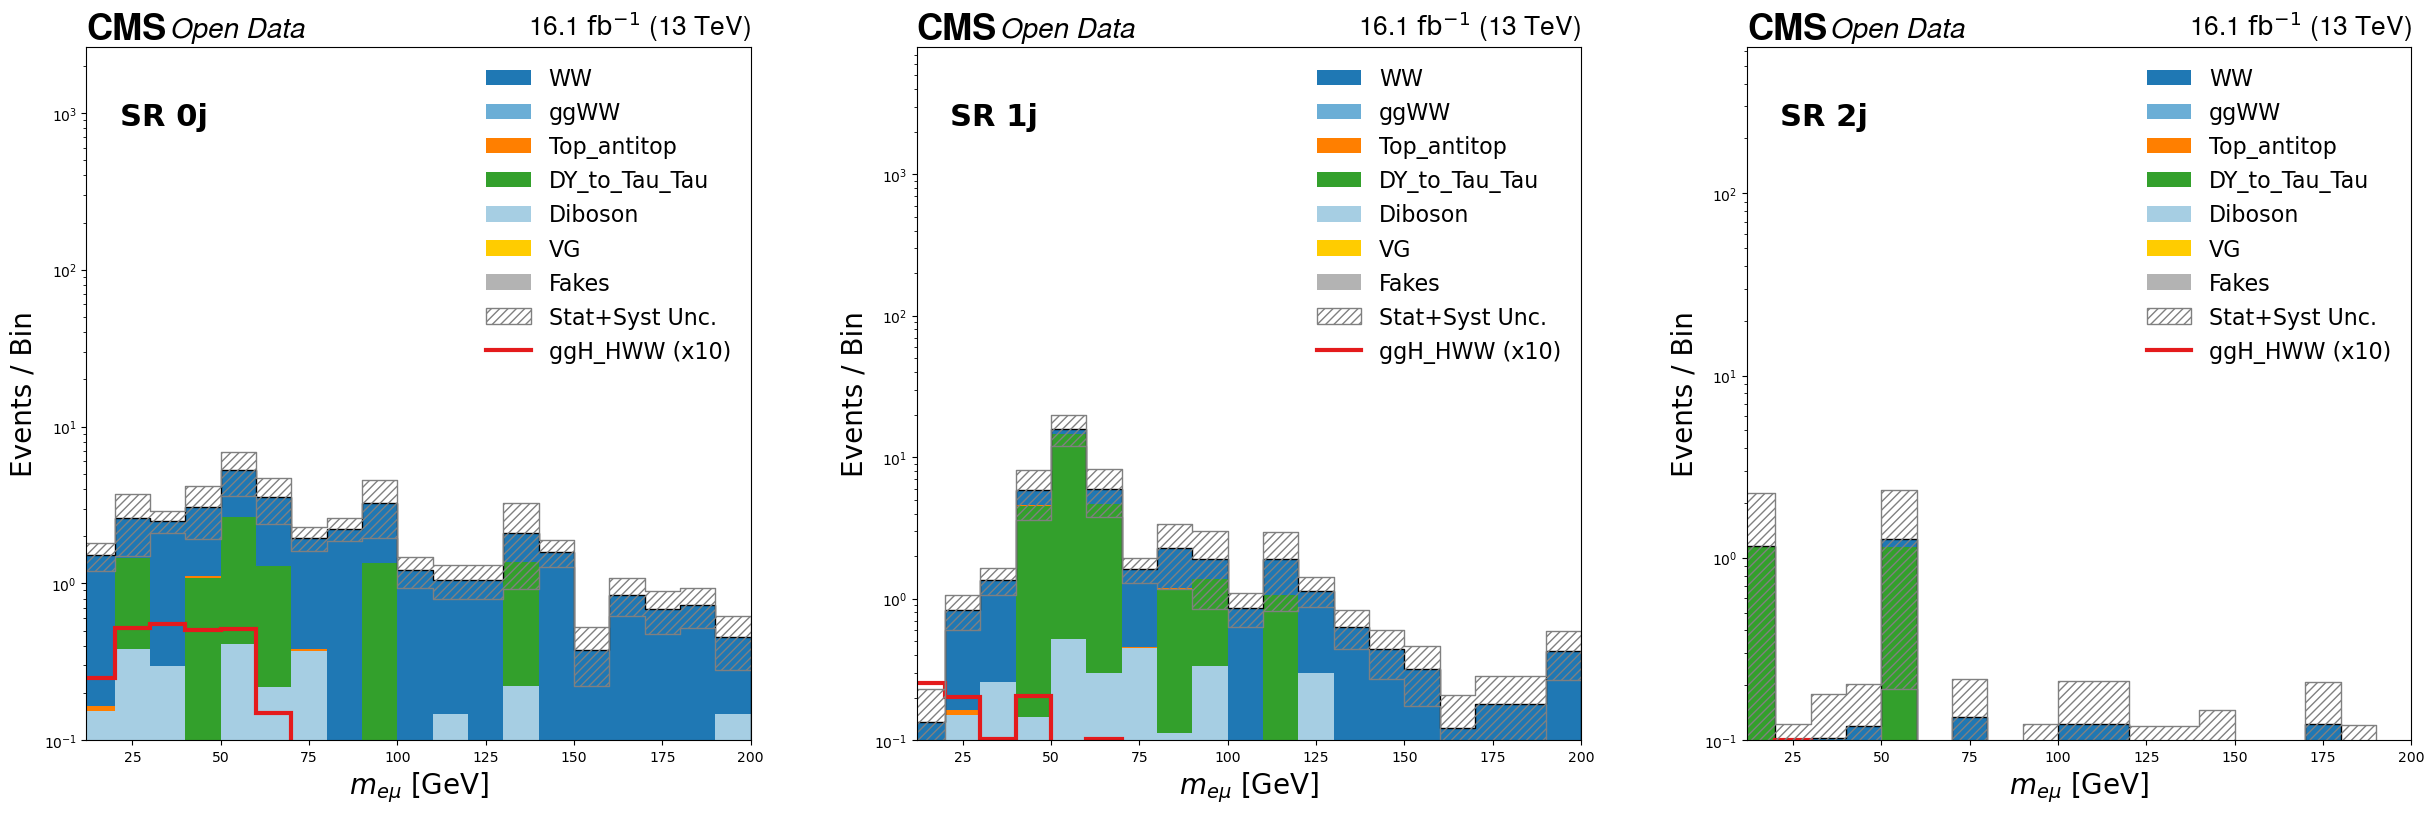

Plotting mass in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mass.png


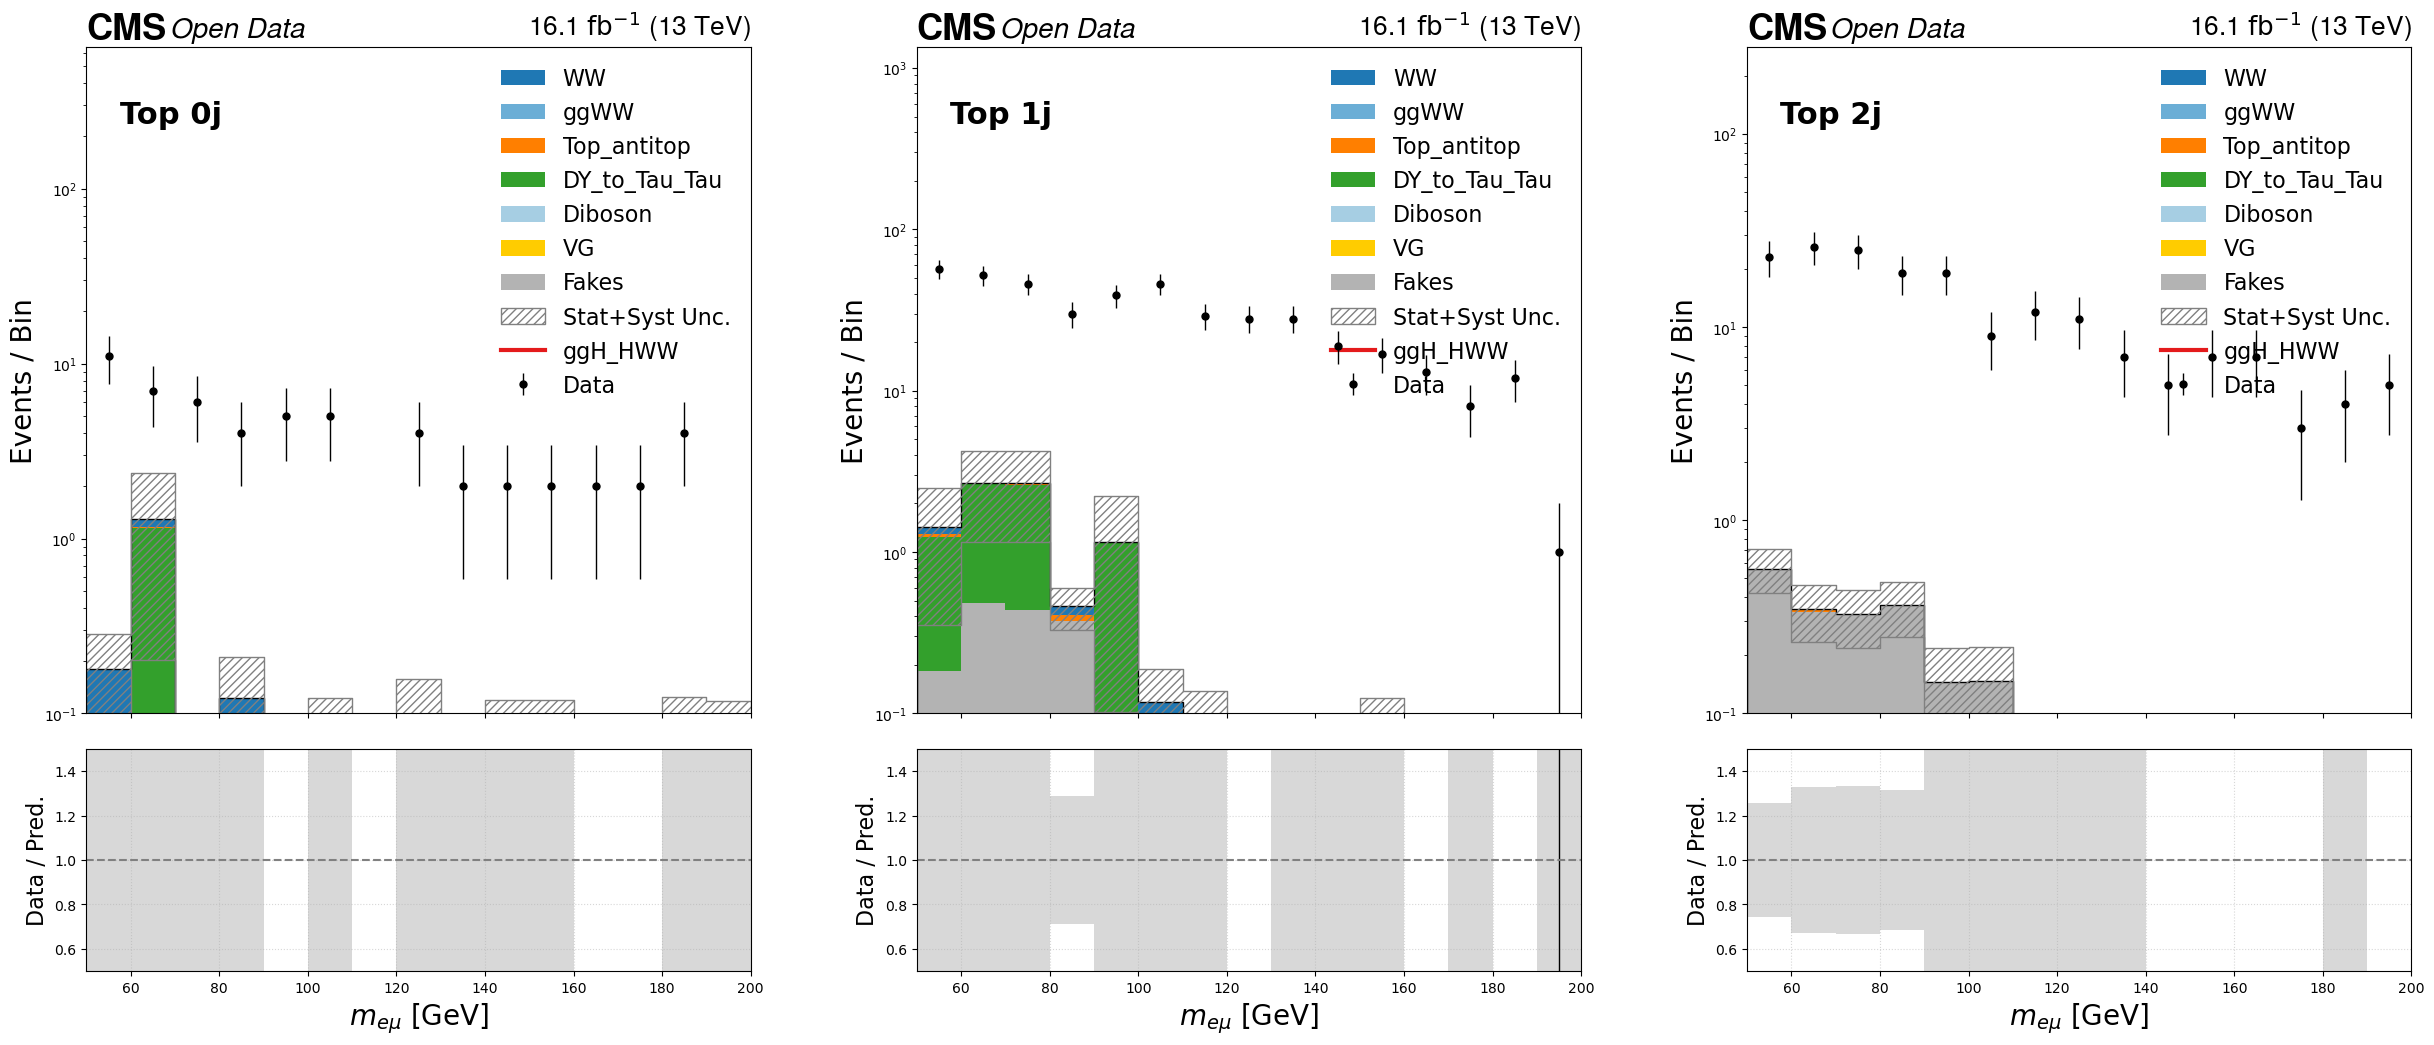

Plotting mass in Control_Region_Tau...


/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis/hww_tools/plotting.py:185: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mass.png


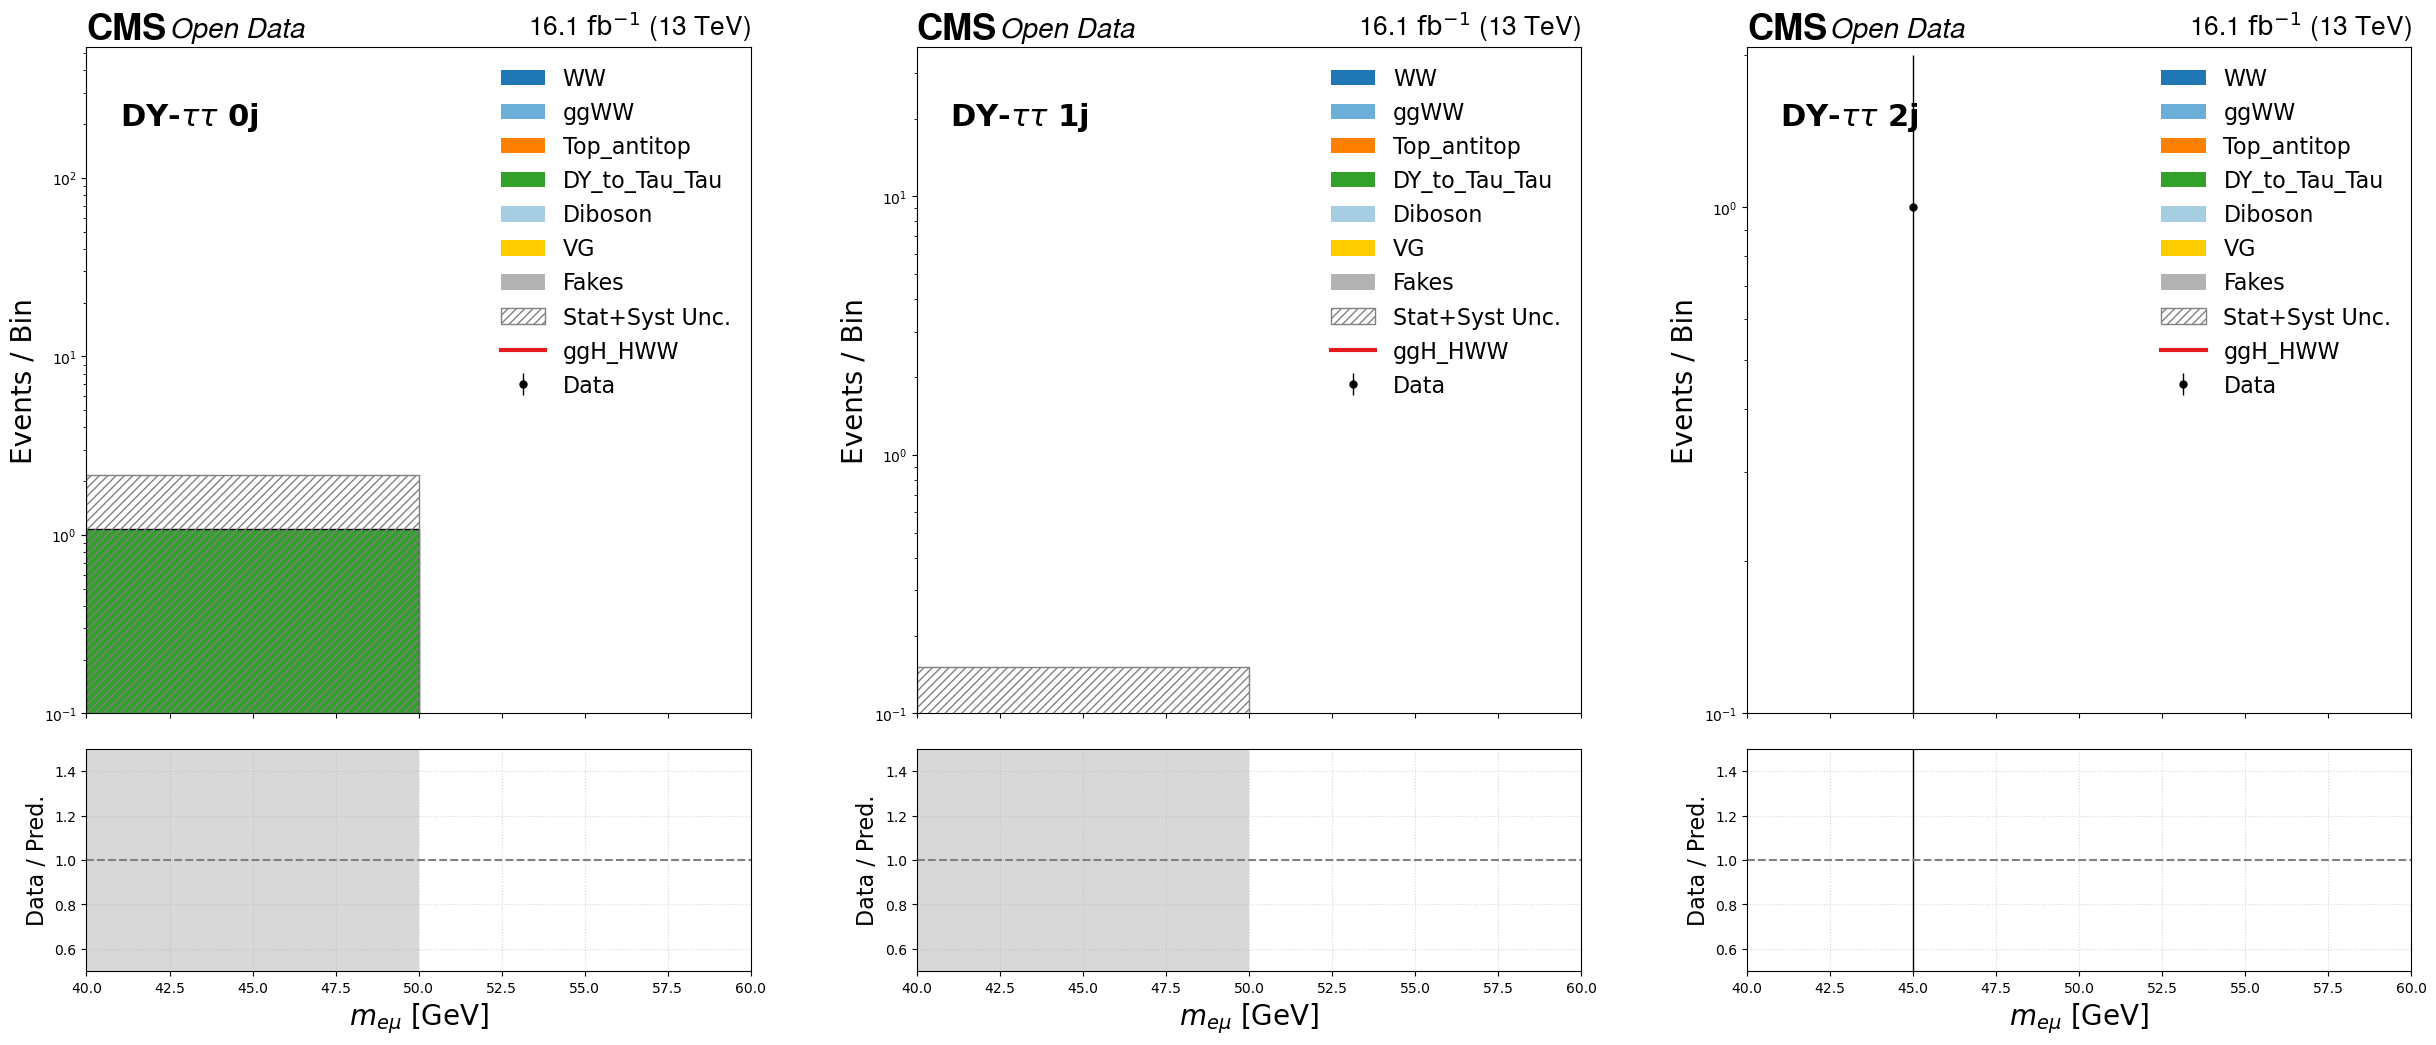

Plotting met in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_met.png


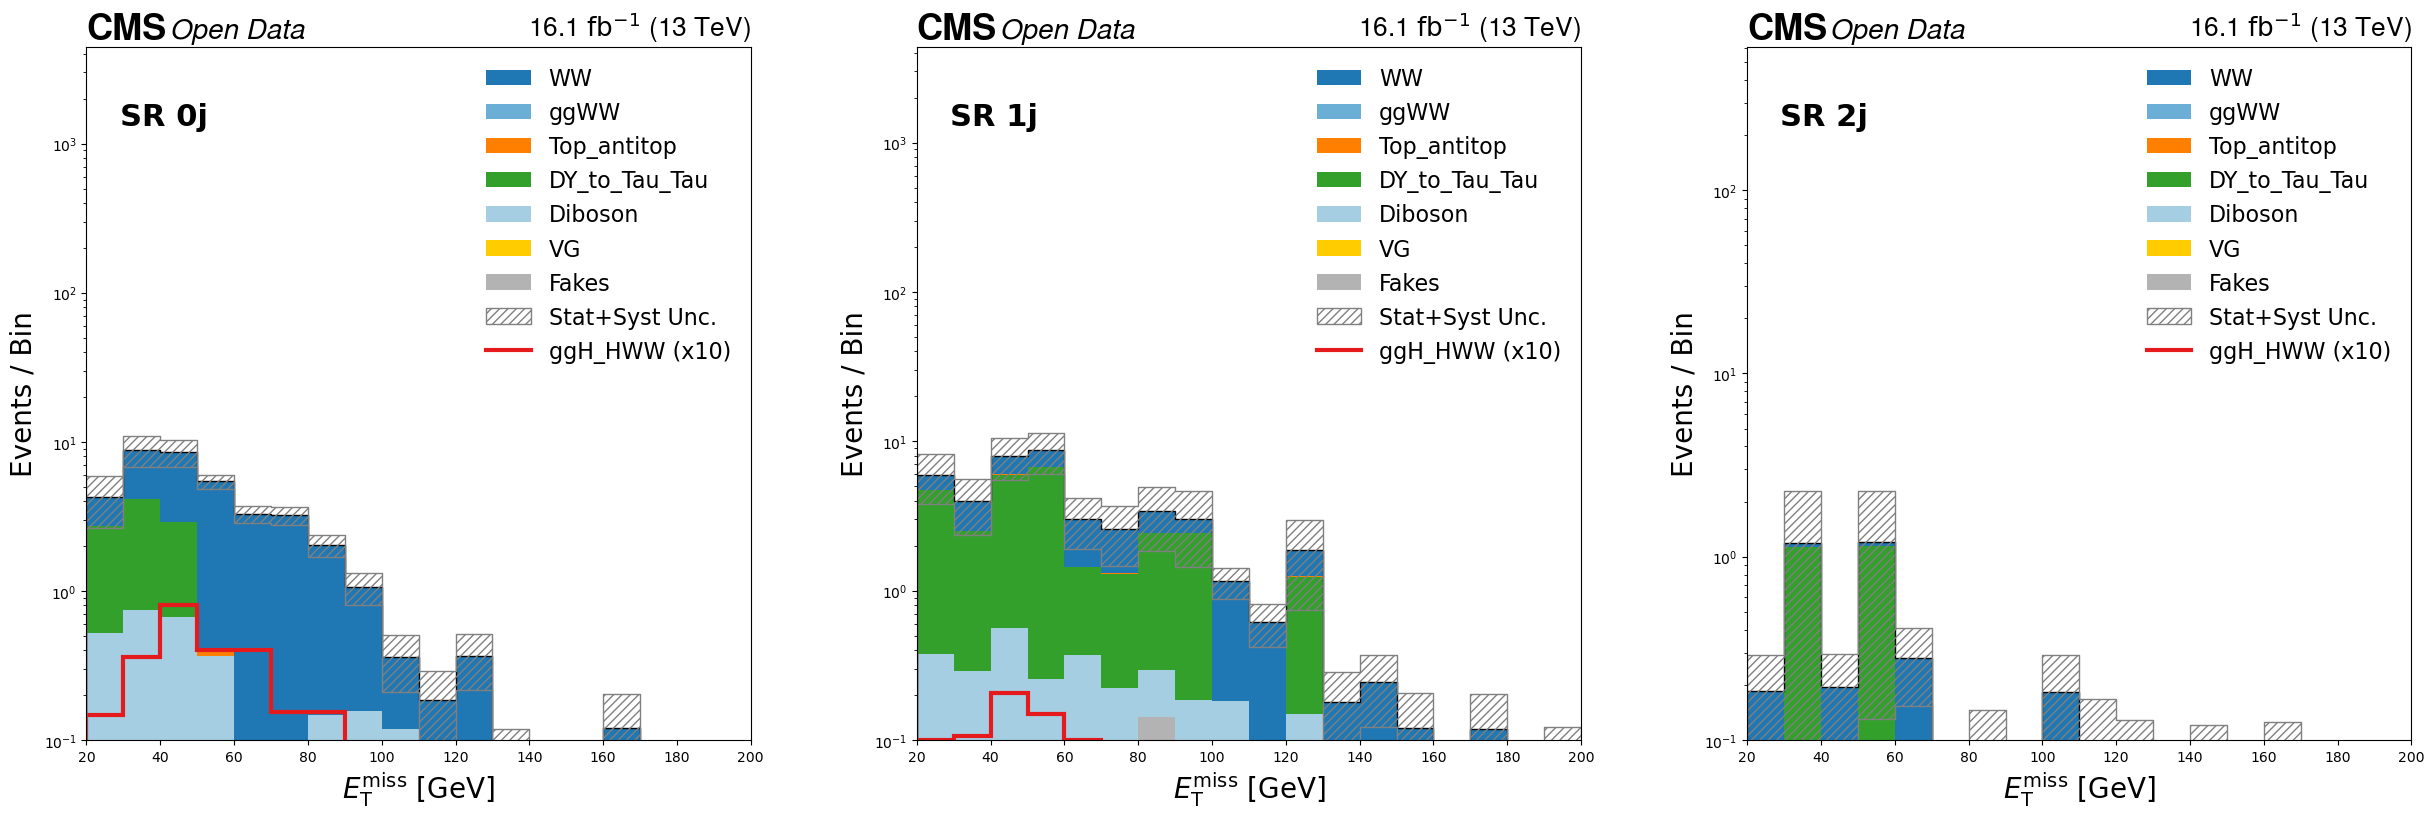

Plotting met in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_met.png


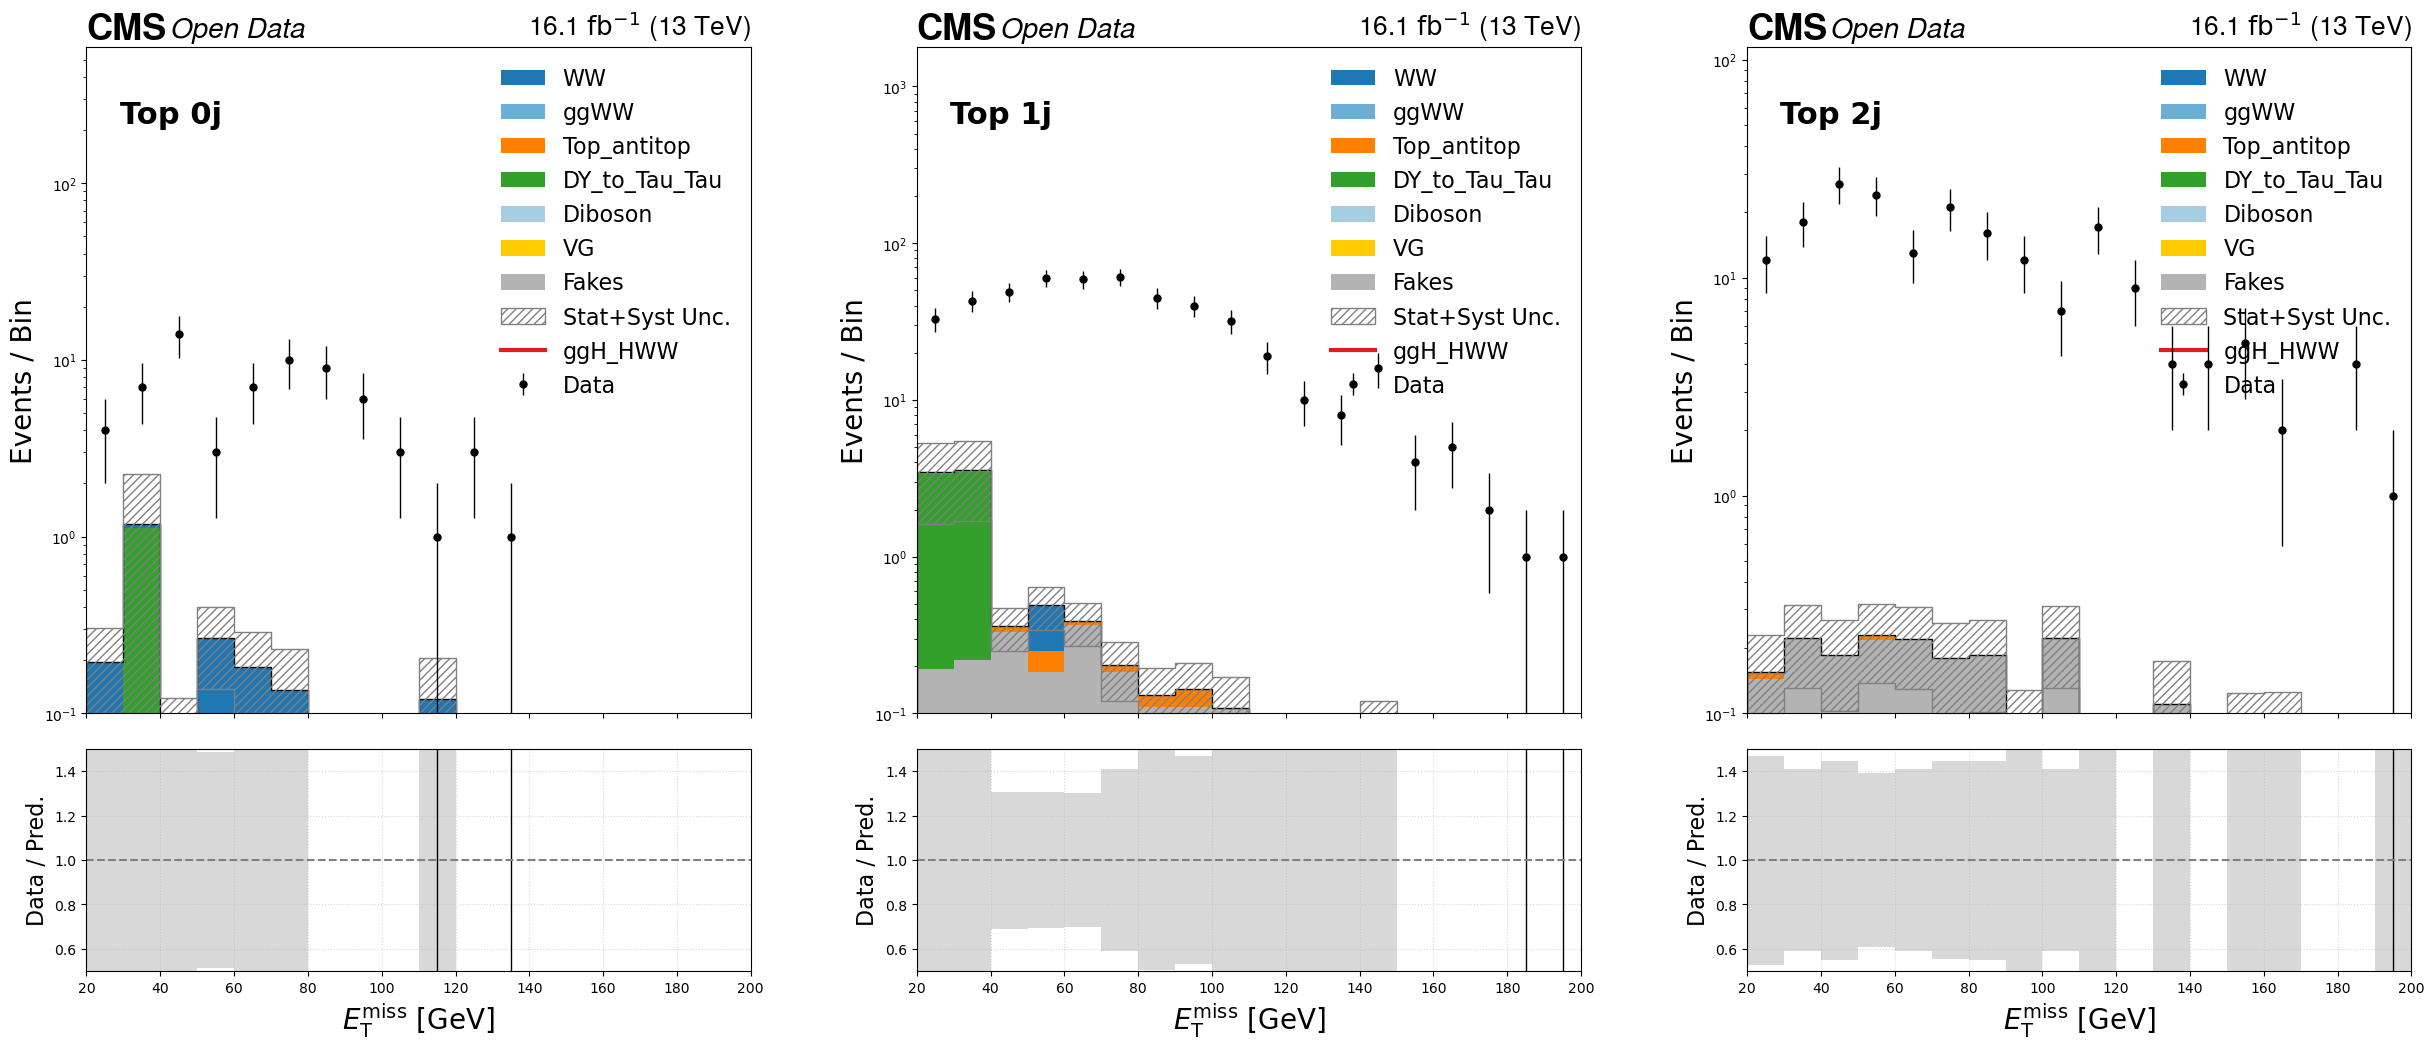

Plotting met in Control_Region_Tau...


/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis/hww_tools/plotting.py:185: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_met.png


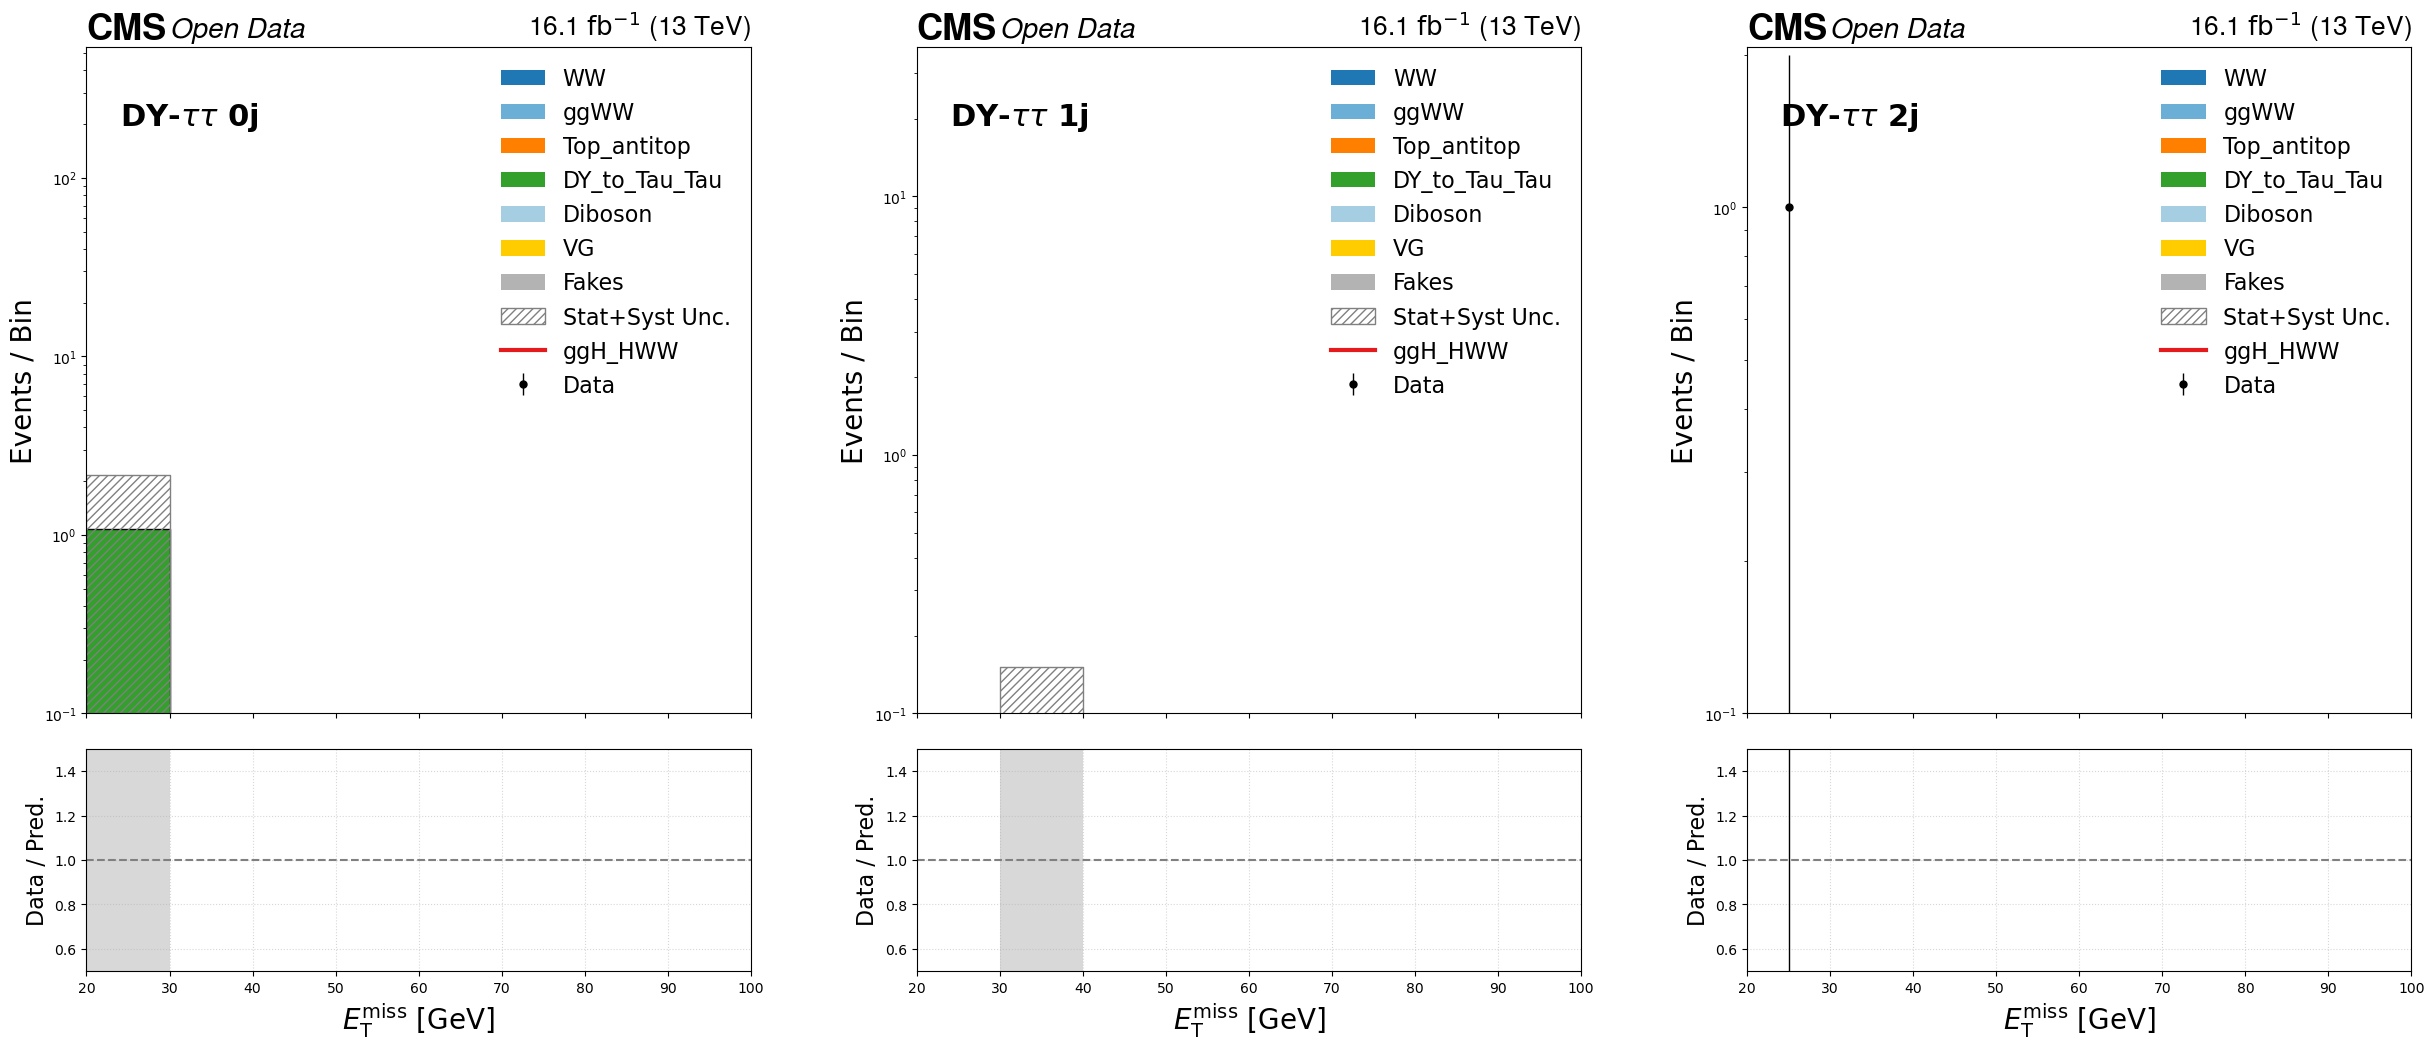

Plotting ptll in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_ptll.png


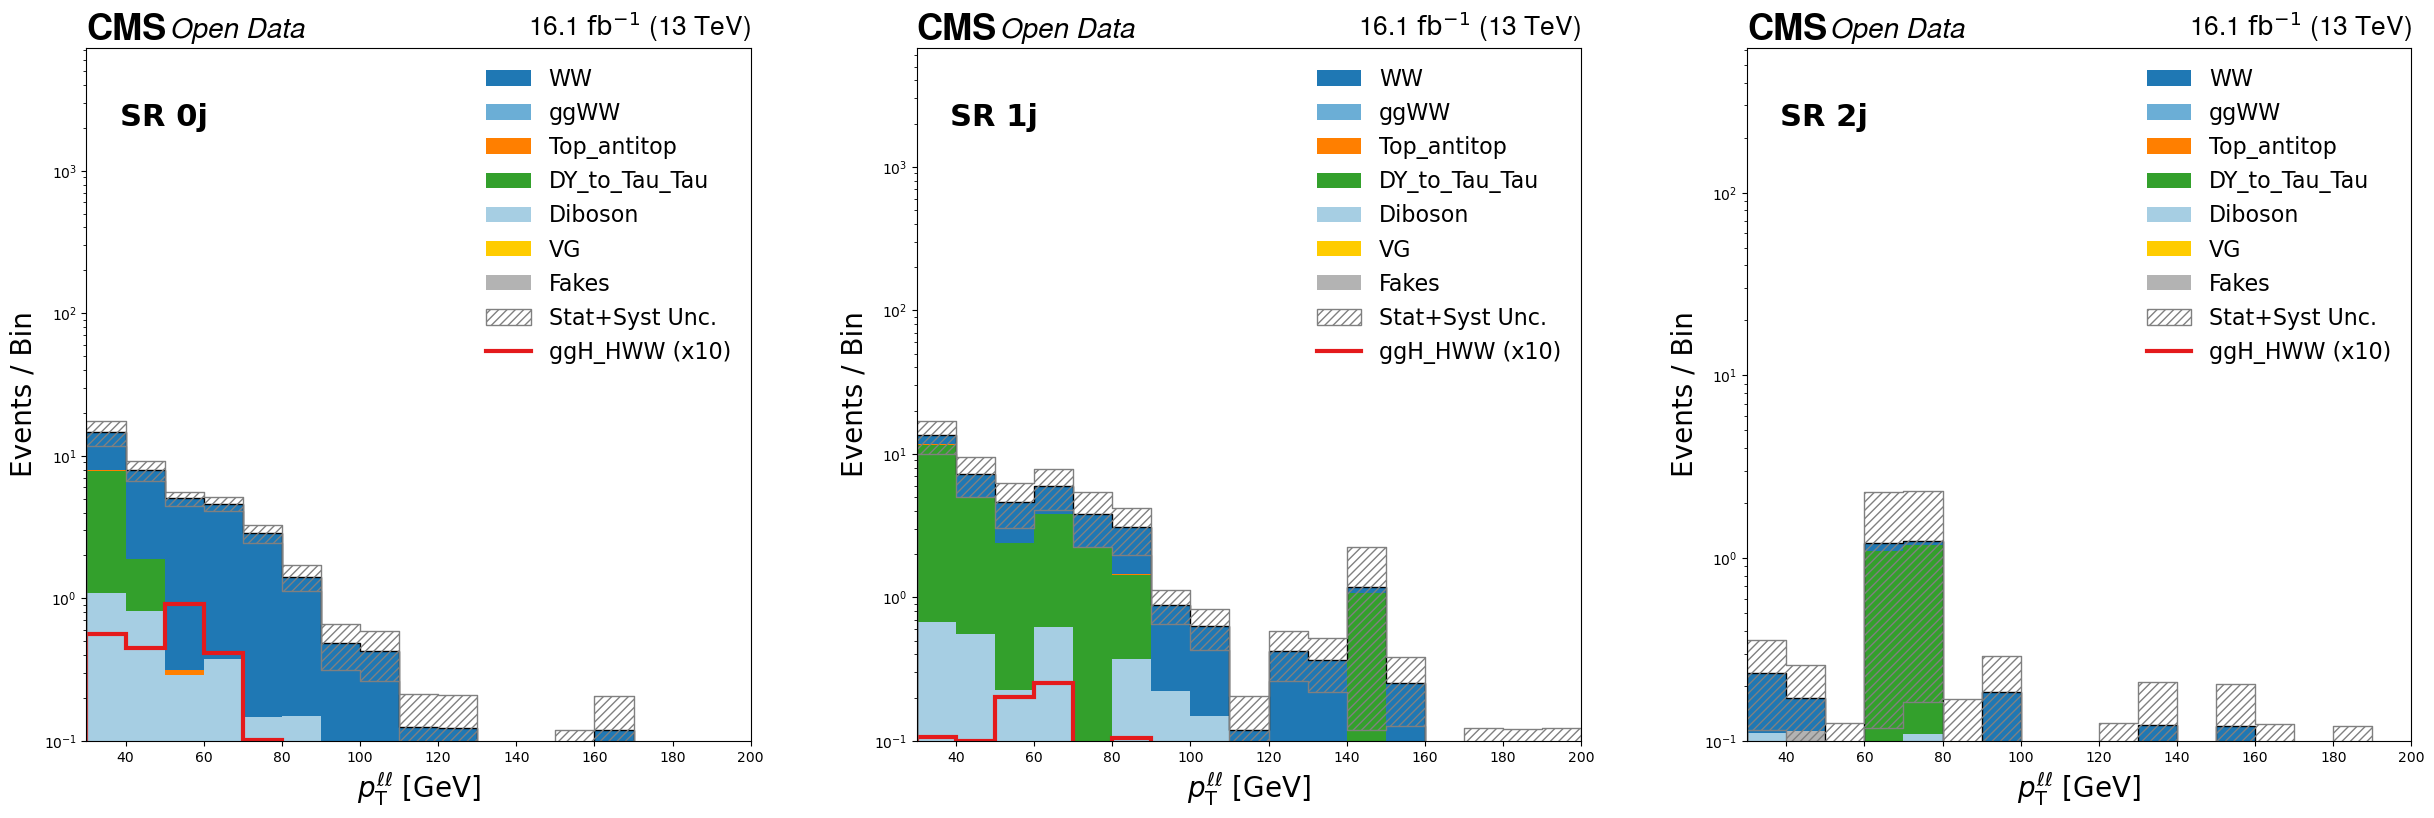

Plotting ptll in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_ptll.png


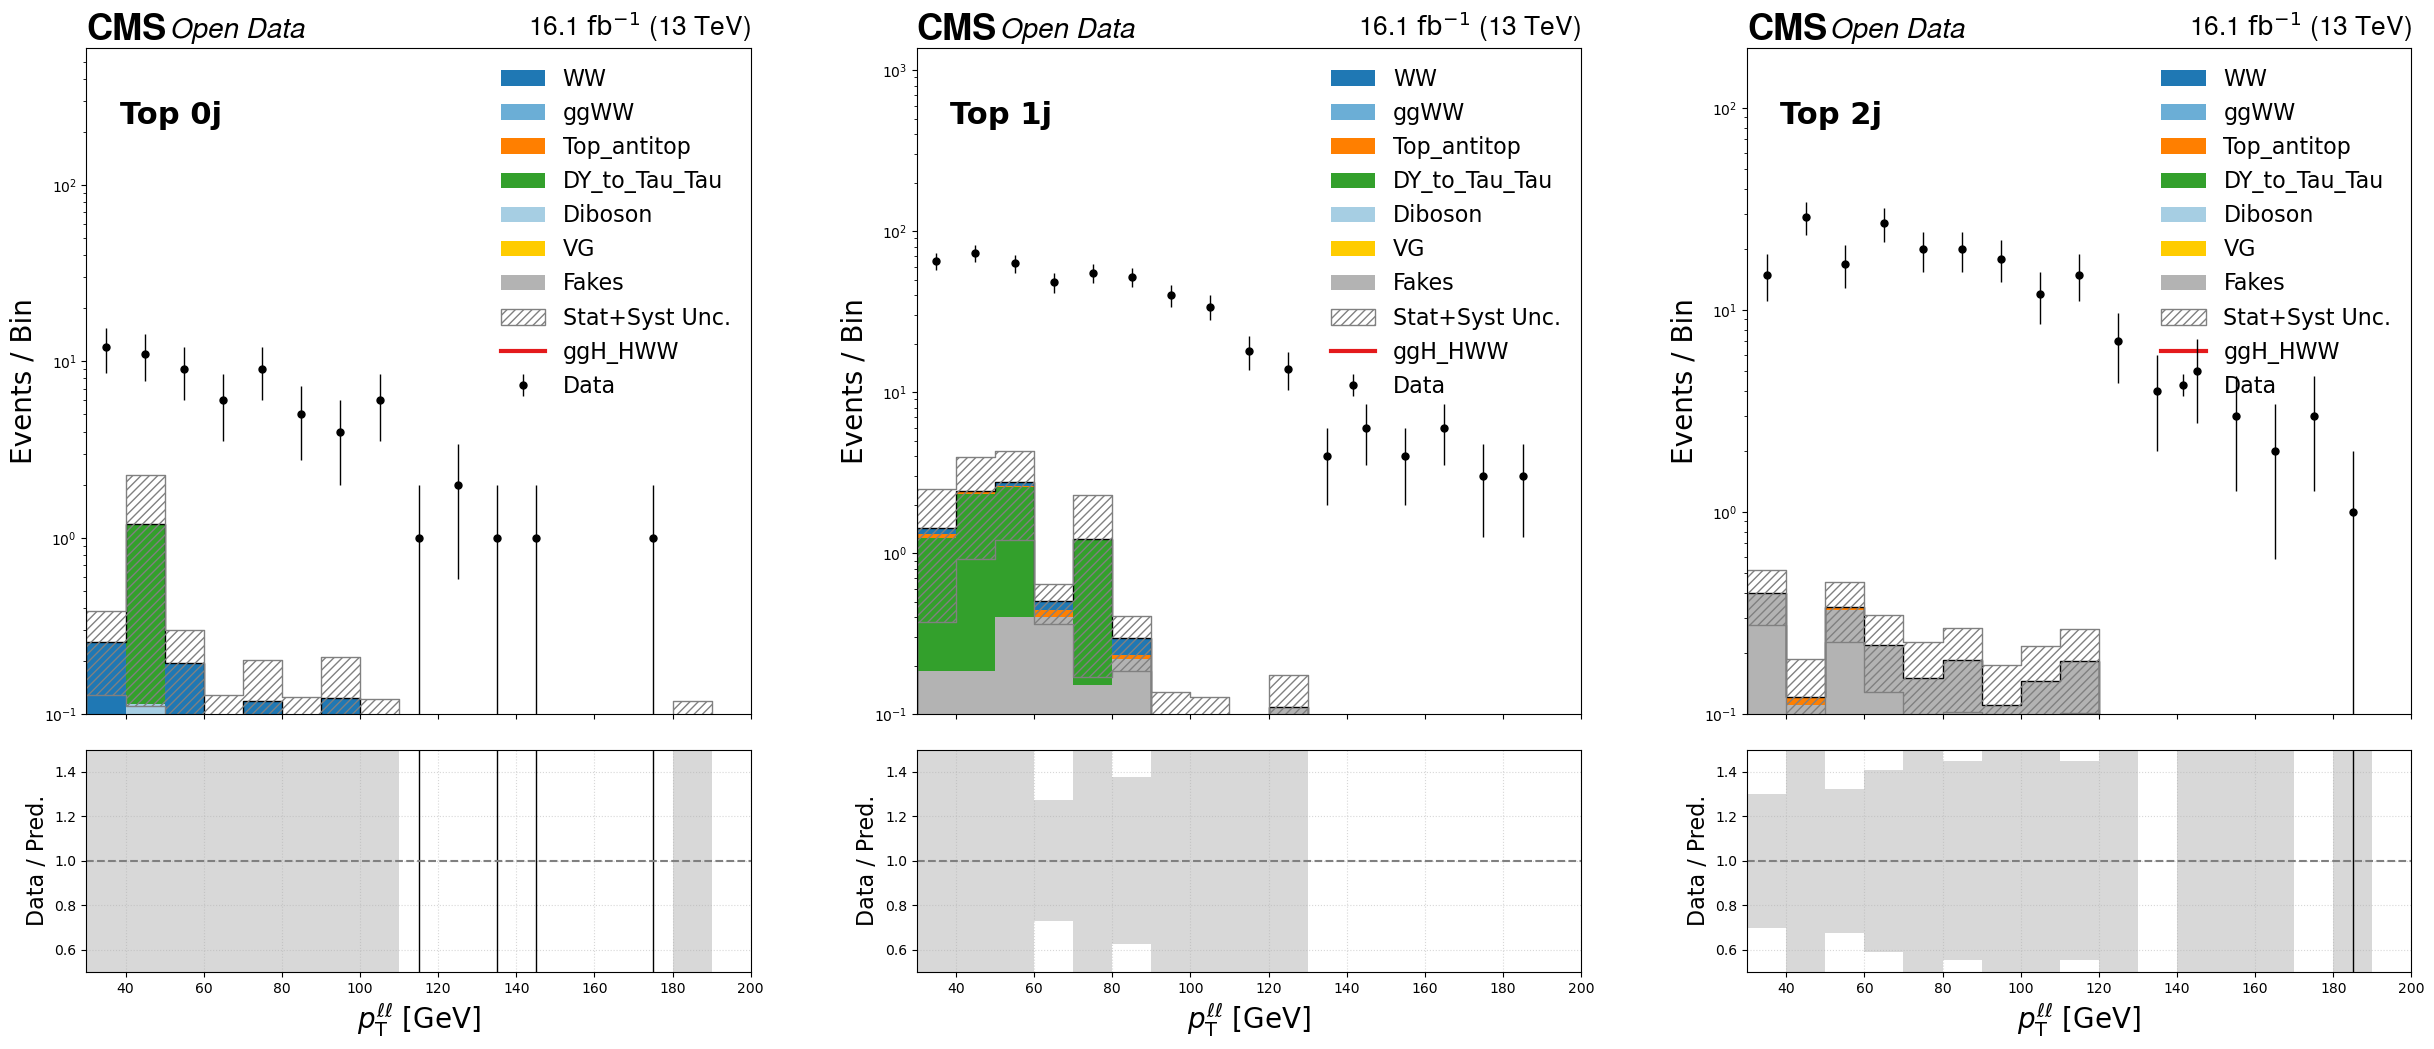

Plotting ptll in Control_Region_Tau...


/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis/hww_tools/plotting.py:185: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_ptll.png


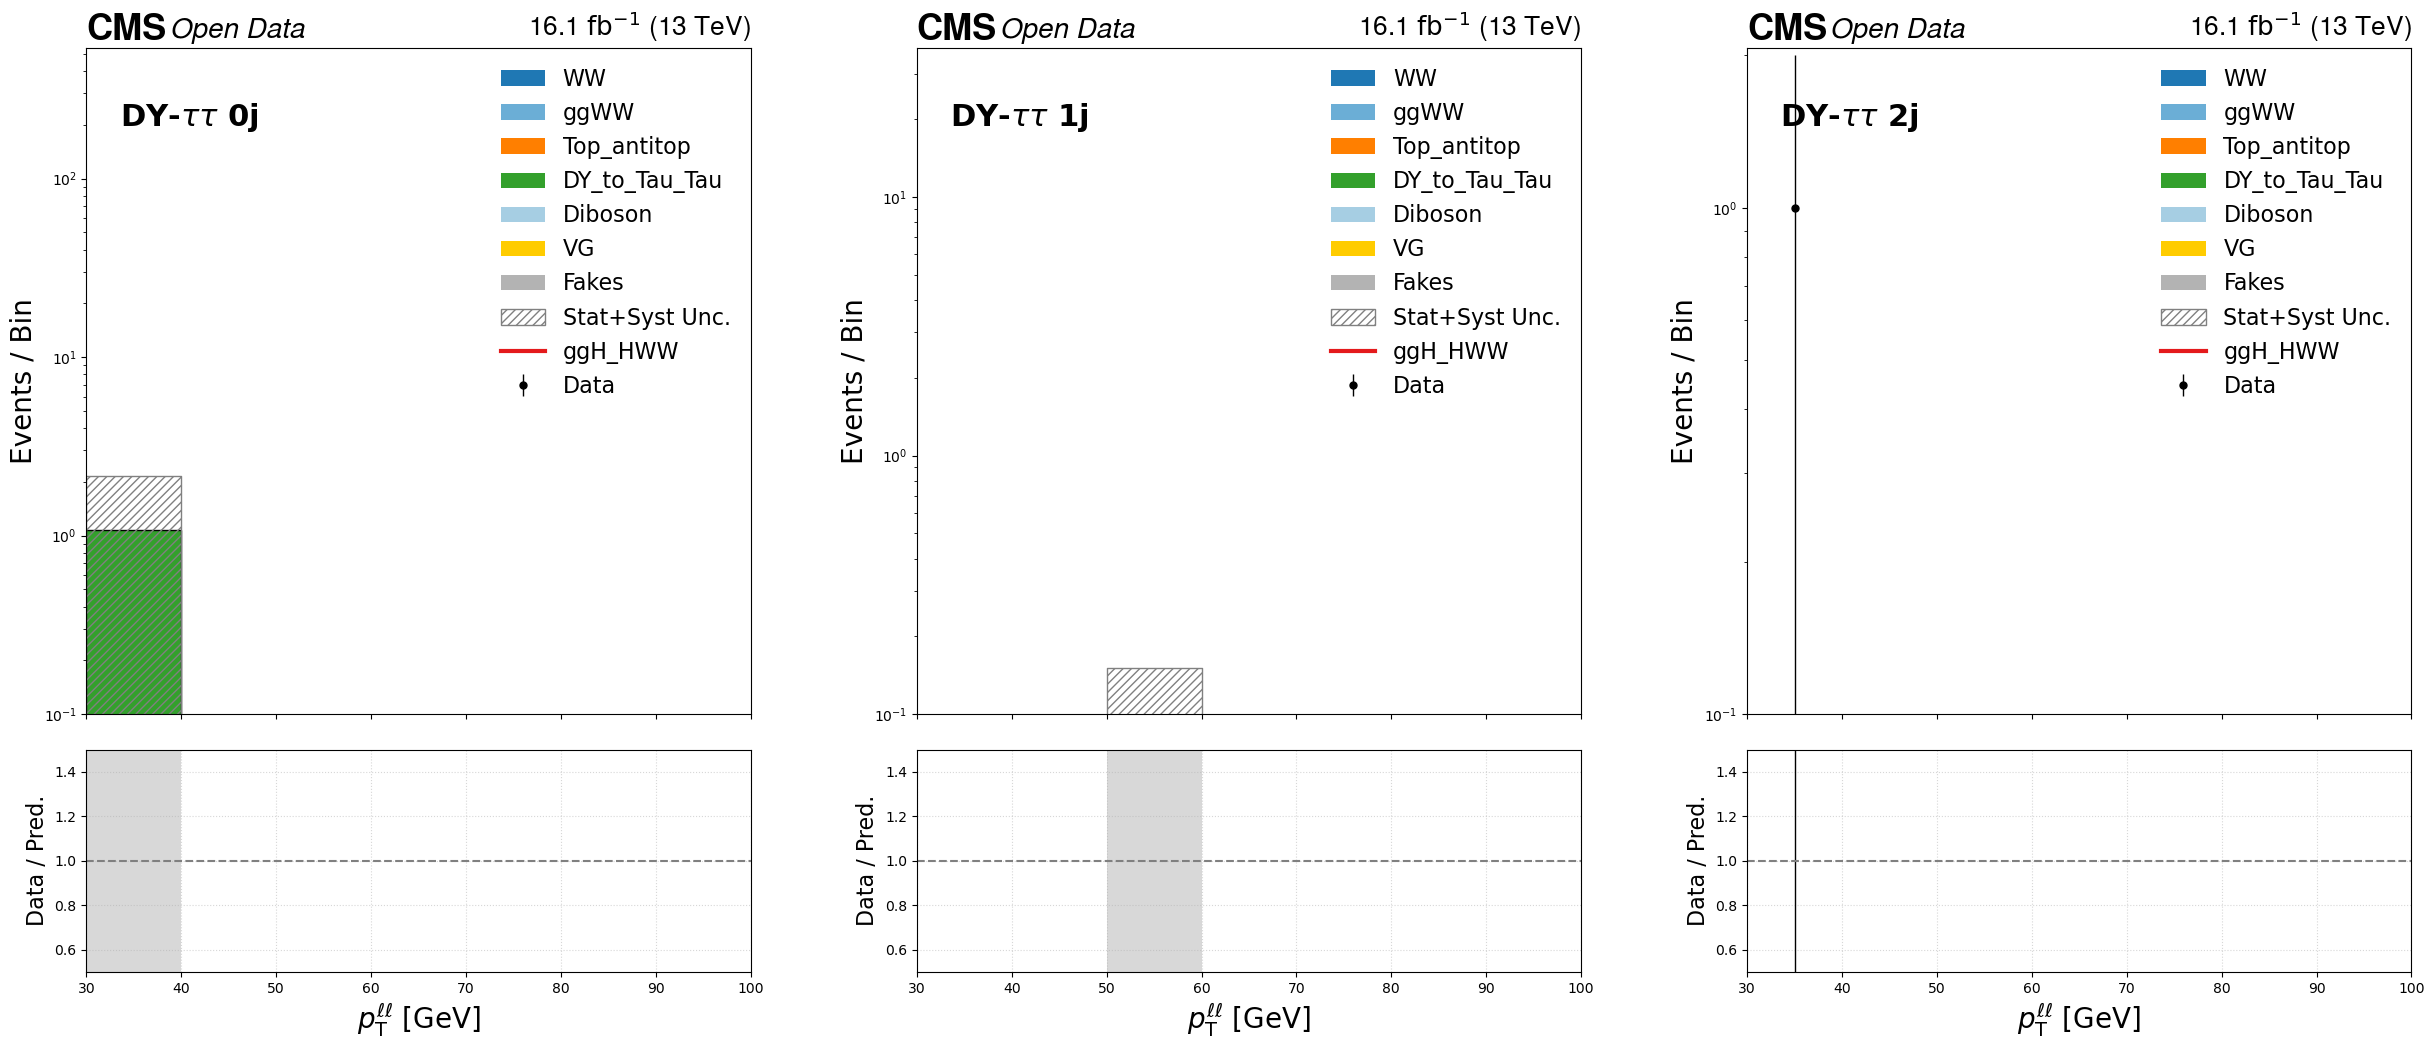

Plotting dphi in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_dphi.png


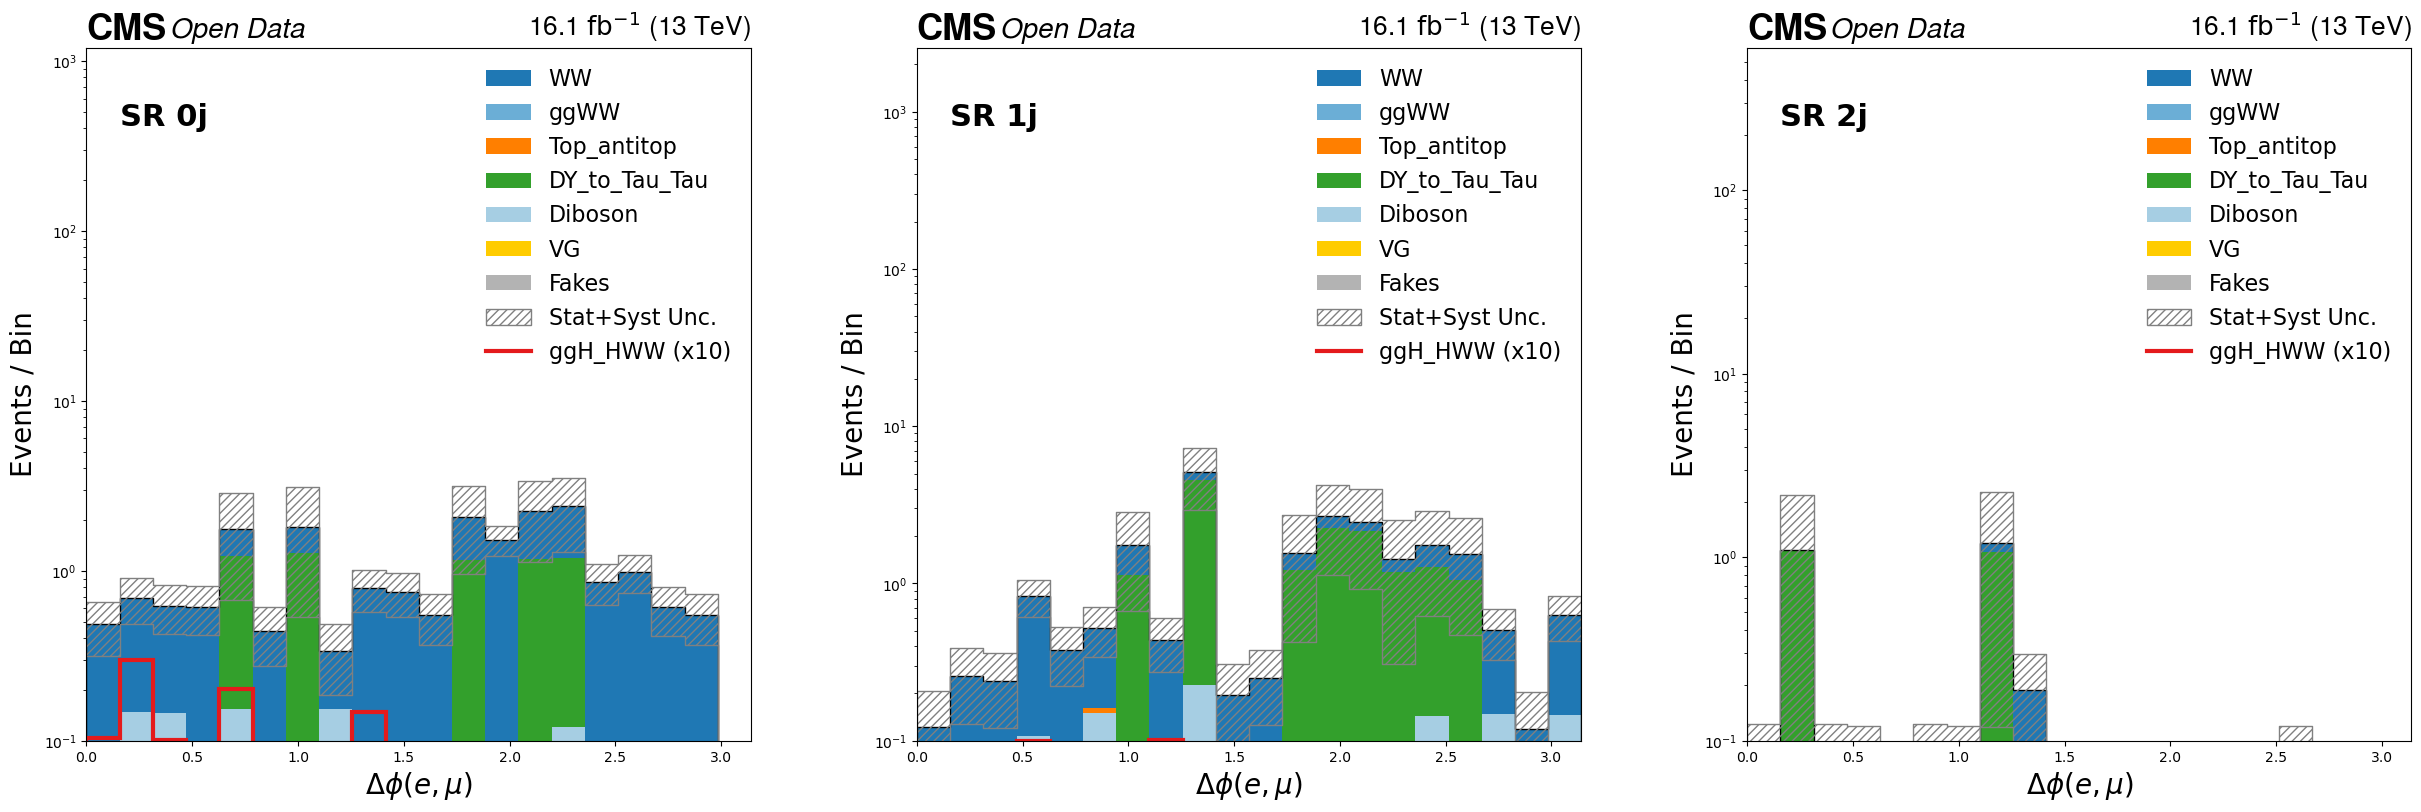

Plotting dphi in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_dphi.png


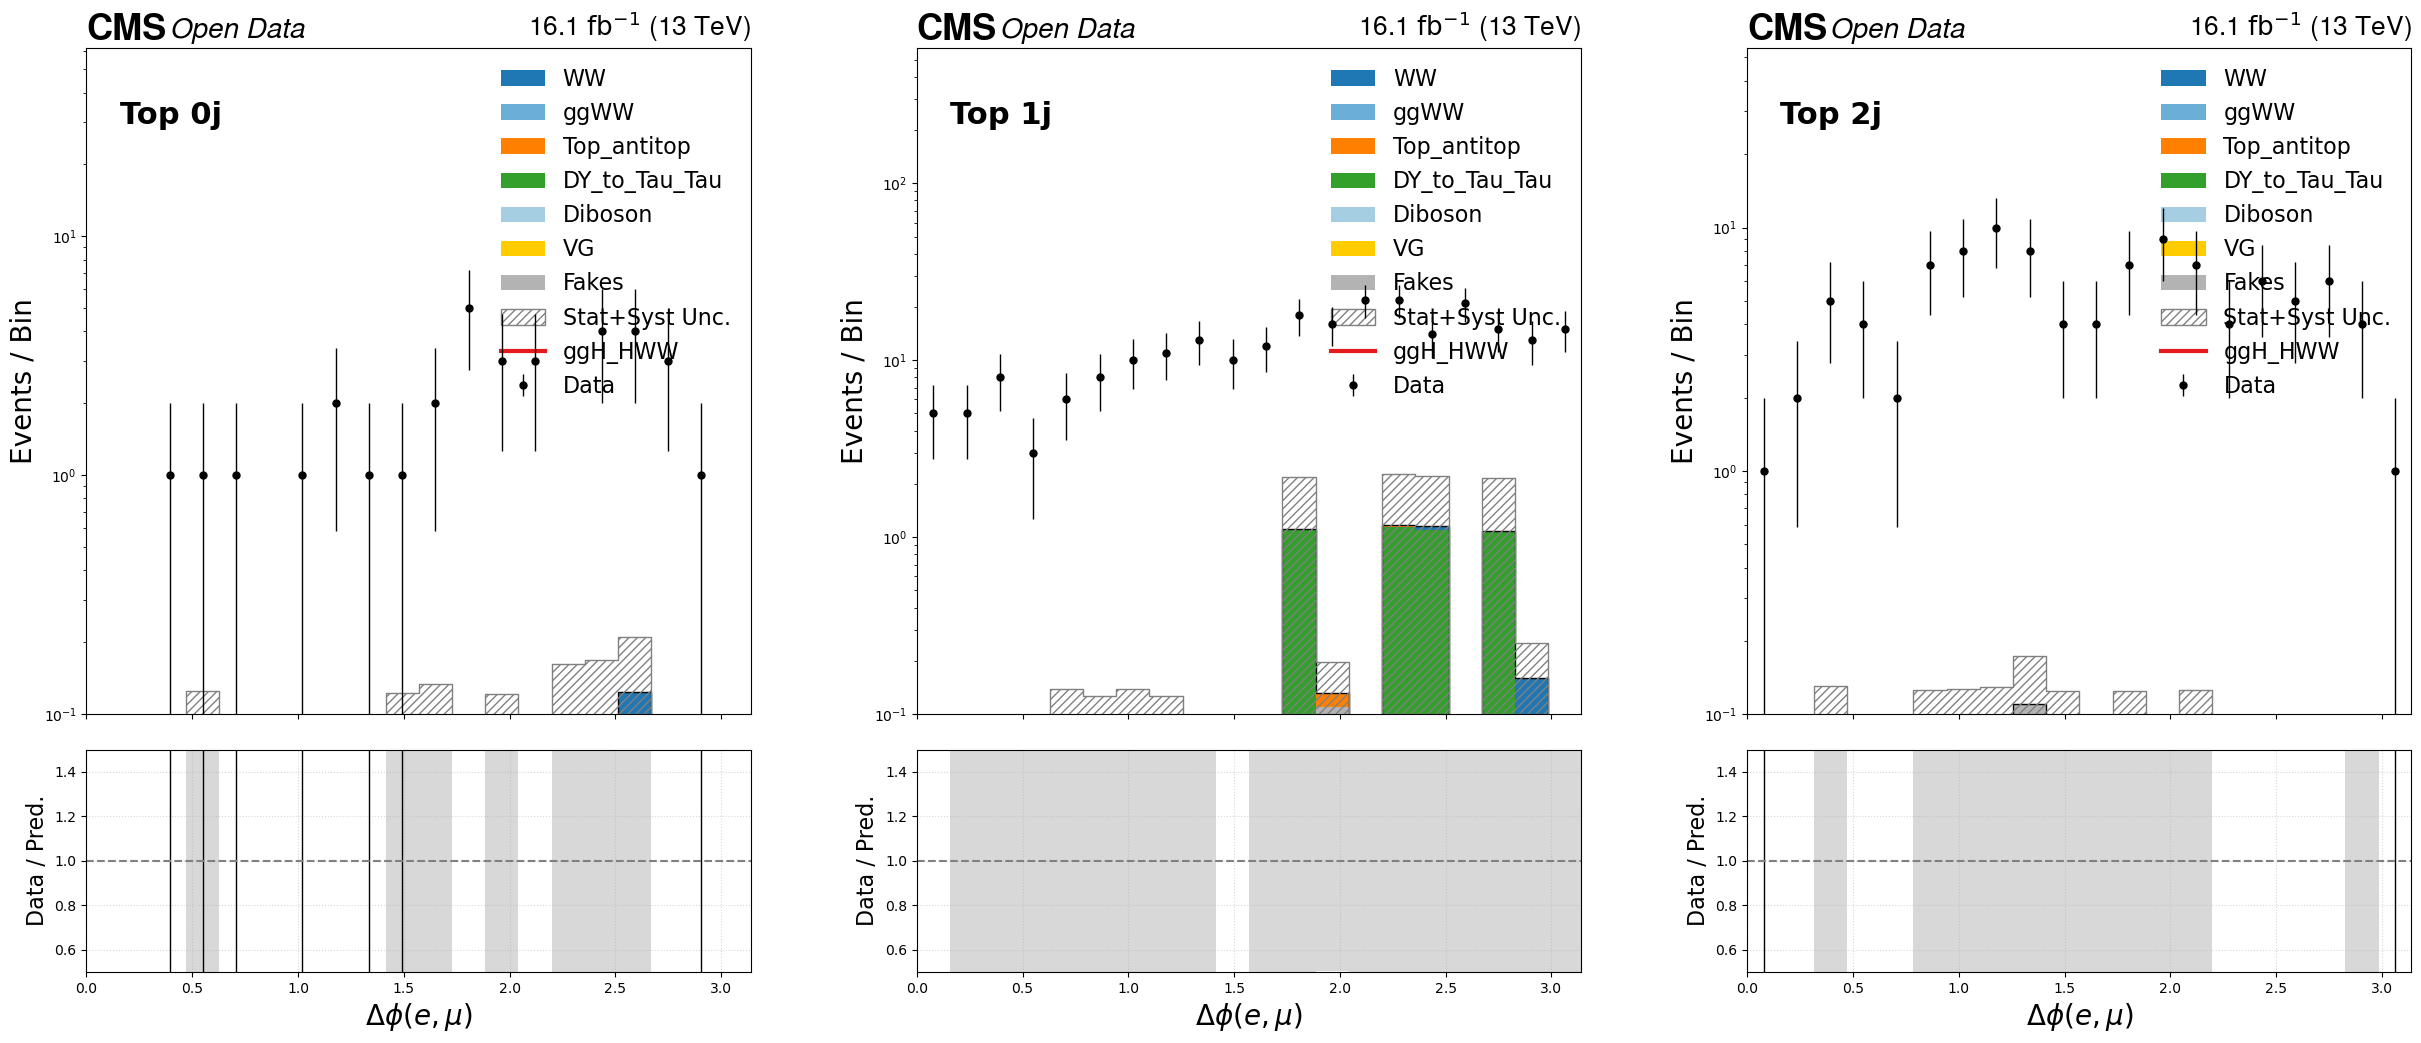

Plotting dphi in Control_Region_Tau...


/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis/hww_tools/plotting.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_main.set_yscale('log')
/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis/hww_tools/plotting.py:185: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)
/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis/hww_tools/plotting.py:185: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_dphi.png


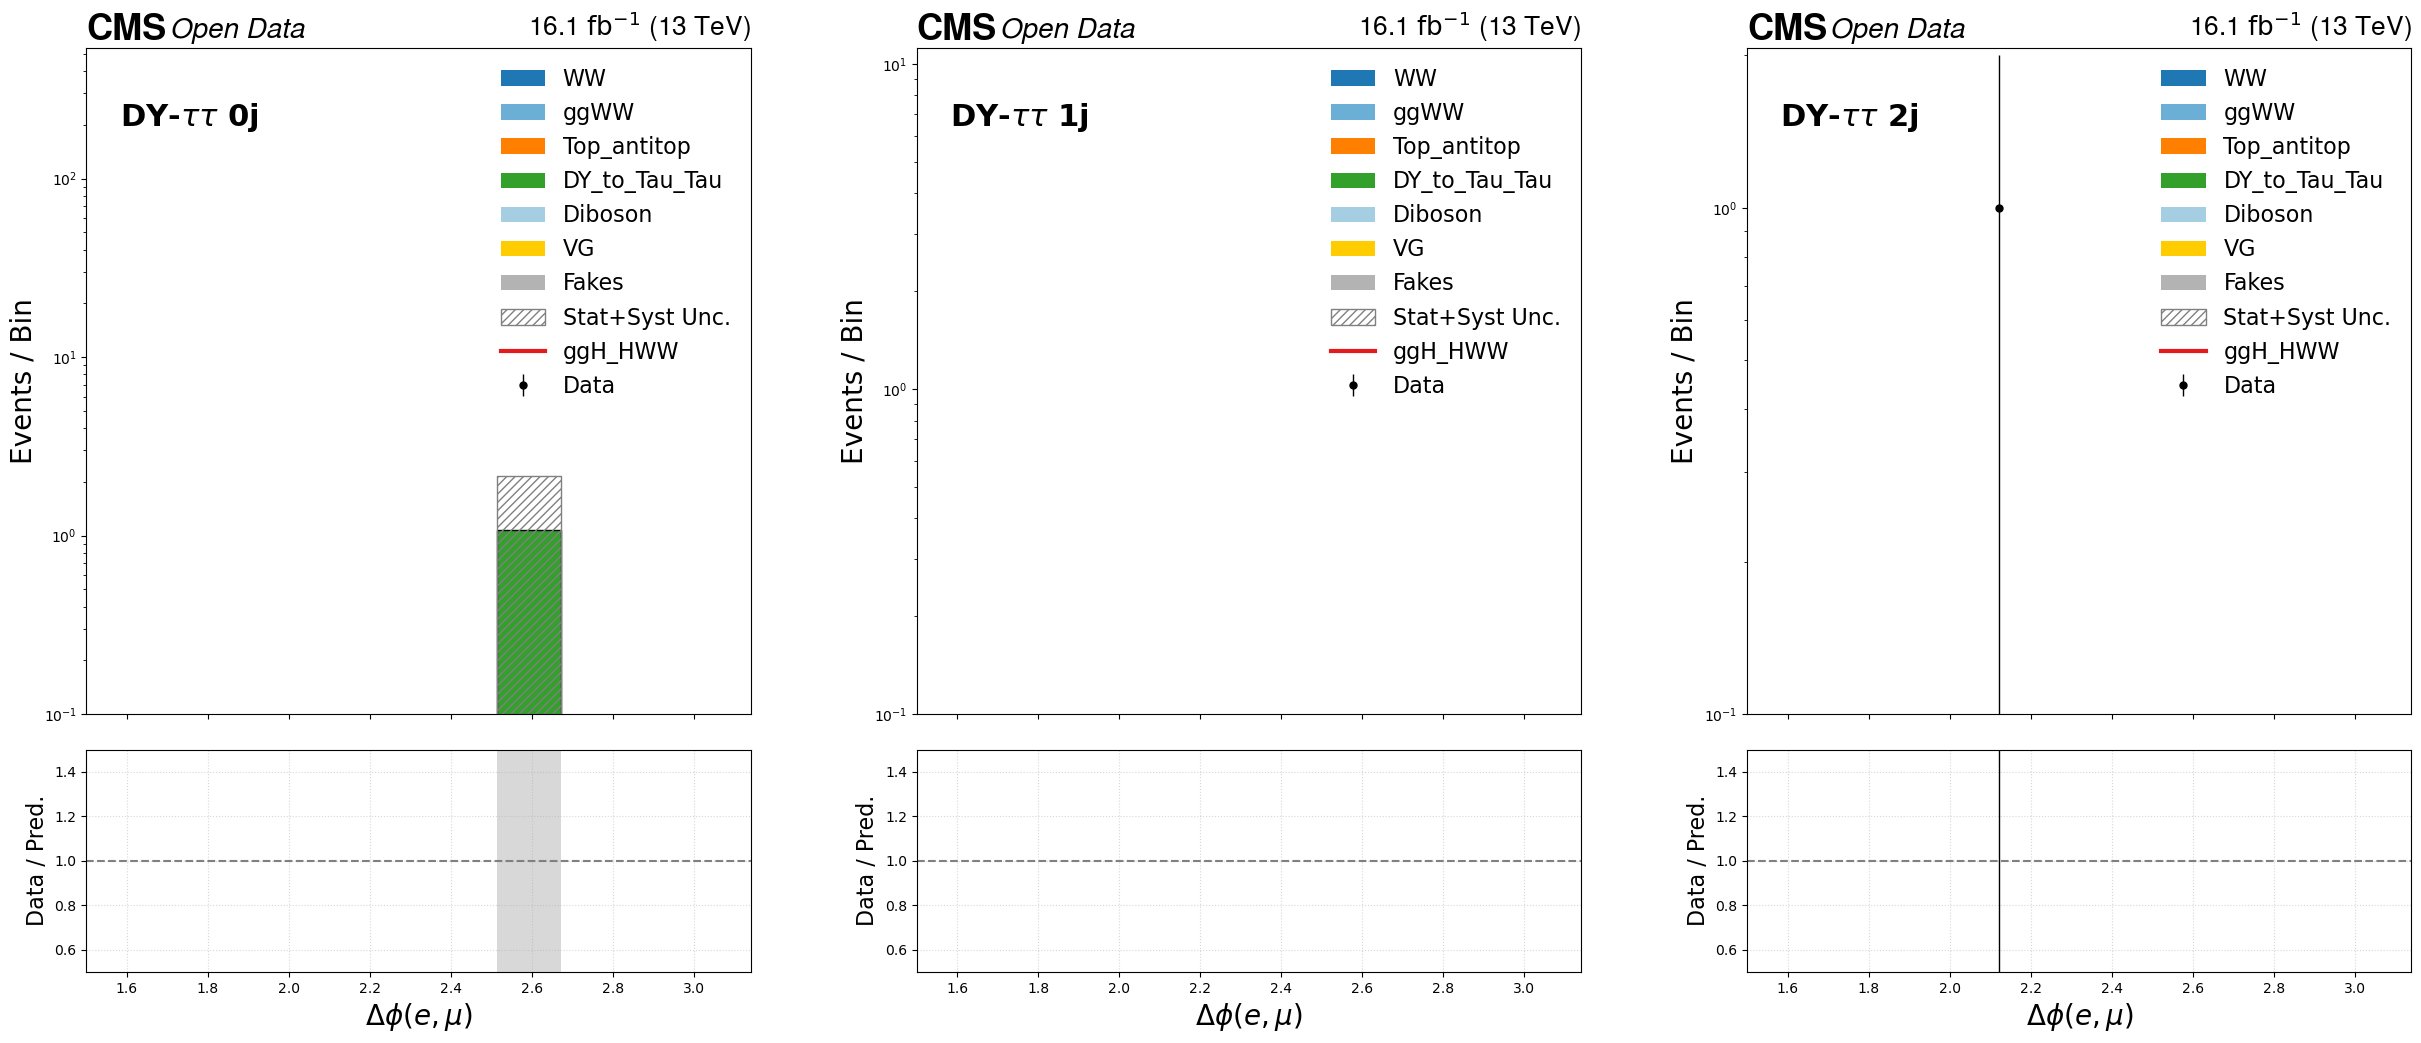

Plotting mt_higgs in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mt_higgs.png


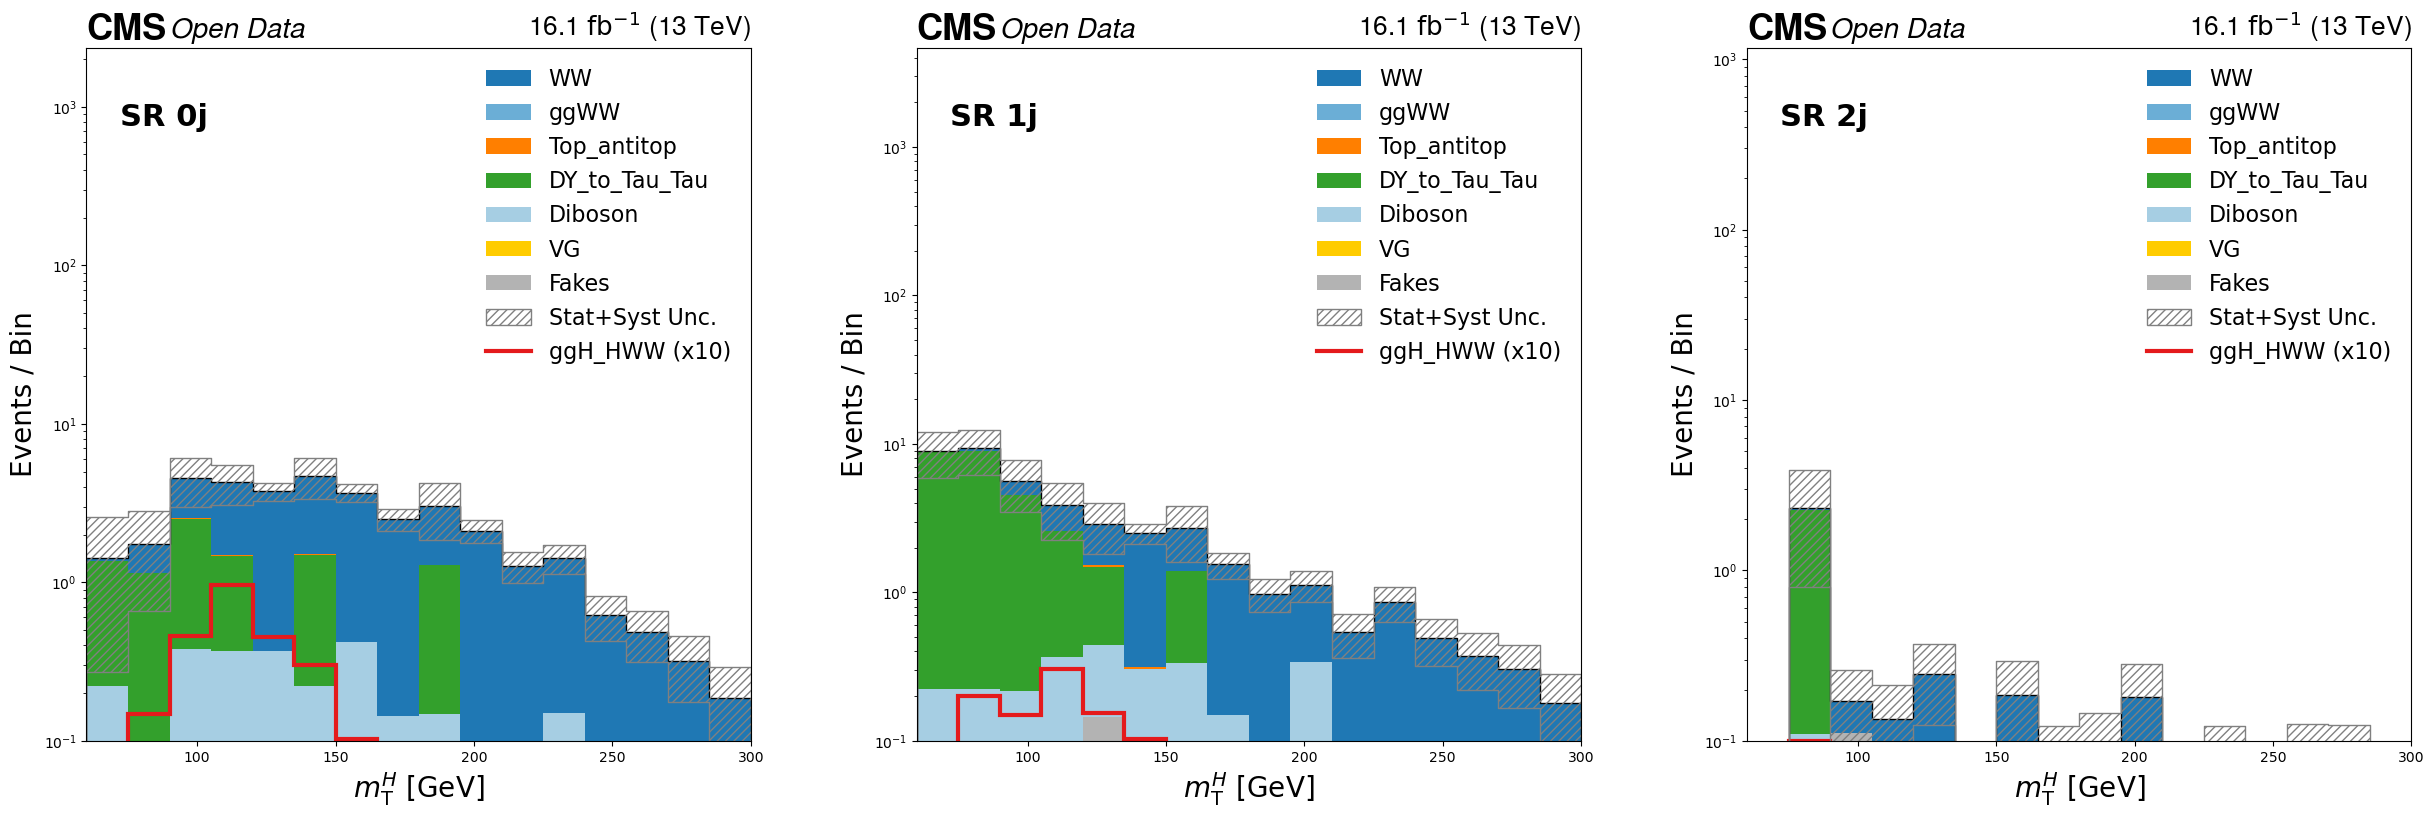

Plotting mt_higgs in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mt_higgs.png


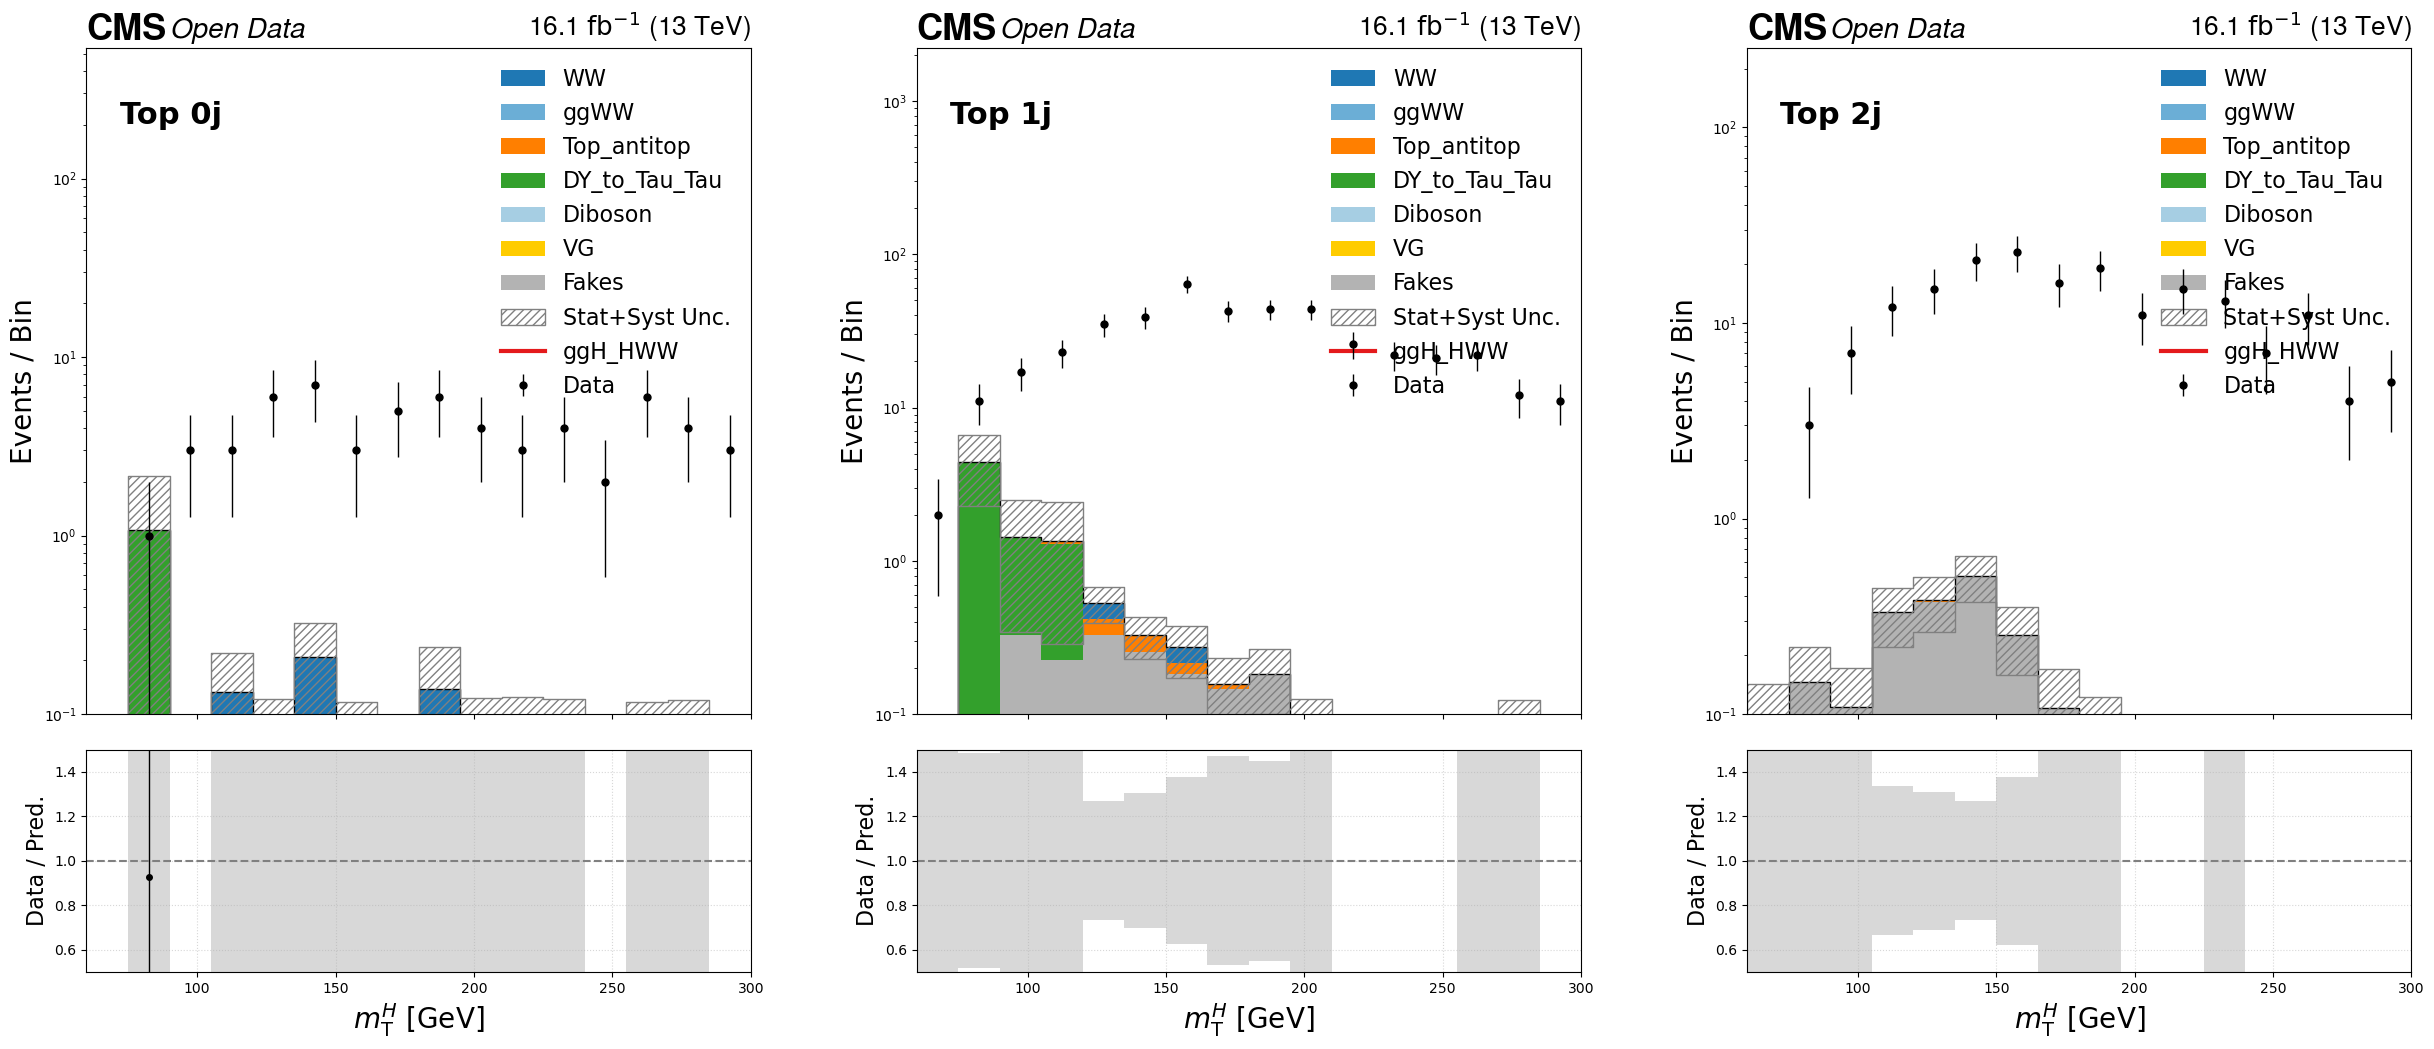

Plotting mt_higgs in Control_Region_Tau...


/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis/hww_tools/plotting.py:185: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mt_higgs.png


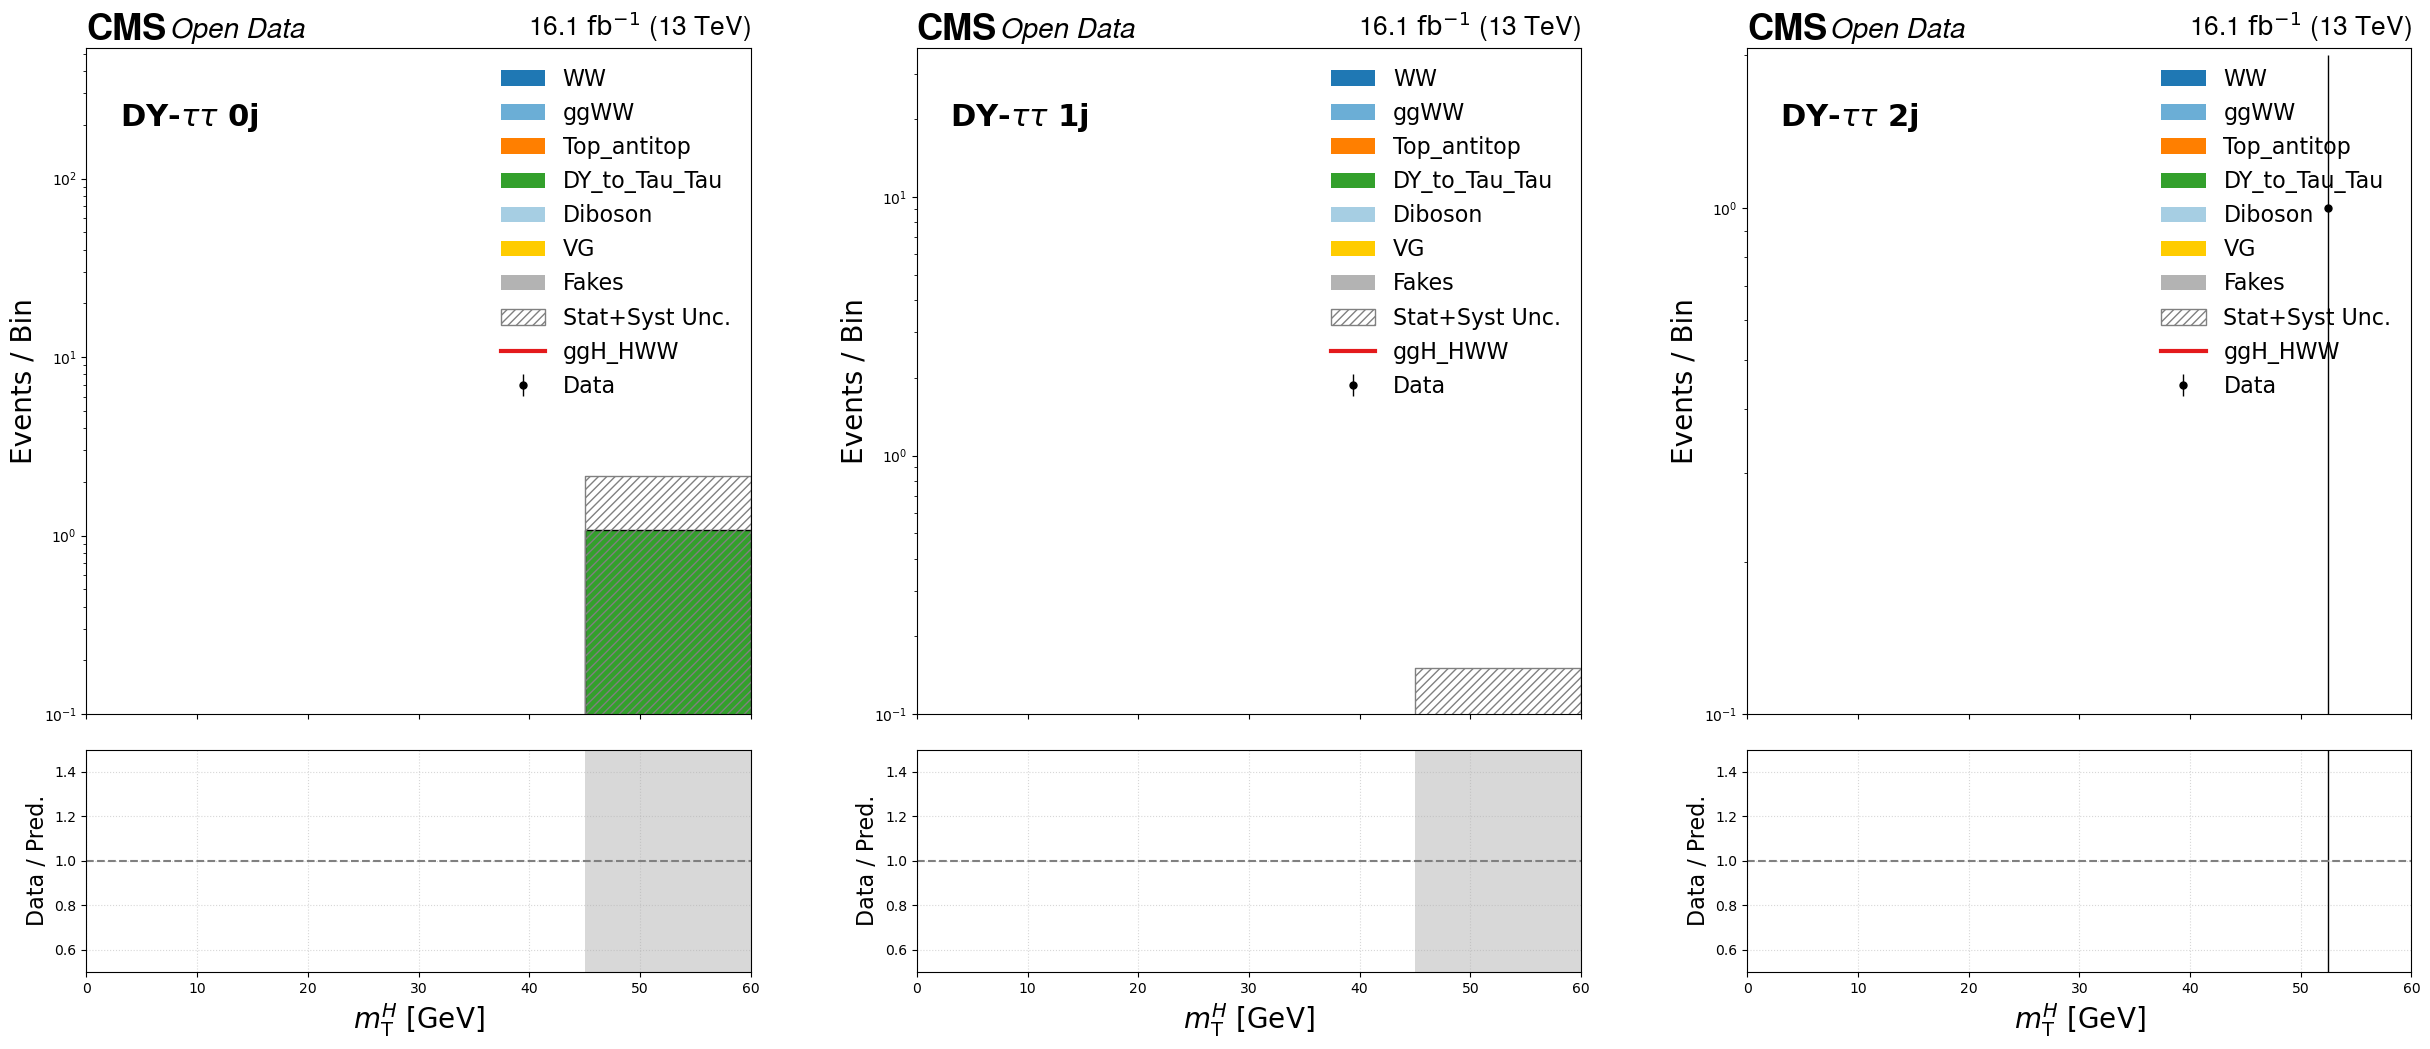

Plotting mt_l2_met in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mt_l2_met.png


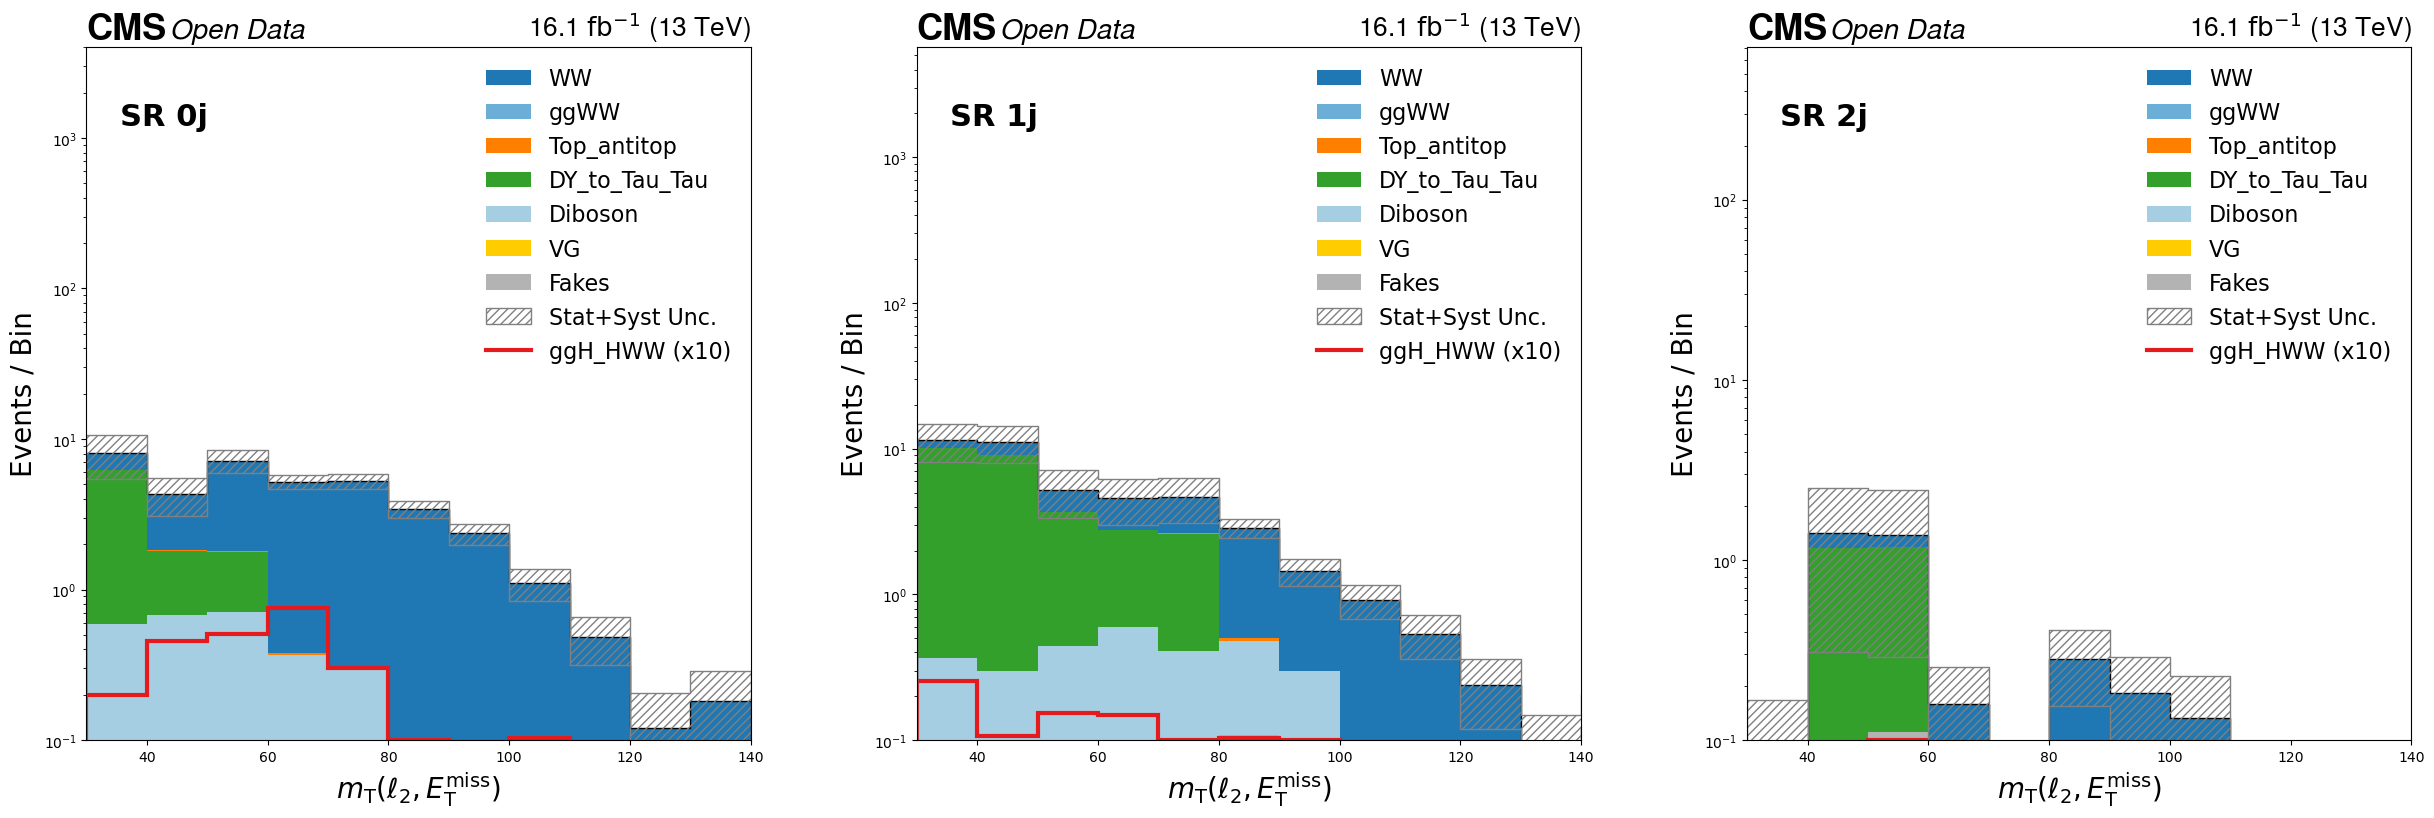

Plotting mt_l2_met in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mt_l2_met.png


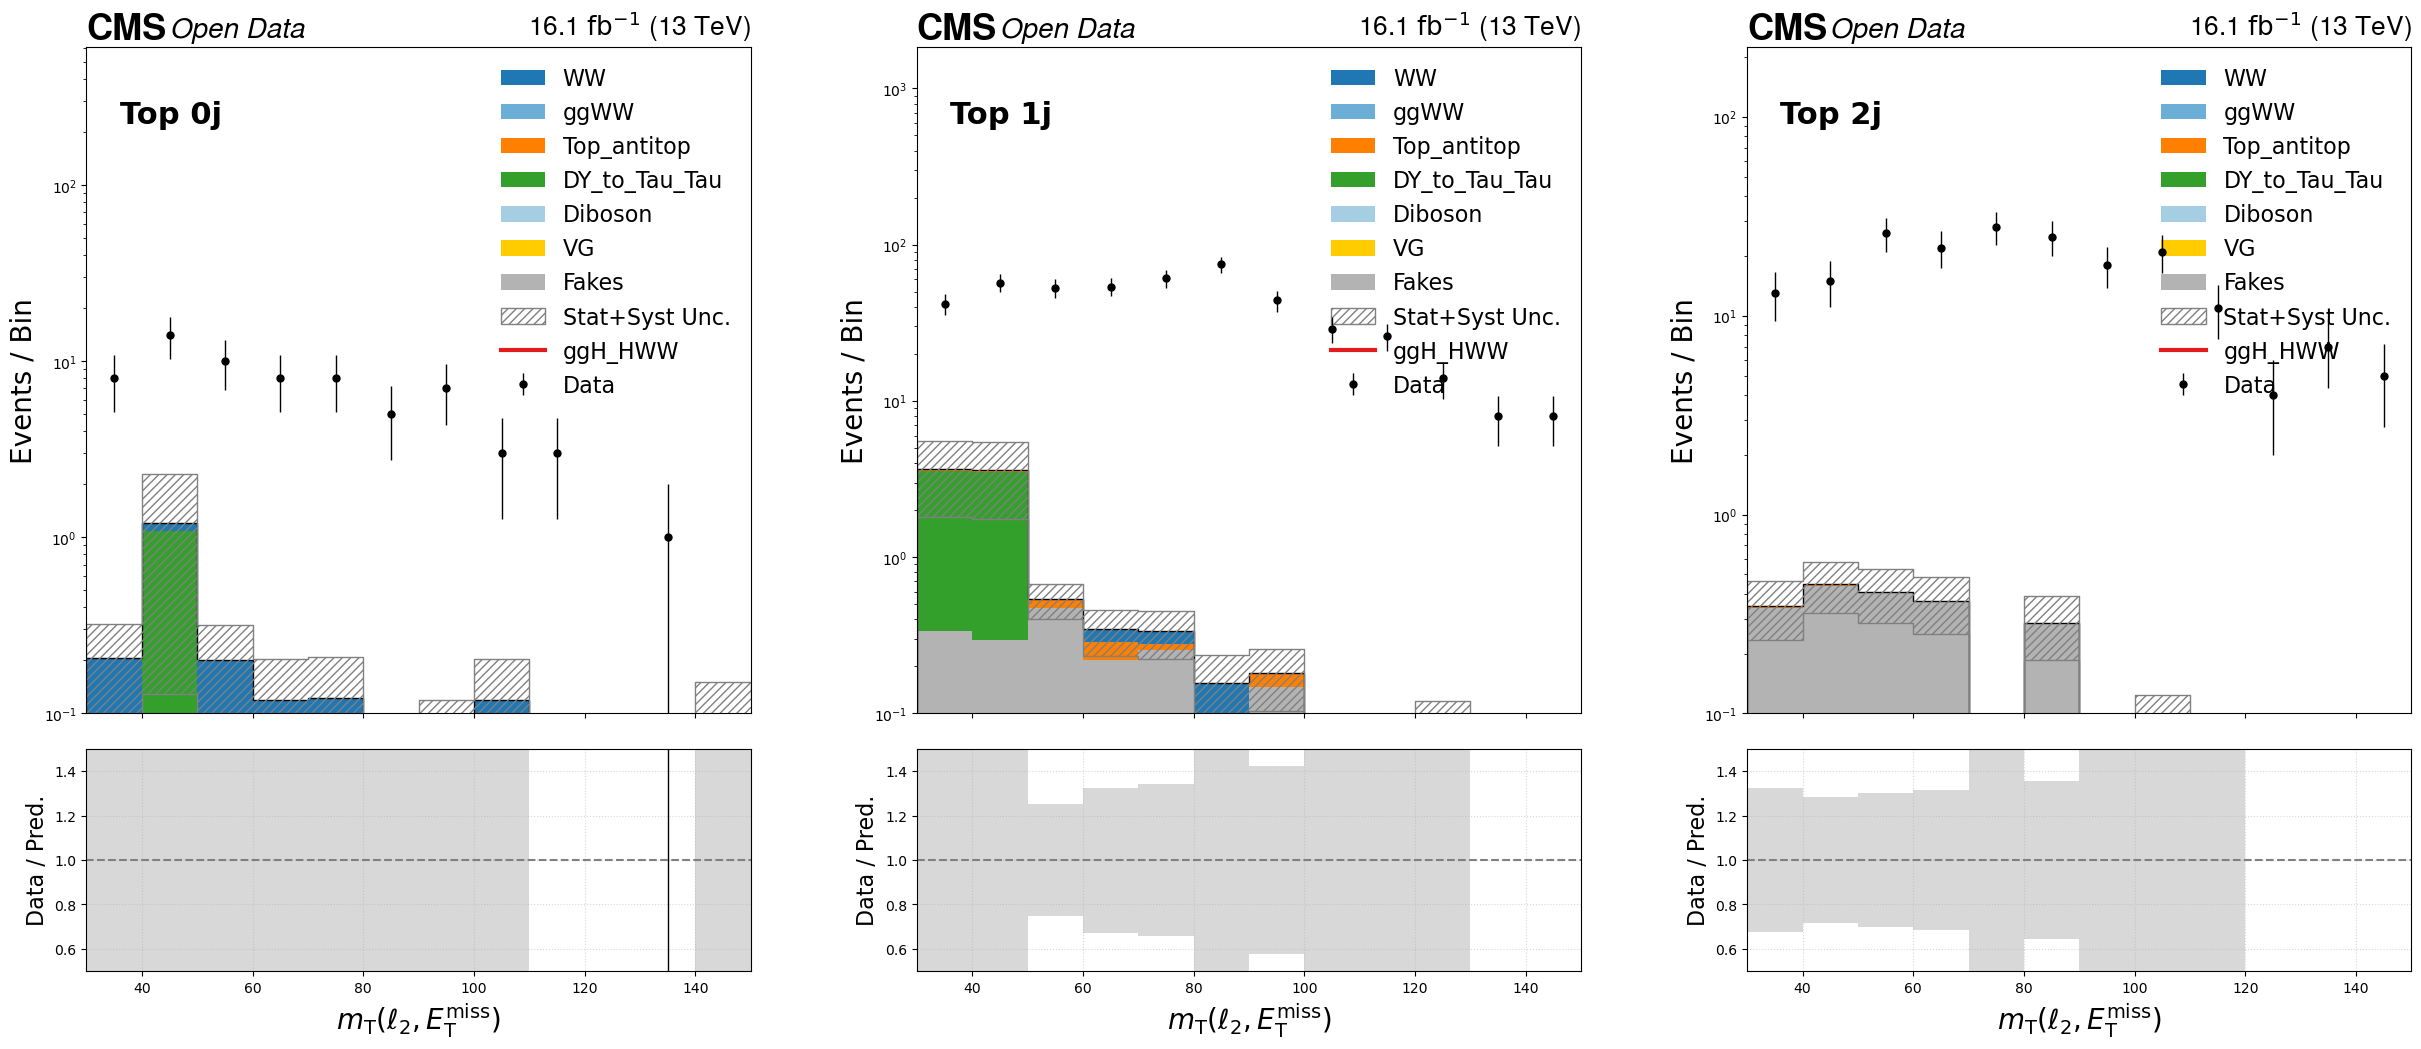

Plotting mt_l2_met in Control_Region_Tau...


/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis/hww_tools/plotting.py:185: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mt_l2_met.png


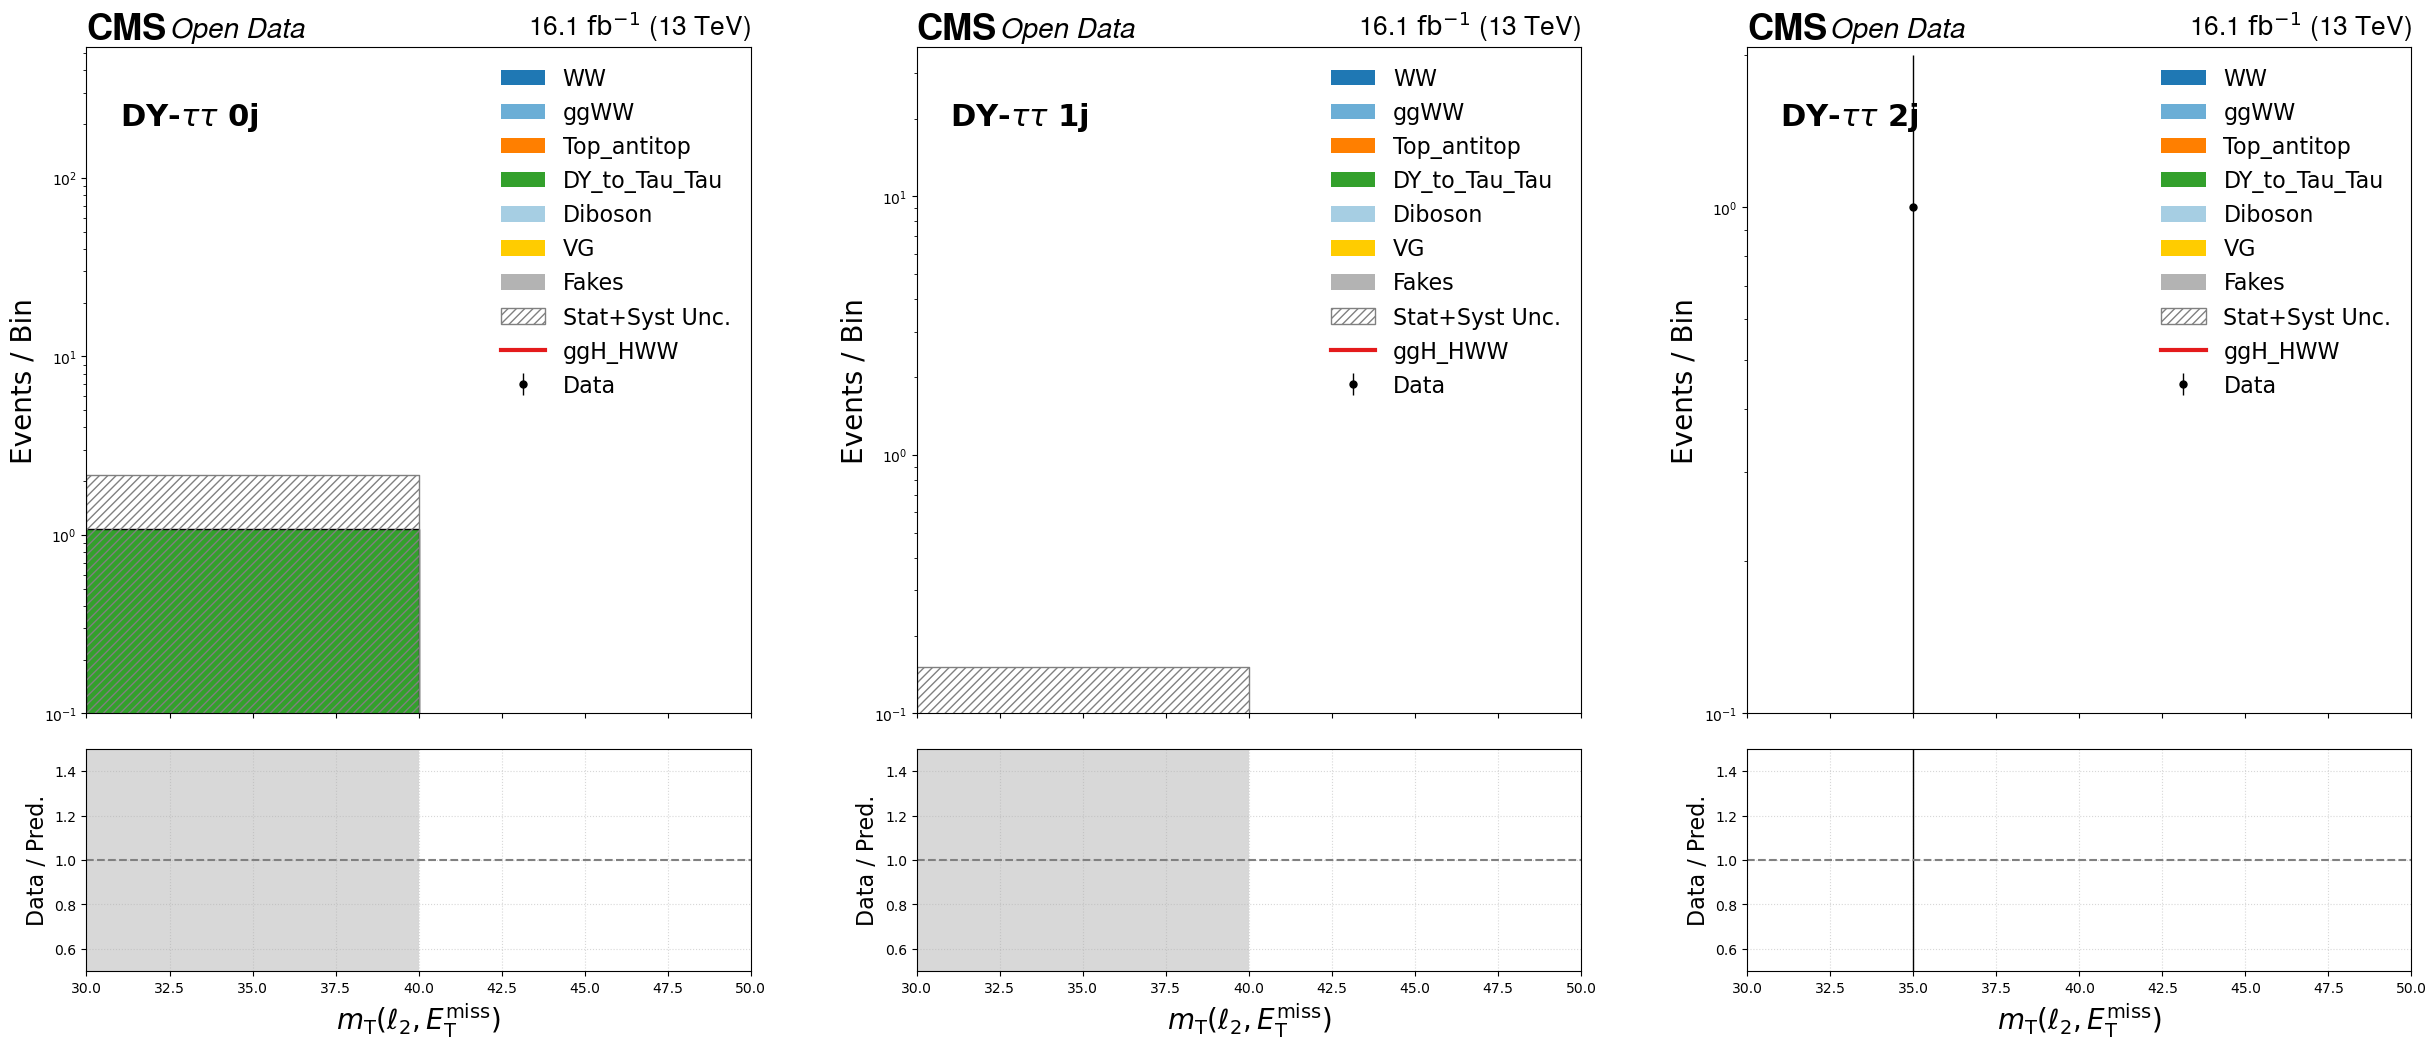

Plotting mjj in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mjj.png


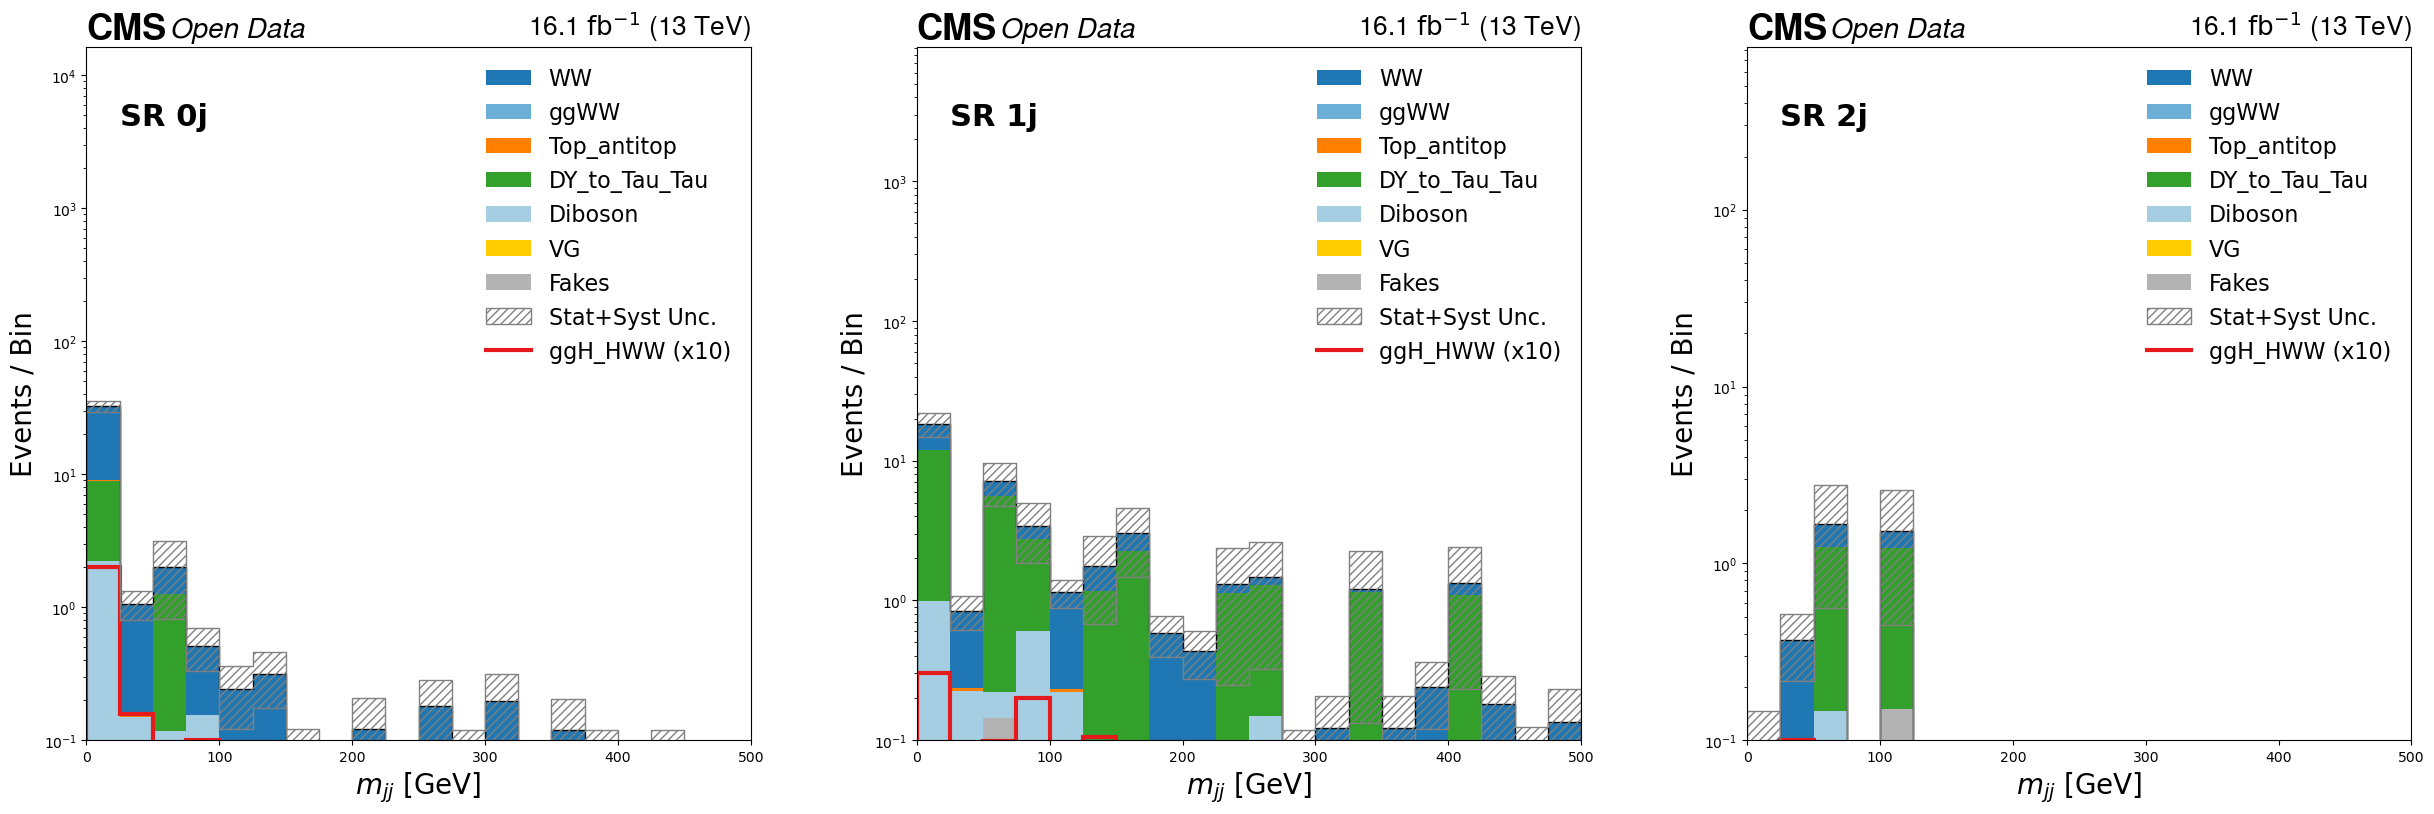

Plotting mjj in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mjj.png


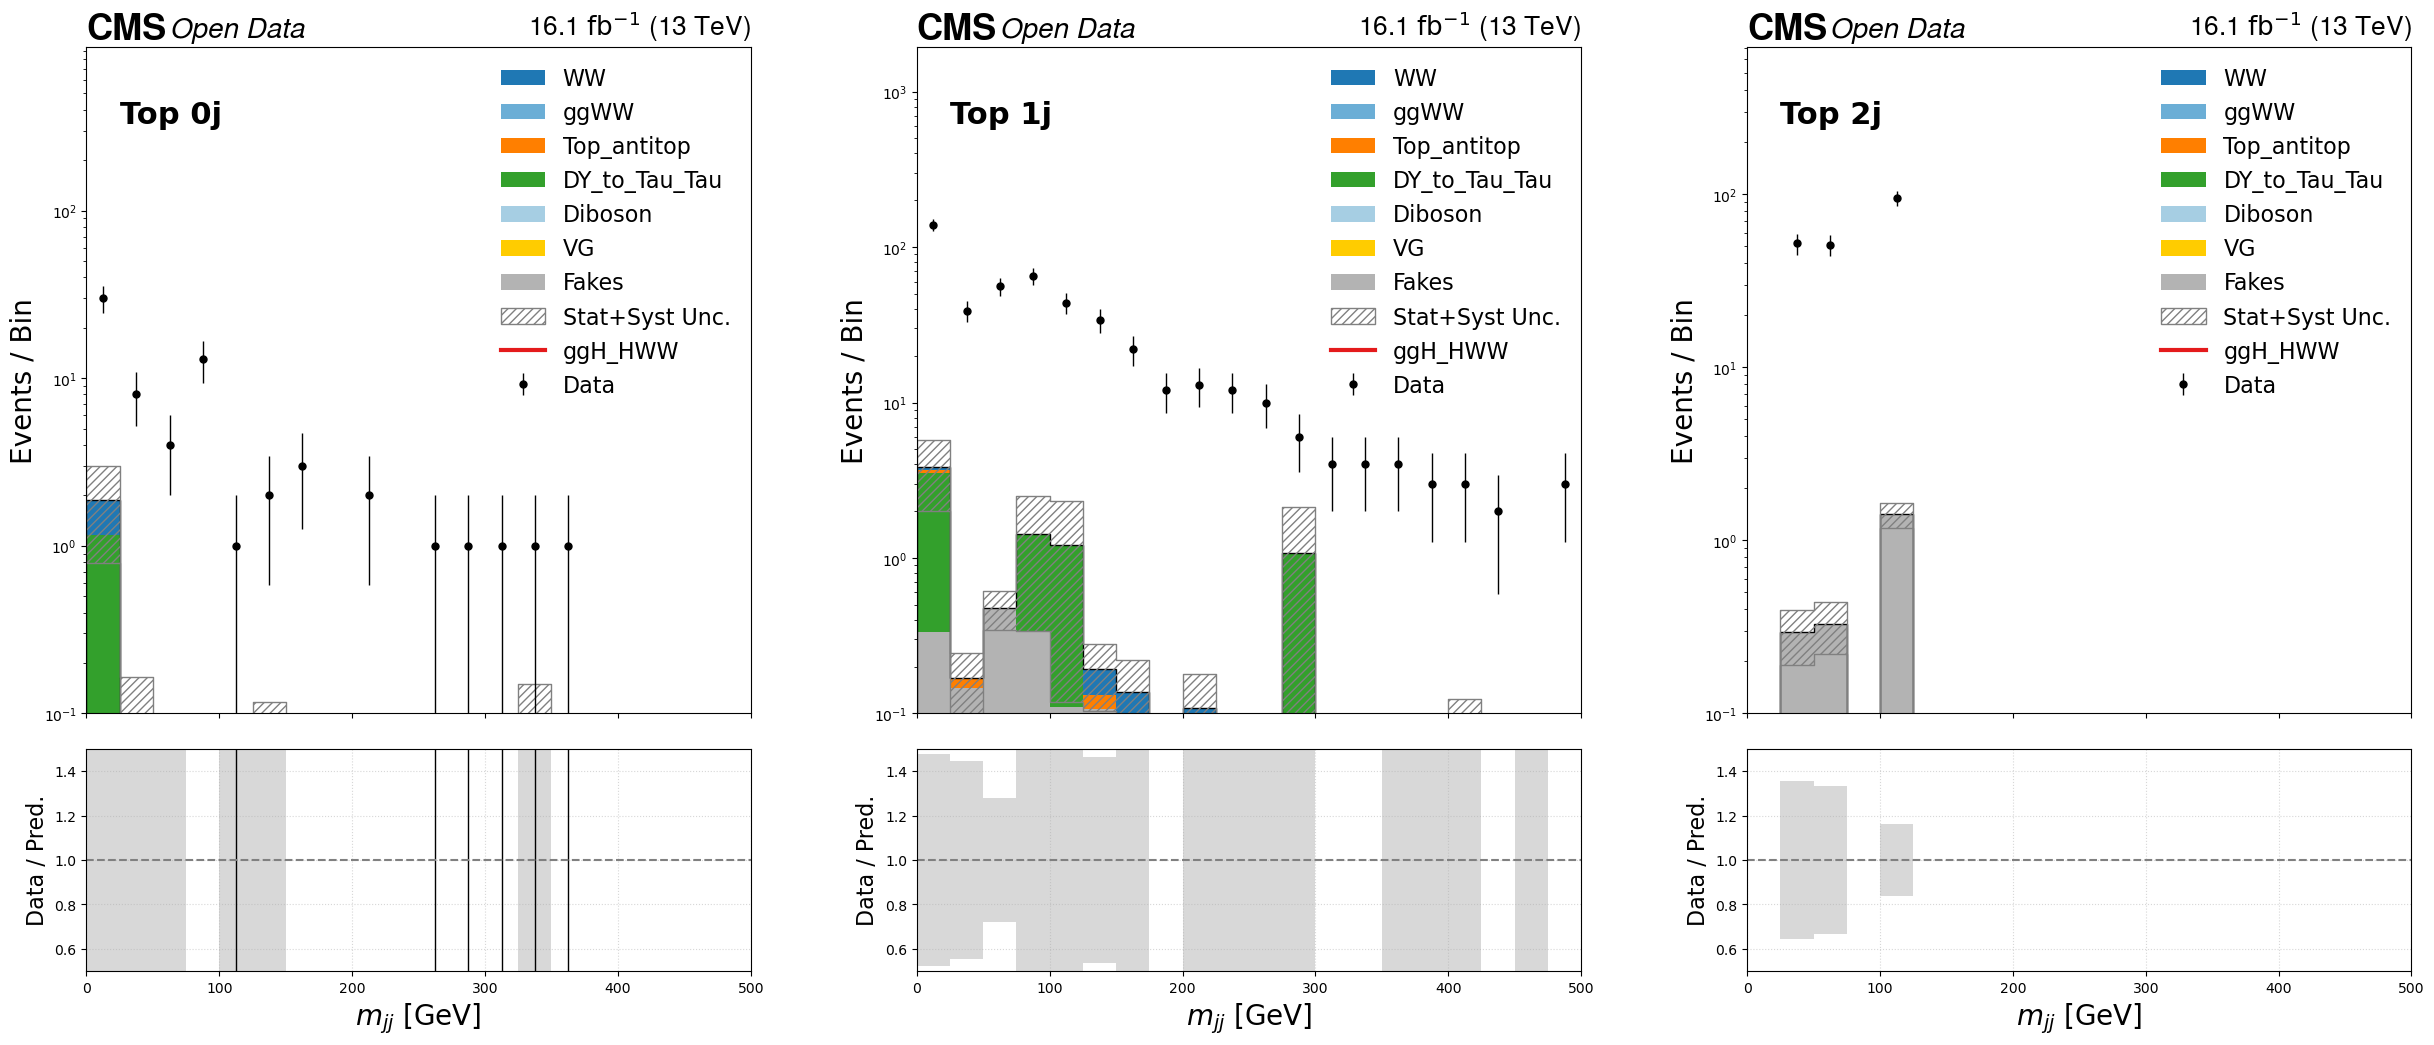

Plotting mjj in Control_Region_Tau...


/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis/hww_tools/plotting.py:185: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mjj.png


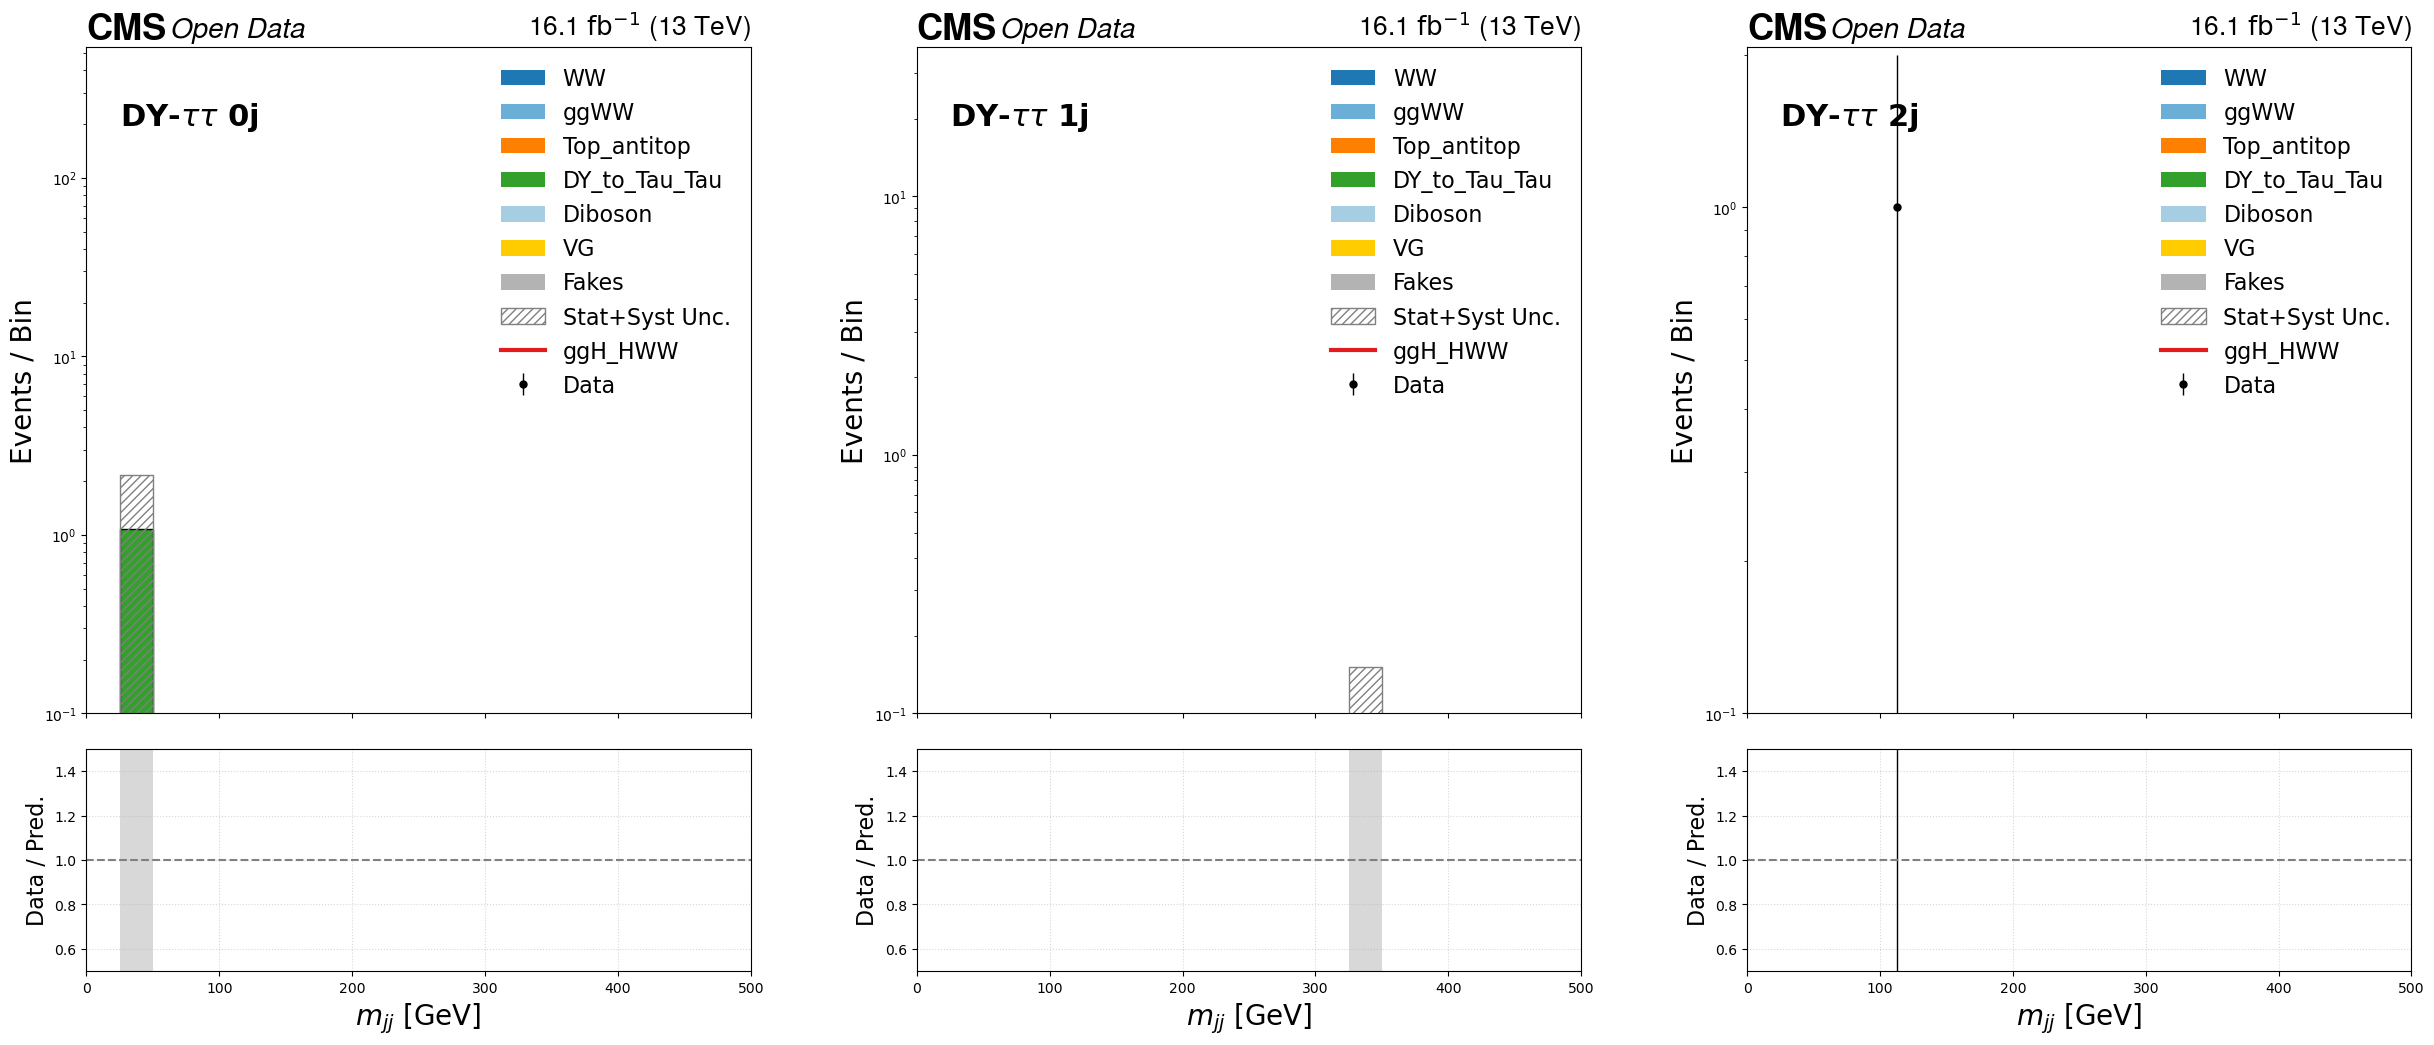

Plotting leading_pt in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_leading_pt.png


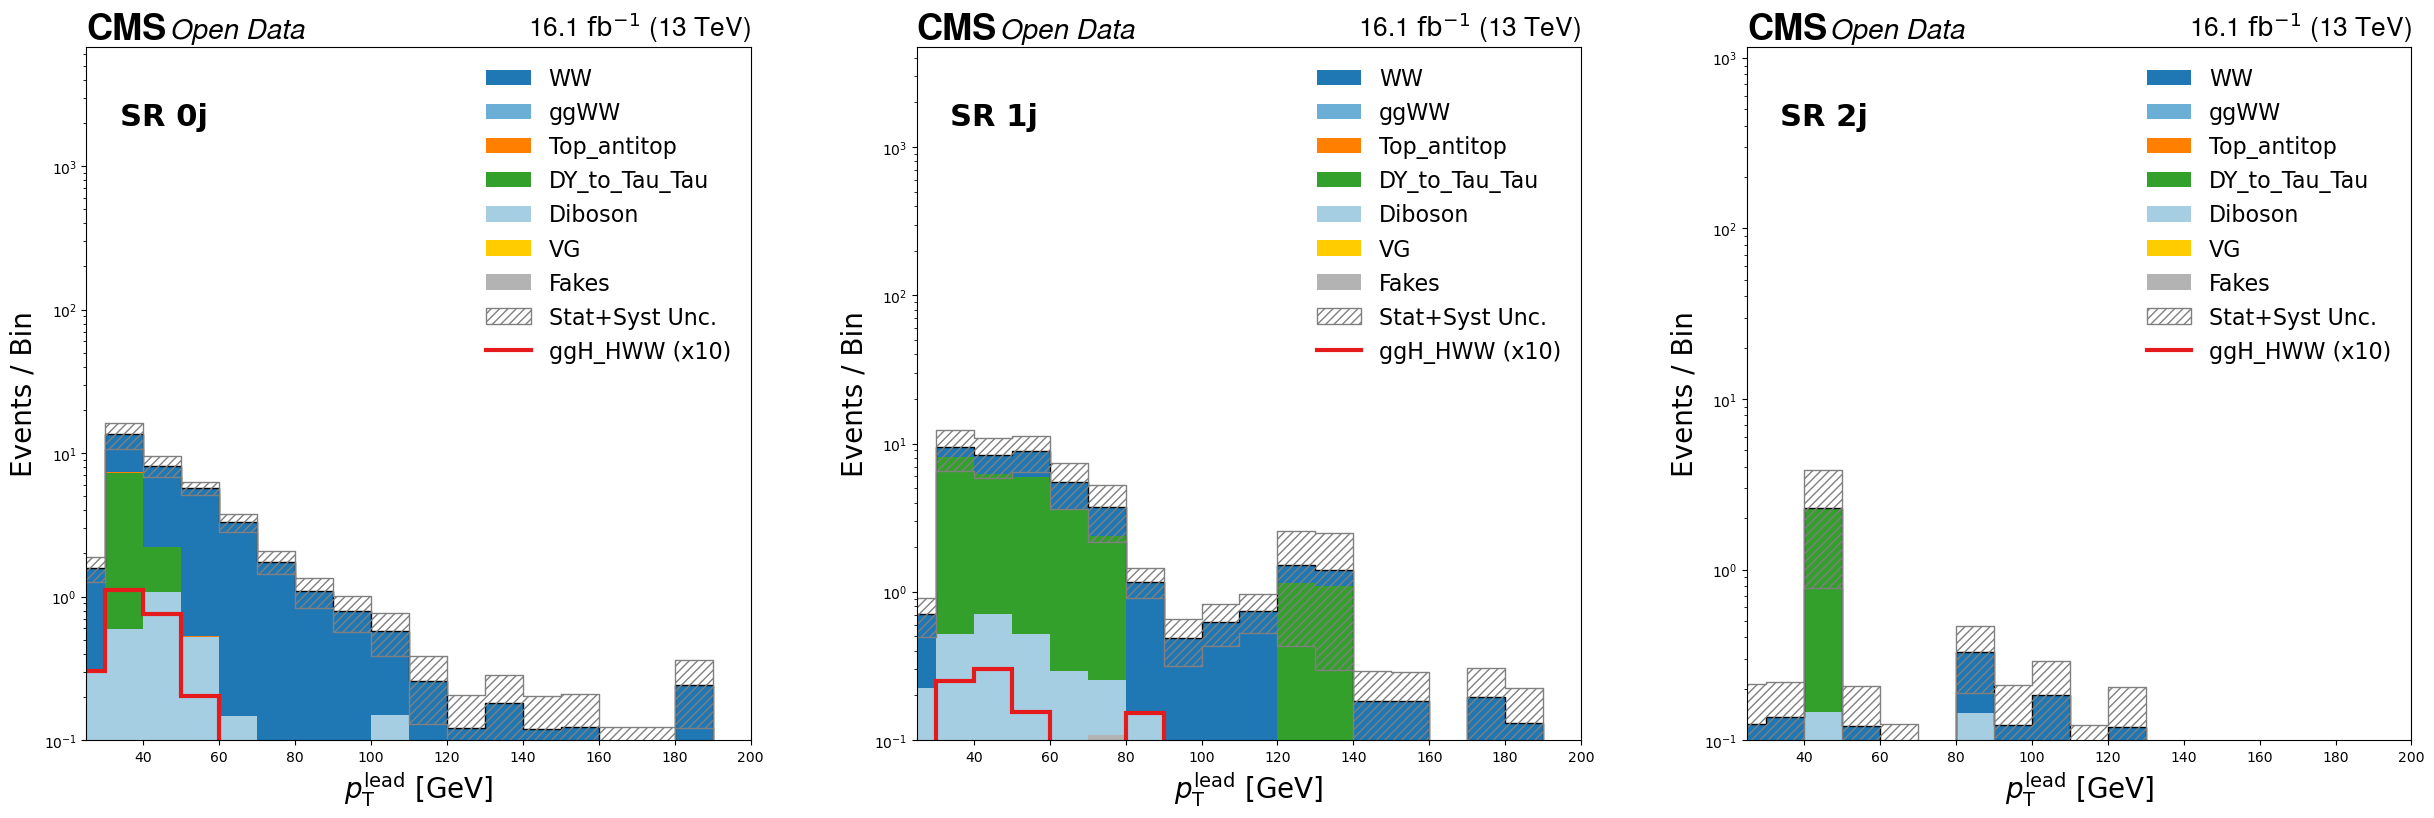

Plotting leading_pt in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_leading_pt.png


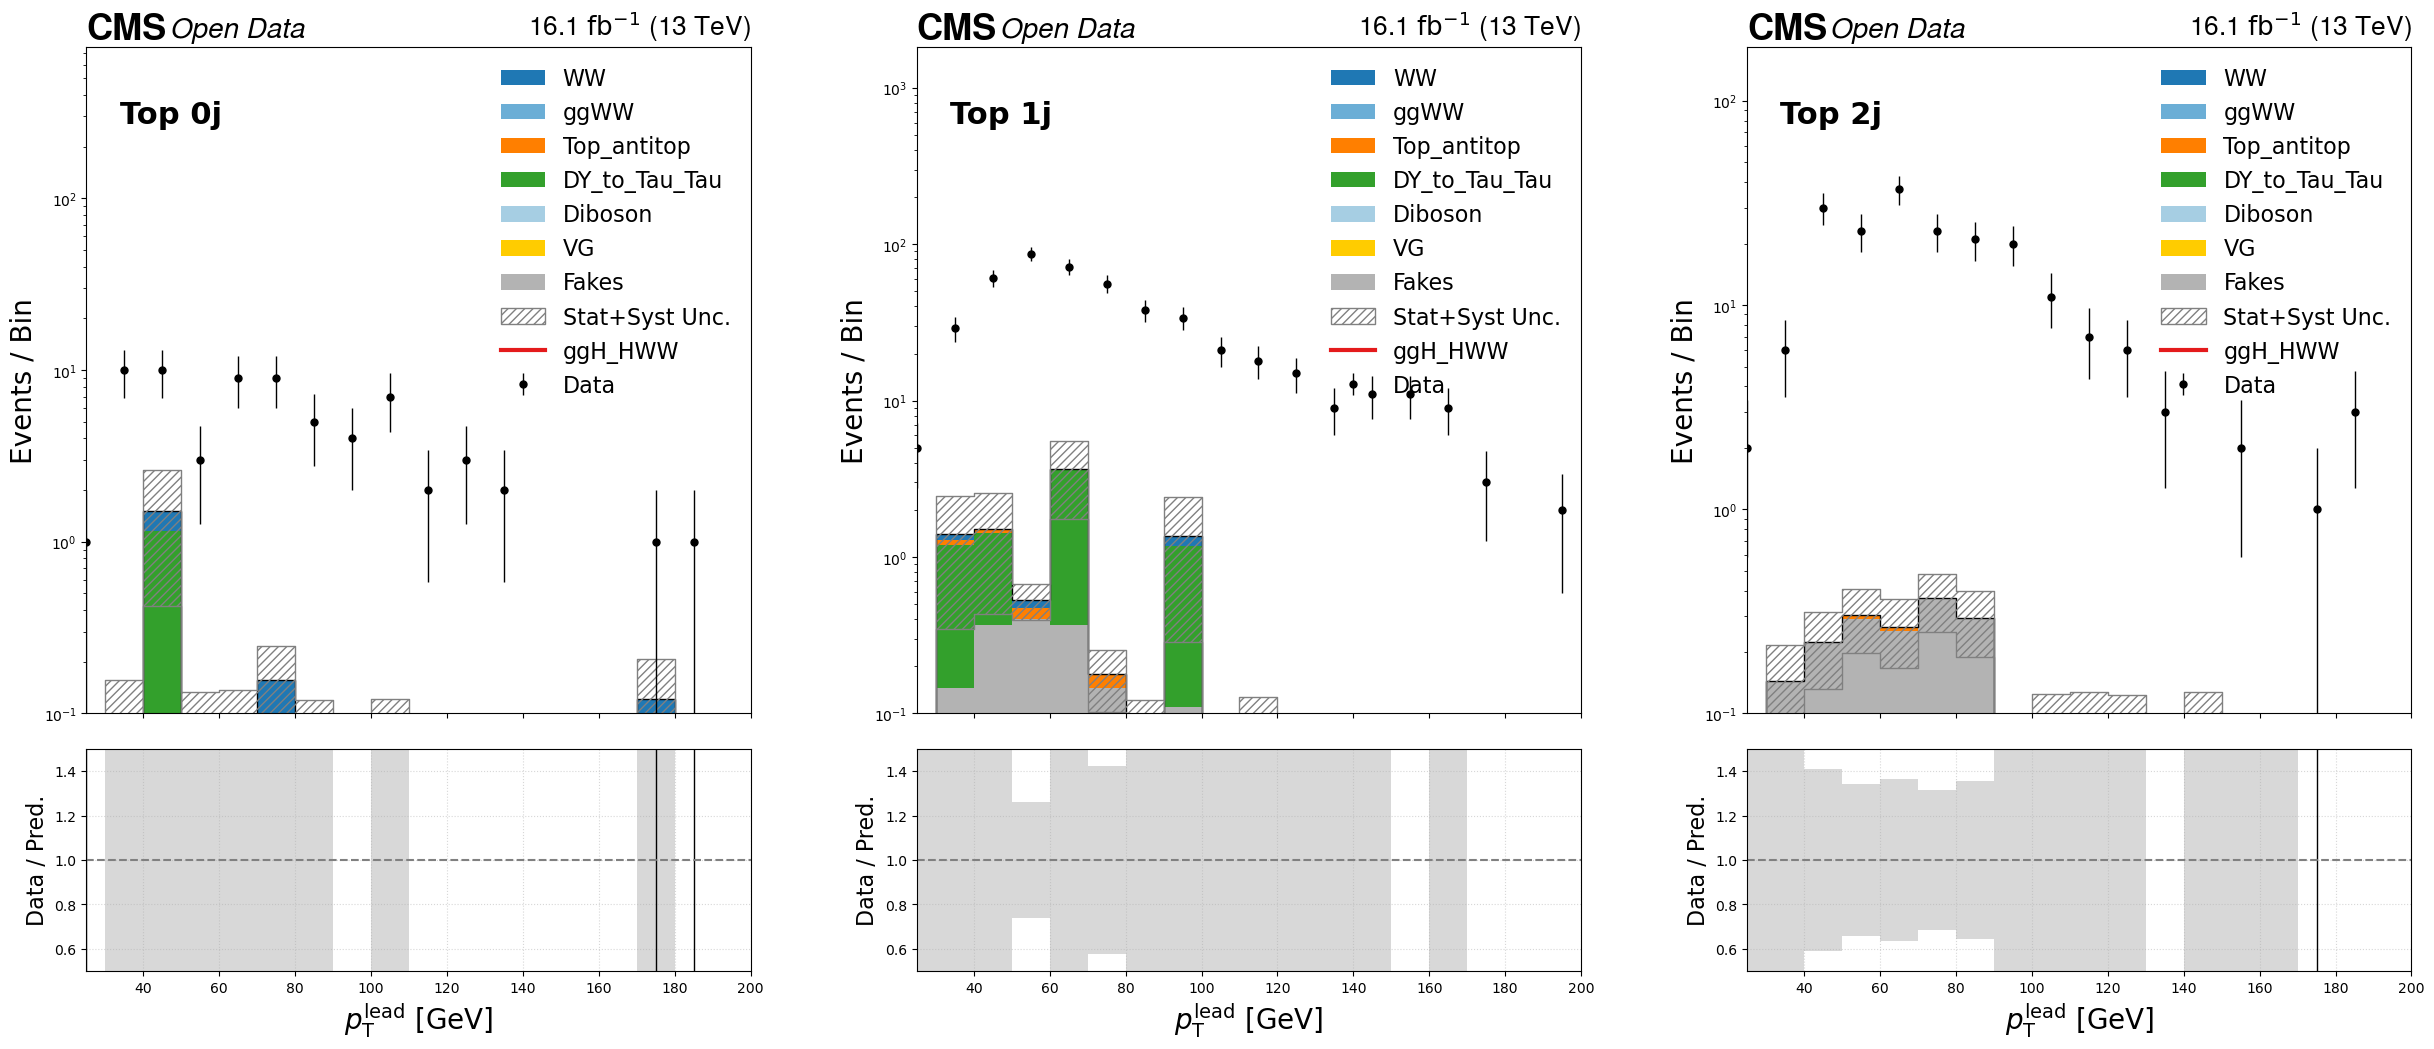

Plotting leading_pt in Control_Region_Tau...


/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis/hww_tools/plotting.py:185: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_leading_pt.png


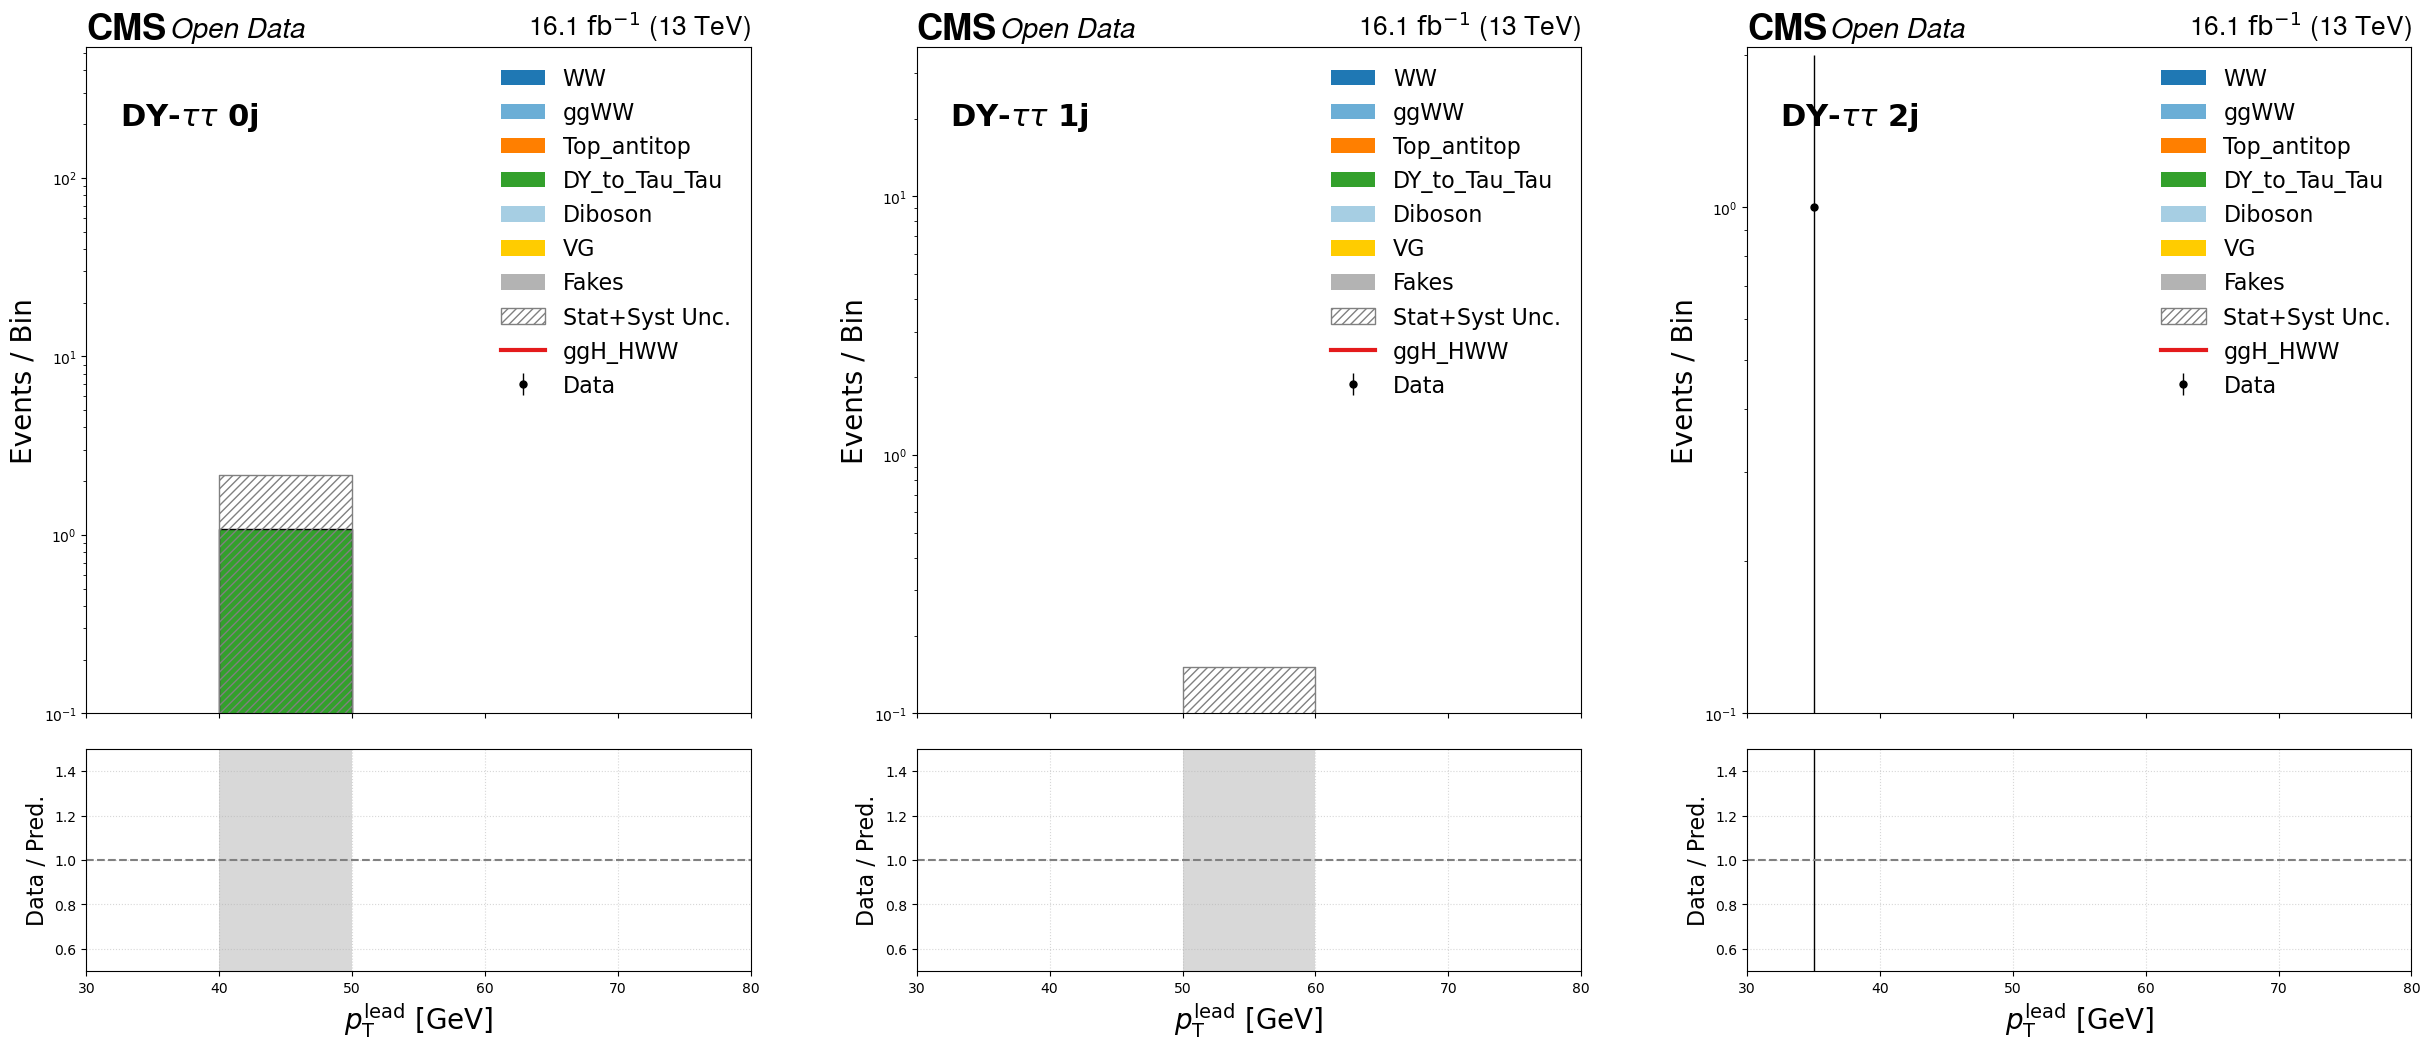

Plotting subleading_pt in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_subleading_pt.png


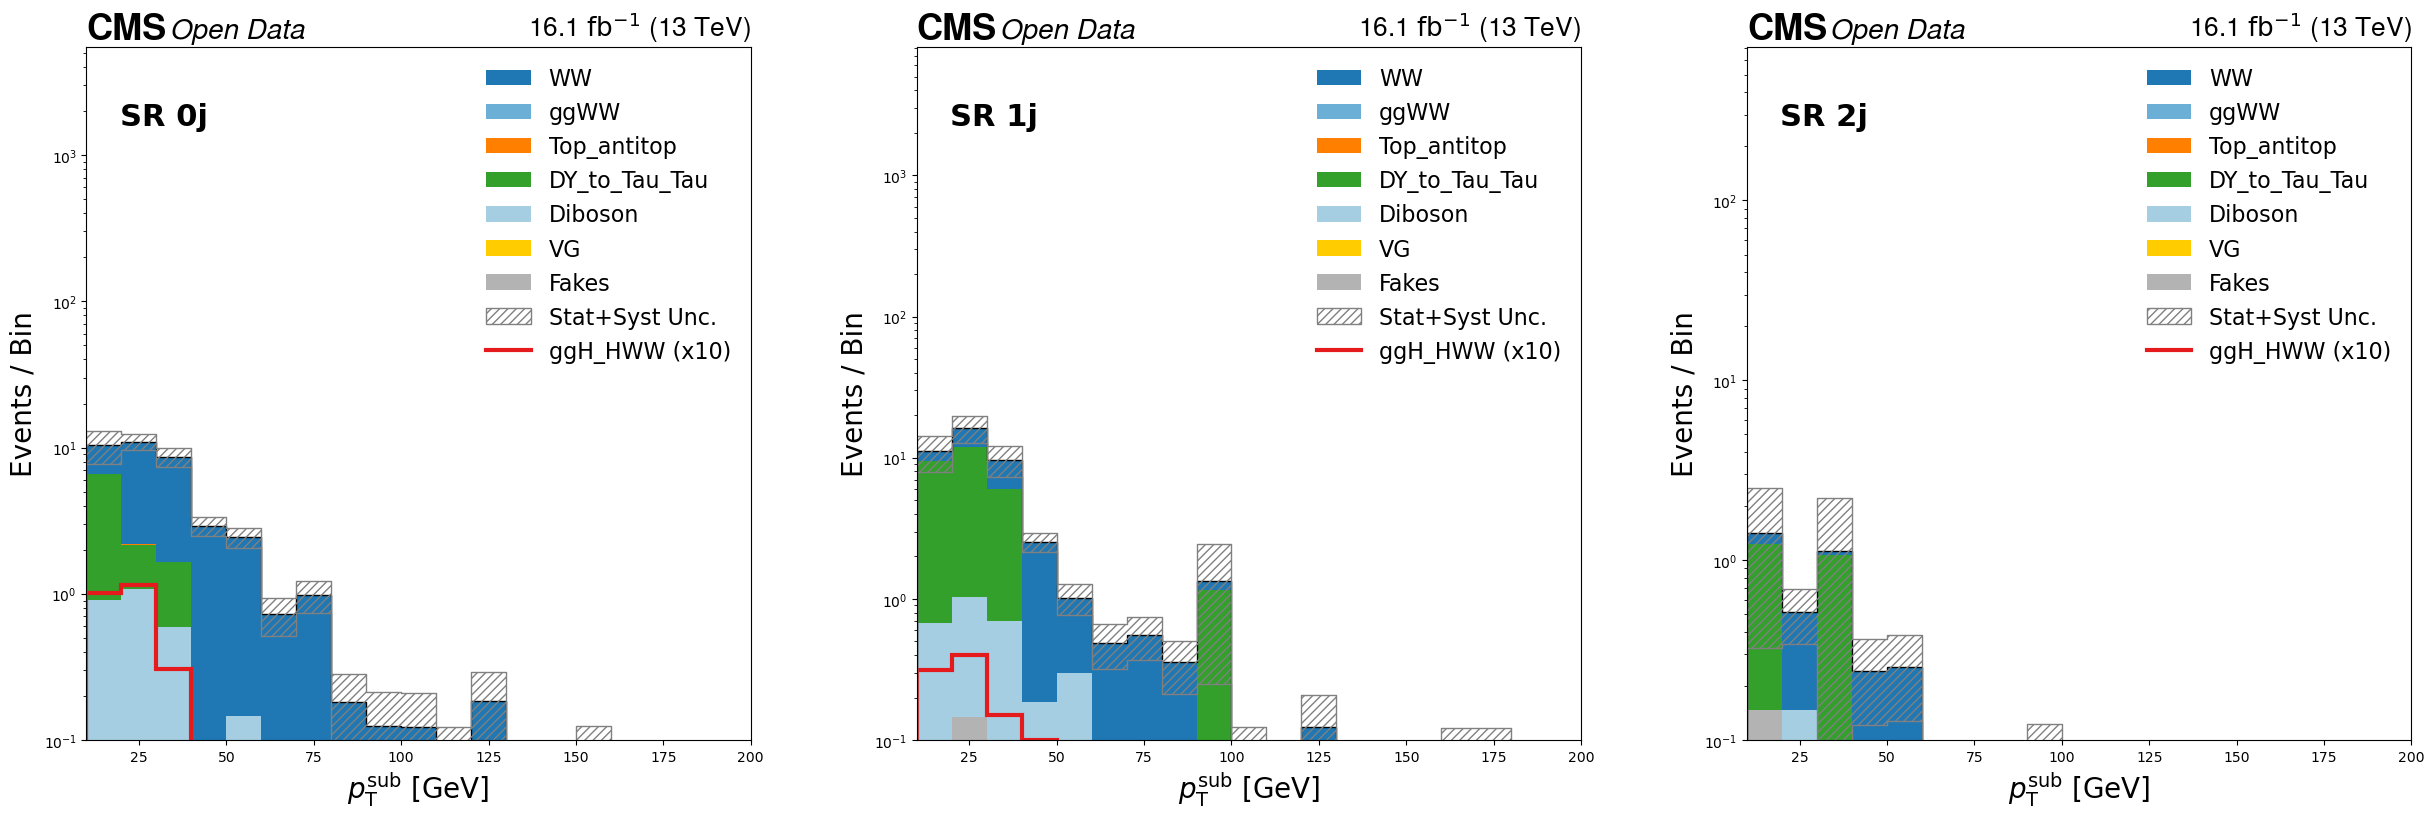

Plotting subleading_pt in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_subleading_pt.png


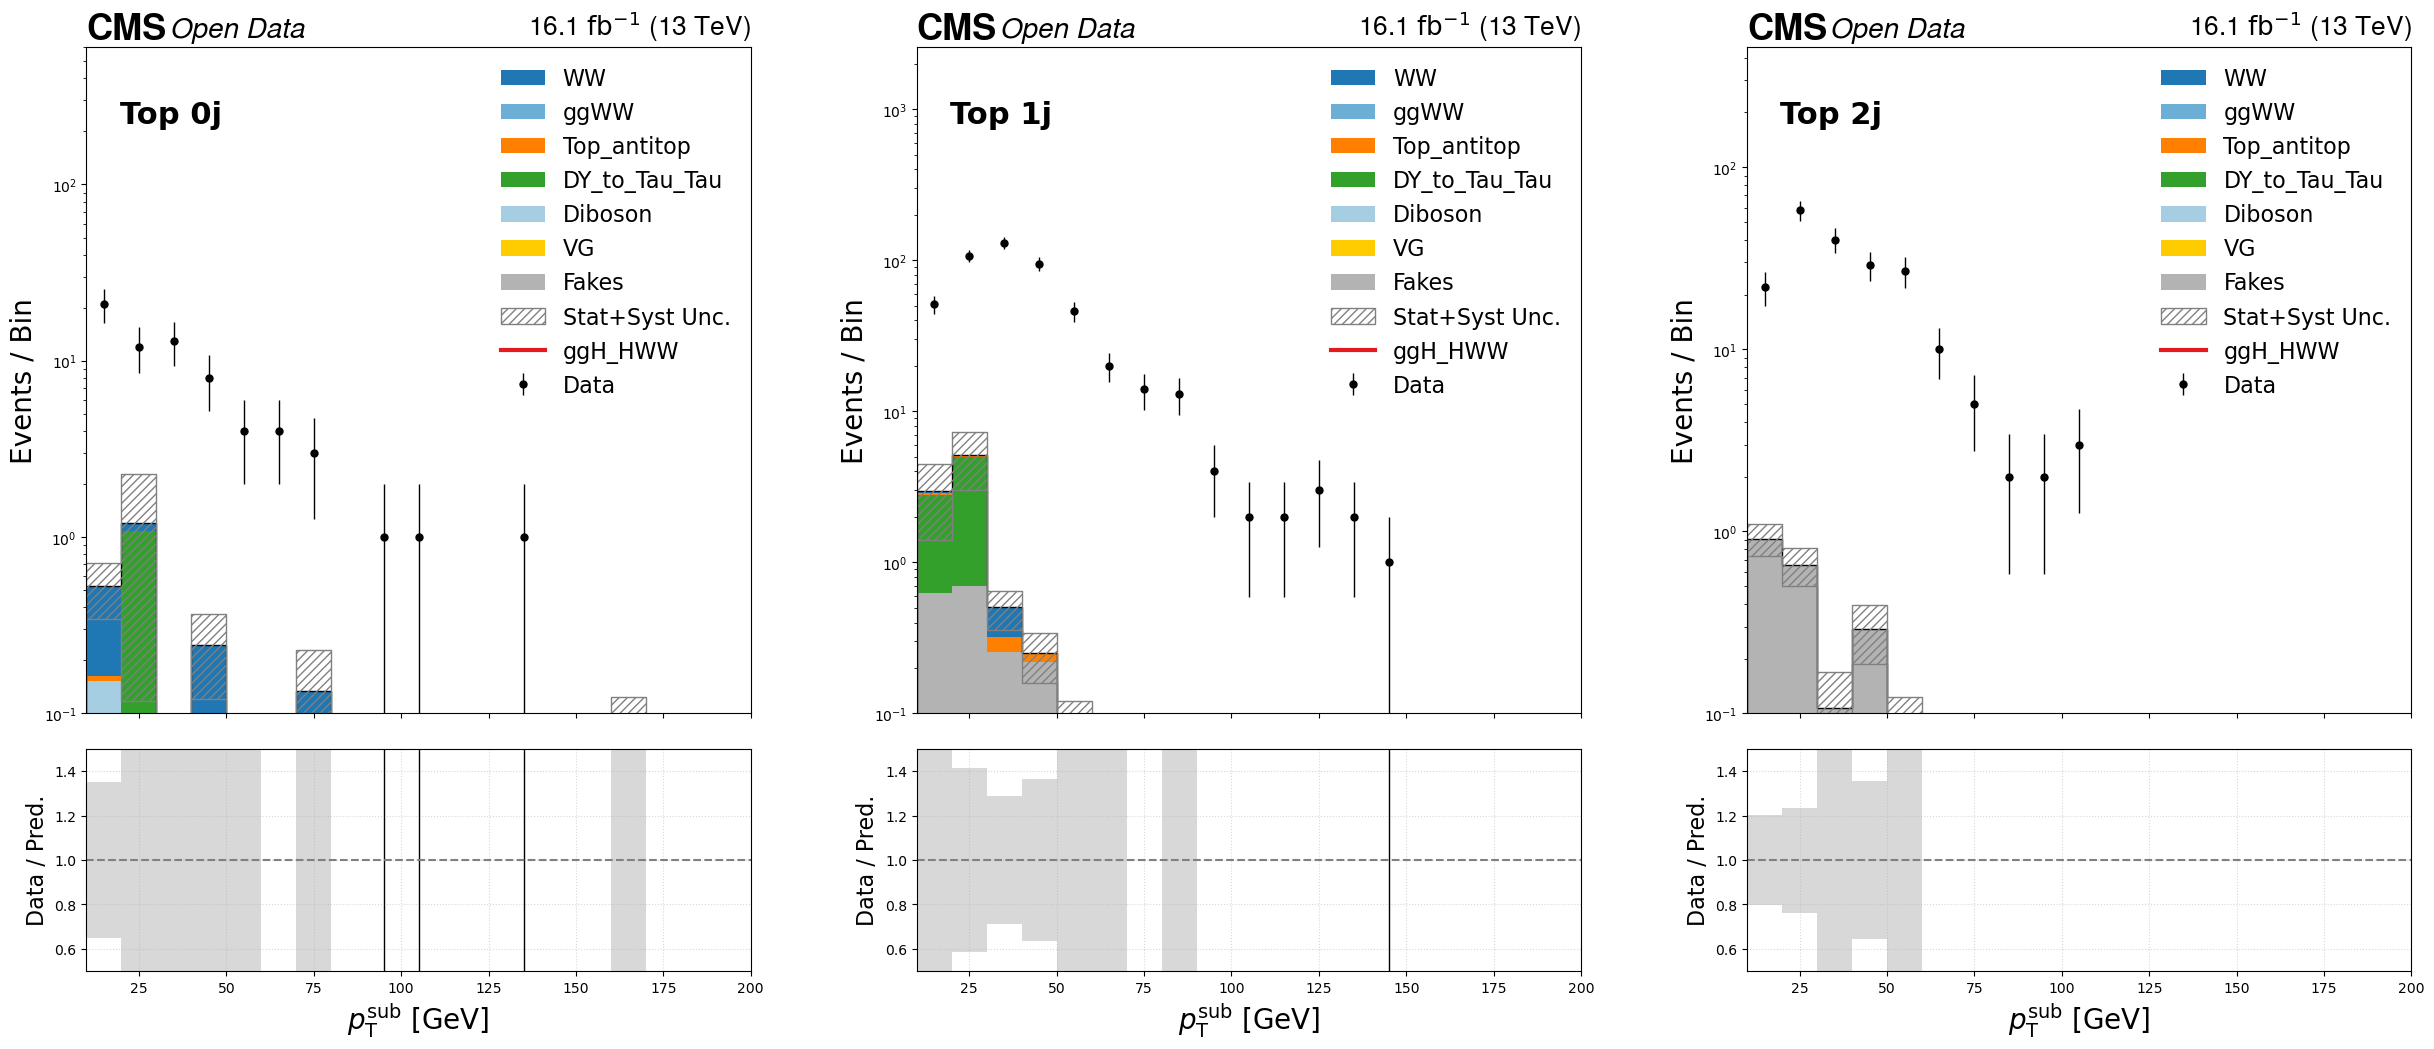

Plotting subleading_pt in Control_Region_Tau...


/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis/hww_tools/plotting.py:185: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_main.set_ylim(0.1, max_val * 500)


Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_subleading_pt.png


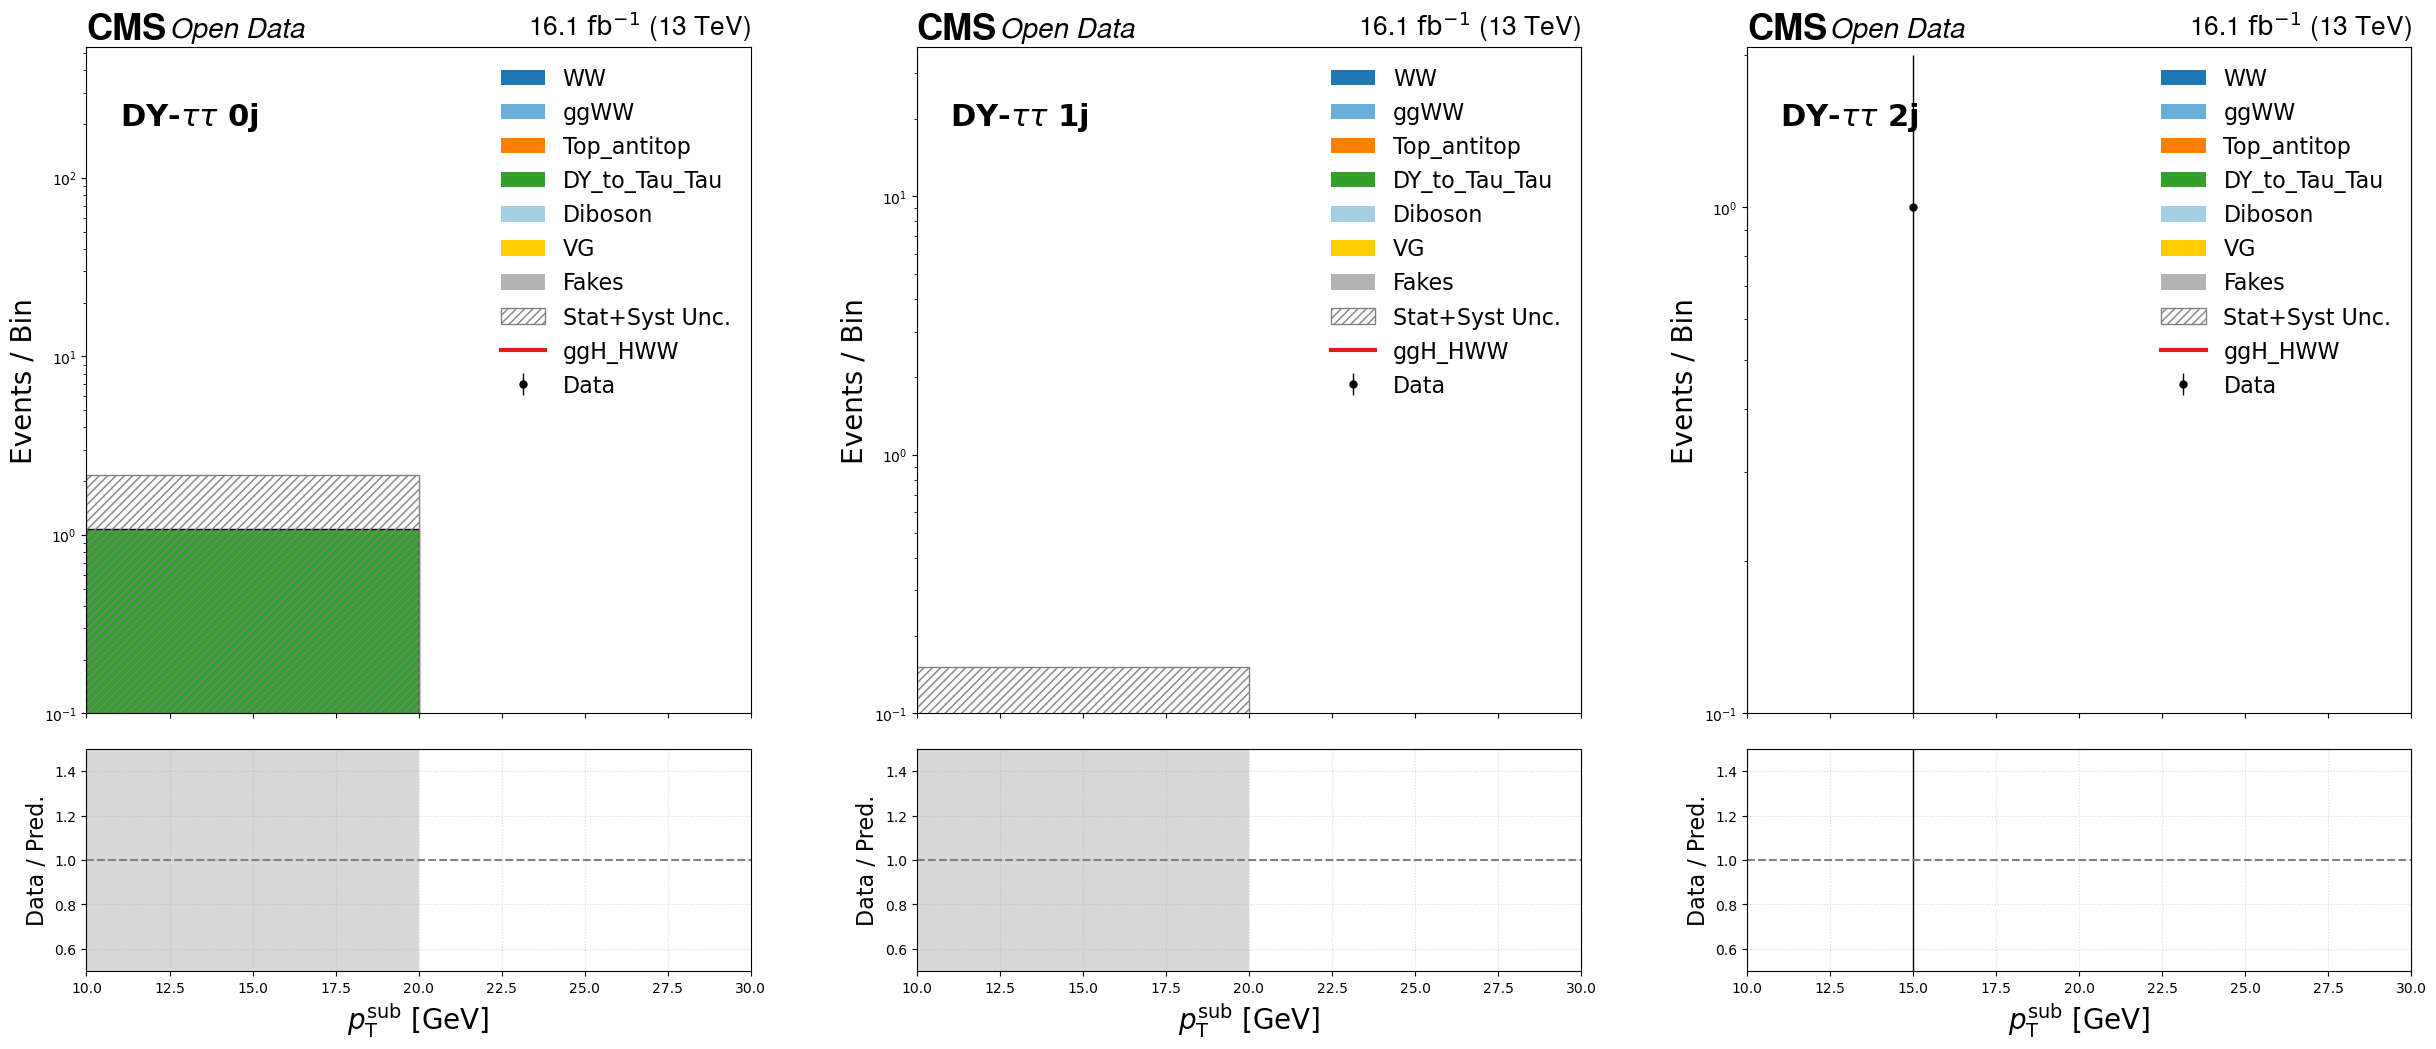


All plots saved to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked


In [11]:
print("\n" + "="*70)
print("GENERATING STACKED PLOTS...")
print("="*70)

output_dir = PLOTS_DIR / "Stacked"
output_dir.mkdir(parents=True, exist_ok=True)

for variable in VAR_LABELS.keys():
    try:
        create_stacked_plots(
            variable=variable, 
            hist_data_all=hist_data_final, 
            output_dir=output_dir
        )
    except Exception as e:
        print(f"FAILED to plot {variable}: {e}")
        import traceback
        traceback.print_exc()

print(f"\nAll plots saved to: {output_dir}")

In [14]:
# # ==============================================================================
# # 5. PARALLEL PLOTTING
# # ==============================================================================
# import os
# from dask.distributed import progress
# from hww_tools import create_stacked_plots, create_superimposed_plots, Plots_config, Config

# print("\n" + "="*70)
# print("STARTING PARALLEL PLOTTING")
# print("="*70)

# print("Scattering histogram data to workers...")
# hist_data_future = client.scatter(hist_data_final, broadcast=True)


# def task_stacked_plot(var_name, data_ref, output_dir_str):
#     """Worker task to generate one stacked plot."""
#     import matplotlib
#     matplotlib.use('Agg')  
#     import matplotlib.pyplot as plt
    
#     from hww_tools import create_stacked_plots
#     from pathlib import Path
    
#     output_dir = Path(output_dir_str)
#     output_dir.mkdir(parents=True, exist_ok=True)
    
#     try:
#         create_stacked_plots(var_name, data_ref, output_dir=output_dir)
#         plt.close('all') 
#         return f"Saved Stacked: {var_name}"
#     except Exception as e:
#         return f"Failed Stacked {var_name}: {e}"

# def task_kinematic_plot(item, data_ref, output_dir_str):
#     """Worker task to generate one kinematic (superimposed) plot."""
#     import matplotlib
#     matplotlib.use('Agg') 
#     import matplotlib.pyplot as plt
    
#     from hww_tools import create_superimposed_plots
#     from pathlib import Path
    
#     var_name, var_props = item
#     output_dir = Path(output_dir_str)
#     output_dir.mkdir(parents=True, exist_ok=True)
    
#     try:
#         create_superimposed_plots(var_name, var_props, data_ref, output_dir=output_dir)
#         plt.close('all') 
#         return f"Saved Kinematic: {var_name}"
#     except Exception as e:
#         return f"Failed Kinematic {var_name}: {e}"

# stacked_vars = list(Plots_config.PLOT_SETTINGS['Signal_Region']['variables'].keys())
# stacked_out_dir = str(Config.OUTPUT_DIR / "Plots" / "Stacked")

# kinematic_items = list(variables_to_plots.items())
# kin_out_dir = str(Config.OUTPUT_DIR / "Plots" / "Kinematics")

# print(f"Submitting {len(stacked_vars)} stacked plots and {len(kinematic_items)} kinematic plots...")

# futures_stacked = client.map(
#     task_stacked_plot,
#     stacked_vars,
#     data_ref=hist_data_future,
#     output_dir_str=stacked_out_dir
# )

# futures_kin = client.map(
#     task_kinematic_plot,
#     kinematic_items,
#     data_ref=hist_data_future,
#     output_dir_str=kin_out_dir
# )

# all_futures = futures_stacked + futures_kin
# progress(all_futures)

# results = client.gather(all_futures)

# success_count = sum(1 for r in results if "Failed" not in r)
# print(f"\nProcessing complete.")
# print(f"Successfully generated {success_count} / {len(results)} plots.")

# print("\nSample Output:")
# for r in results[:5]:
#     print(f"  {r}")

# if success_count < len(results):
#     print("\nERRORS FOUND:")
#     for r in results:
#         if "Failed" in r:
#             print(f"  {r}")

In [12]:
# kin_out_dir

In [13]:
# results

In [16]:
client.close()

In [18]:
del client